# v3 Leveraging methylation information to predict TF binding

*   figures are presented here grouped by their analysis, which deviates from manuscript where supplemental information is required, ie all main text figures and supplemental figures are presented in proximity to one another; they are labeled extensively in reference to the manuscript
*   the JNB setup is as follows:
    *   many bash scripts to bedtools-intersect 4 data types
    *   many python functions (functions and altered copies due to varying bash output/input)

* Outline:
    * [Fig 1 workflow example ](#Fig-1-workflow-example)
    * [Fig SM1](#Fig-SM1)
    * [Fig S3](#Fig-S3)
    * [Null H0](#process-various-different-window-buffers)
        * [Null H0 A](#Null-Hypo-H0-A)
            * [Fig SM4A](#Fig-SM4A)
            * [distance across buffers, Fig SM2](#gather-and-plot-methyl-datatype-distance-across-buffers-Fig-SM2)
        * [Null H0 B](#null-Hypo-H0-B)

            * [Fig SM4B](#Fig-SM4B)
    * [motif with WGBS and ChiP only](#this-script-only-intersect-motif-with-WGBS-and-then-ChiP)
        * [Fig S2B](#Fig-S2B)
    * [motif and ChiP only](#straight-PWM-benchmark)
    * [Full Regional Analysis](#begin-regional-analysis)
        * [Fig 3](#Fig-3)
        * [Fig ST2](#Fig-ST2)
        * [Fig S6](#FIg-S6)
        * [Fig S4B](#Fig-S4B)
        * [Fig S5, full analysis heatmap](#Fig-S5)
        * [Fig 2, Full summary boxplot](#Fig-2)
    * [Read Depth/ data quality Analysis](#read-depth-analysis)
        * [Fig SM3, depth summary boxplot](#SM3)
        * [Table ST3, depth summary pval table](#ST3)
        * [Fig S4D, differential summary boxplot](#S4D)
        * [Fig S7, depth heatmap](#Fig-S7)
    * [CG content analysis](#CG-content-analysis)
        * [Fig S9,CG v nonCG heatmap and summary box](#Fig-S9)
    * [promoter centric analysis and functions](#promoter-centric-analysis-and-functions)
    *[TSS analysis](#TSS-analysis)
        * [Fig 4, TSS summary boxplot](#Fig-4)
        * [Fig 5, AUROC scatter per data, per TSS](#Fig-5-TSS-scatter)
        * [Fig ST4, TSS summary pval table](#ST4)
    * [CREB - CEBPa analysis](#CREB-CEBPa-analysis)

### this script intersects main analysis 4 data types with varying windows around the motif
* -b other than 0 corresponds to null H0 A

#### ***n.b.*** each buffer (across all six cell lines) takes roughly 30hrs to run, 

In [58]:
! bash data/MotifPipeline/ENCODE/sthlm_motif_pipeline_beta.sh -b0,5,10,20,50,100,250,500,1000,5000,10000 -c'A549 K562 GM12878 SKNSH HepG2 HeLa' -o'proj/remprs/rempr00/data/MotifPipeline/all_four_expMotif'

/modules/tcl/init/csh: No such file or directory.
User has opted to buffer the CpG site with +/- 5 bp 
...running wgbs intersection with array for the A549 cell line 
^C




In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import glob
from pathlib import Path
from scipy import stats
from matplotlib import colors
from matplotlib.colors import DivergingNorm
import plotly.express as px

import seaborn as sns
import scipy as sp
from sklearn import metrics
from collections import Counter
os.getcwd()
## navigate to /udd/redmo
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.chdir('..')

# os.chdir('../proj/regeps/regep00/')#studies/LTRC/data/epigenetic/methylation/TopMed/data/tests/rejpz/LEVEL4')
# os.chdir("../../../../proj/regeps/regep00/studies/COPDGene/analyses/rebdh/ltrc/")

os.getcwd()

'/udd/redmo'

### Fig 1 workflow example

In [244]:

trace='data/MotifPipeline/compare/sthlm_motif_0_QCbeta/A549_CTCF'
data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,5,6,7,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval','chr1','st1','end1',"hits1",'W1','array','region','ChIPTF','gene'])
Col1=os.path.basename(trace).split('_')[0] #cell
Col2=os.path.basename(trace).split('_')[1] #TF
data=data.fillna(0)
data.ChIPTF=data.ChIPTF.replace('.',0)
data.ChIPTF[(data.ChIPTF==Col2)]=1
data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
data.ChIPTF=pd.to_numeric(data.ChIPTF)
data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())

# #     data=data[data.ChIPTF!='.']

data['wgbs']=data.W1/100
data.wgbs=1-data.wgbs
data.array=1-data.array
# data['st1']=data['st1']+5
# data['end1']=data['end1']-5
chr=10
data=data[data['chr']=='chr'+str(chr)]
data=data[(data['start']>400000)&(data['end']<4500000)]
# data


Text(0.5, 0, 'genome location (x10,000,000) on sample chromosome')

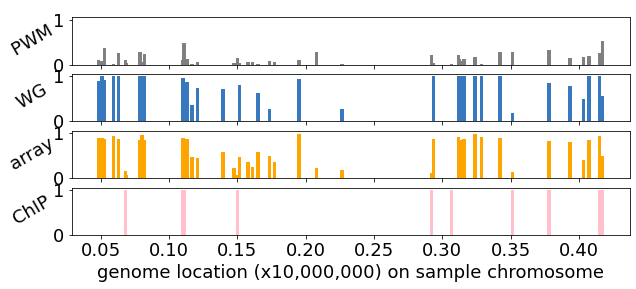

In [248]:
cdict={'GM12878':'red','K-562':'blue','A-549':'green',
       'Hep-G2':'orange','HeLa-S3':'yellow','SK-N-SH':'pink'}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True,figsize=(10,4))
x=(data.start)/10000000

binwidth = 0.0025

l1=ax1.bar(x,data.weight, width=binwidth,label='PWM',color='grey')
l2=ax2.bar(x,1-data.wgbs, width=binwidth,label='WG',color=sns.xkcd_rgb["windows blue"])
l3=ax3.bar(x,1-data.array, width=binwidth,label='array',color='orange')
l4=ax4.bar(x,data.ChIPTF, width=binwidth,label='ChIP',color='pink')
# plt.legend([l1, l2, l3, l4],["PWM", "WG", "array","ChIP"],loc='best')
plt.grid(False)

plt.rcParams.update({'font.size': 18})
h=ax1.set_ylabel('PWM     ')
h.set_rotation(30)
h=ax2.set_ylabel('WG     ')
h.set_rotation(30)
h=ax3.set_ylabel('array     ')
h.set_rotation(30)
h=ax4.set_ylabel('ChIP     ')
h.set_rotation(30)
ax4.set_xlabel('genome location (x10,000,000) on sample chromosome') #chr'+str(chr)+" of CTCF in A549")
# plt.savefig("Desktop/"+Col1+'_'+Col2+"_chr"+str(chr)+"of CTCF in A549.png",dpi=300,bbox_inches = "tight")

#     axs.legend(ncol=3,loc=8)

### Fig SM1

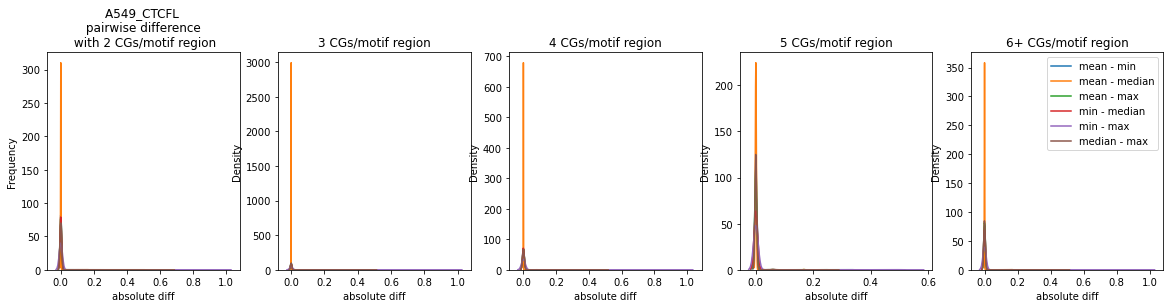

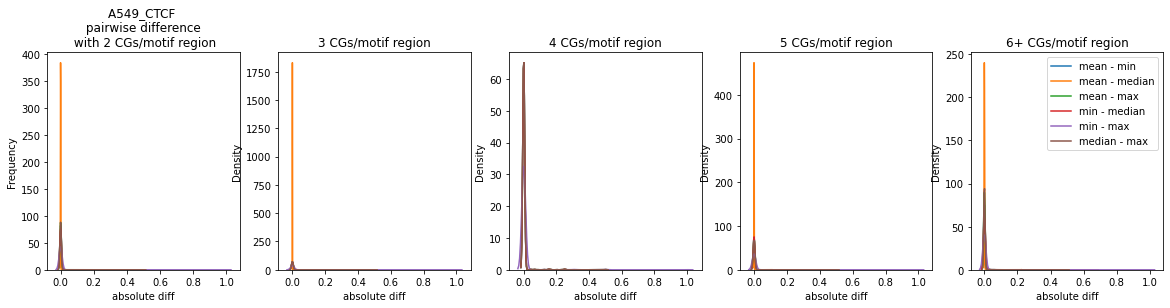

In [57]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# import matplotlib.backends.backend_pdf
table=[]
TF='CTCF'
cell='A549'
# path='../validate_milipeed'
# traces= glob.glob('/udd/redmo/data/MotifPipeline/validate_milipeed/*')
# traces= glob.glob('data/MotifPipeline/val_mili_plusNONcpg/*')
traces= glob.glob('../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta/*')

# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
indices = [i for i, s in enumerate(traces) if cell+'_'+TF in s]

for jac,zzzz in enumerate(indices):
#     data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,4,5,6,7,8,12,13],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF",'shW','shWG','array','shA']) 
#     data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,8,9,10,15],names=["chr", "start", "end",'weight','hits1',"wgbs",'array',"ChIPTF"])
    data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'weight','CG','hits',"wgbs",'array','body','TSS','ChIPTF'])

    # for jac,trace in enumerate(traces):
    table2=[]
    tbl=[]
    tmpTBL2=[]
    tmpTBL=[]
#     data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,5,6,7,8,12,13],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF",'shW','shWG','array','shA']) 

    # Refit data to 0-1    
    data.ChIPTF=data.ChIPTF.replace('.','0')
    data.ChIPTF[data.ChIPTF!=0]=1
    data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
    
#     data=data[data['weight']!=data['array']]
    data['wgbs']=1-(data['wgbs']/100)
    data['array'] = np.where(data['weight'] == data['array'], data['array'],1-data['array'])
#     data=data[((data['hits1']))>=10]

#     data3=data.drop_duplicates()
    df3=data.groupby([data.chr,data.start,data.end,data.weight,data.wgbs]).size().reset_index(name='counts')

    df=data.groupby([data.chr,data.start,data.end]).size().reset_index(name='counts')
    #     data = data.groupby([data.chr,data.start,data.end]).agg({'weight':'mean',"wgbs":'mean',"ChIPTF":'mean',"array":'min'})
    data1 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'mean',"wgbs":'mean',"array":'mean'})
    data1=data1.merge(df,on=['chr','start','end'])
    data1=data1.drop_duplicates()

    data2 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'min',"wgbs":'min',"array":'min'})
    data2=data2.merge(df,on=['chr','start','end'])
    data2=data2.drop_duplicates()
    data3 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'median',"wgbs":'median',"array":'median'})
    data3=data3.merge(df,on=['chr','start','end'])
    data3=data3.drop_duplicates()
    data4 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'max',"wgbs":'max',"array":'max'})
    data4=data4.merge(df,on=['chr','start','end'])
    data4=data4.drop_duplicates()

    f= plt.figure(figsize=(20, 4))
    ## Plot all three value distributions fit to same 0-1 scale


    for jj,start in enumerate(data.start):
        zz=data[data['start']==start]
        if zz.count!=1:
            yy=[np.abs(x - y) for i,x in enumerate(zz.wgbs) for j,y in enumerate(zz.wgbs) if i != j]

        table2.append(np.mean(yy))
        tmpTBL2.append(len(zz))#/np.math.factorial(len(yy)))
    WWW=np.max(tmpTBL2)-1

    data1['freq']=pd.DataFrame(tmpTBL2)
    data2['freq']=pd.DataFrame(tmpTBL2)
    data3['freq']=pd.DataFrame(tmpTBL2)
    data4['freq']=pd.DataFrame(tmpTBL2)

    ax1=plt.subplot(1, 5, 1)
    d1=data1[data1.freq==2]
    if d1.empty is False:
        d2=data2[data2.freq==2]
        d3=data3[data3.freq==2]
        d4=data4[data4.freq==2]
        
        try:
            g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
        except RuntimeError:
            pass
        
#         ax1.legend_.remove()

#         plt.yscale('log',basey=10) 
#         plt.legend(loc='best')
        plt.xlabel('absolute diff')
        plt.ylabel('Frequency')
#         ax1.set_ylim([0,60])
#         plt.title('3 probes/motif region')
#         plt.show()
        plt.title(''+os.path.basename(traces[zzzz])+' \n pairwise difference \n with 2 CGs/motif region')# \n seq read >10')

    if WWW>2:
        ax2=plt.subplot(1, 5, 2)
        d1=data1[data1.freq==3]
        if d1.empty is False:
            d2=data2[data2.freq==3]
            d3=data3[data3.freq==3]
            d4=data4[data4.freq==3]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass

#             plt.yscale('log',basey=10) 
#             plt.legend(loc='best')
            plt.xlabel('absolute diff')
#             plt.ylabel('Frequency')
#             ax2.set_ylim([0,60])
#             ax2.legend_.remove()

            plt.title('3 CGs/motif region')
#             plt.show()


    if WWW>3:
        ax3=plt.subplot(1, 5, 3)
        d1=data1[data1.freq==4]
        if d1.empty is False:
            d2=data2[data2.freq==4]
            d3=data3[data3.freq==4]
            d4=data4[data4.freq==4]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass

#             plt.yscale('log',basey=10) 
#             plt.legend(loc='best')
            plt.xlabel('absolute diff')
#             ax3.set_ylim([0,60])
#             plt.ylabel('Frequency')
#         plt.title('3 probes/motif region')
#         plt.show()
#             plt.legend(loc=None)
#             ax3.legend_.remove()
            plt.title('4 CGs/motif region')
        else:
            pass
    if WWW>4:
        ax4=plt.subplot(1, 5, 4)
        d1=data1[data1.freq==5]
        if d1.empty is False:
            d2=data2[data2.freq==5]
            d3=data3[data3.freq==5]
            d4=data4[data4.freq==5]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass

#             plt.yscale('log',basey=10) 
#             plt.legend(loc='best')
            plt.xlabel('absolute diff')
#             ax4.set_ylim([0,60])
#             plt.ylabel('Frequency')
#             plt.title('3 probes/motif region')
#             plt.show()
#             plt.legend(loc=None)
#             ax4.legend_.remove()
            plt.title('5 CGs/motif region')
        else:
            pass
    if WWW>5:
        ax5=plt.subplot(1, 5, 5)
        d1=data1[data1.freq==6]
        if d1.empty is False:
            d2=data2[data2.freq==6]
            d3=data3[data3.freq==6]
            d4=data4[data4.freq==6]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass
#             plt.ylabel('Frequency')
#             plt.title('3 probes/motif region')
#             plt.show()
            plt.legend(loc='best')
            plt.xlabel('absolute diff')
#             ax5.set_ylim([0,60])
            plt.title('6+ CGs/motif region')
        else:
            pass
#     if WWW>6:
#         plt.subplot(1, WWW, 6,frameon=False)
#     fig.patch.set_visible(False)
#     plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
#     plt.xticks([])
#     plt.yticks([])
#         d1=data1[data1.freq>6]
#     plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
#         if d1.empty is False:
#             d2=data2[data2.freq>6]
#             d3=data3[data3.freq>6]
#             d4=data4[data4.freq>6]
#             colors = ['mean-min','mean-median','mean-max','min-median','min-max','median-max']
#             plt.hist([(d1['wgbs']-d2['wgbs']).abs(),(d1['wgbs']-d3['wgbs']).abs(),
#                       (d1['wgbs']-d4['wgbs']).abs(),(d2['wgbs']-data3['wgbs']).abs(),
#                       (d2['wgbs']-d4['wgbs']).abs(),(d3['wgbs']-data4['wgbs']).abs()],
#                      alpha=.5,log=True,stacked=False,label=colors)
# #             plt.legend(loc='best')
#             plt.xlabel('abs Diff')

#     #         plt.ylabel('Frequency')
#             plt.title('...& 7+ probe/gene')


#     if jac== X:
#         plt.savefig("netZooPy/tests/milipeed/ToyFigs/exProbePerGene.png",dpi=300,bbox_inches = "tight")
    plt.show()

### Fig S3

In [ ]:
# cdict={'GM12878':'red','K-562':'blue','A-549':'green',
    'Hep-G2':'orange','HeLa-S3':'yellow','SK-N-SH':'pink'}
TF='CTCF'
chr='chr1'
cell='A-549'
# traces= glob.glob('data/MotifPipeline/MeArrayIntersectFULLshuf/*')
# traces= glob.glob('data/MotifPipeline/ENCODE/wgbsin/*')
# traces= glob.glob('data/MotifPipeline/MeArrayIntersectFULLshuf/*')
# indices = [i for i, s in enumerate(traces) if gene in s]
tab=[]
# for j,zz in enumerate(indices):
data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,8,9,10,15],names=["chr", "start", "end",'weight','hits1',"wgbs",'array',"ChIPTF"])
# data=pd.read_csv('data/MotifPipeline/MeArrayIntersectFULLshuf/A-549_CTCF',sep='\t',usecols=[0,1,2,3,4,5,6,7,8,12,13],names=["chr", "start", "end",'weight',"wgbs",'gene',"ChIPTF",'shW','shWG','array','shA']) 
# data.loc[data.weight == data.wgbs, 'wgbs'] = 0
# data.loc[data.weight == data.array, 'array'] = 0
data=data[data['weight']!=data['wgbs']] ##subset of motif or entire motif flag
data=data[data['weight']!=data['array']]
# data=data[data['wgbs']!=0]
# data=data[data['array']!=0]
# data['W1']=1-data['W1']

# data=data[((data['hits1']+data['hits2'])/2)>=20]
# data=data[((data['hits1']))>=10]


# data['wgbs2']=1-((data.W1+data.W2)/2)/100

# data=data[data.W1<=100]
# data=data[data.W2<=100]
# data.W1=(data.W1/100)
# data.W2=(data.W2/100)
# data=data[data['W1']!=0]
# data=data[data['W2']!=0]


df2=data
df2.hits1.astype('category')

f= plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF,fontsize=16)
# plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Array',fontsize=16)

plt.subplot(2, 3, 2)
df2=df2[df2['hits1']>=10]
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits>10',fontsize=16)
# plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Array',fontsize=16)

plt.subplot(2, 3, 3)
df2=df2[df2['hits1']>=20]
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits >20',fontsize=16)
# plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Array',fontsize=16)

df2=data
df2.hits1.astype('category')

ax1=plt.subplot(2, 3, 4)
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
# plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF,fontsize=16)
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title(len(df2),fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)
ax1.set_ylim([0,100000])

ax2=plt.subplot(2, 3, 5)
df2=df2[df2['hits1']>=10]
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
# plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits>10',fontsize=16)
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)

ax2.set_ylim([0,100000])

ax3=plt.subplot(2, 3, 6)
df2=df2[df2['hits1']>=20]
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
# plt.legend(loc='best')
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+ '\n removing probes with less than 20 reads' ,fontsize=16)
# plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits >20',fontsize=16)
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)
ax3.set_ylim([0,100000])

# fig.show()


## process various different window buffers

In [91]:

import glob, os
import numpy as np
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# import matplotlib.backends.backend_pdf

# agg_meth='median'
# buffer='500' -- inherited from outdir

def buffer_distr_comp(agg_meth='mean',outdir='data/MotifPipeline/sthlm_motif_50_QCbeta/red/'):
    i=0
    traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/*')
    traces = list(filter(lambda file: os.stat(file).st_size > 0, traces))
    buffer=outdir.split('/')[2]
    buffer=buffer.split('_')[2]
    pwm_sp=[]
    wg_sp=[]
    me_sp=[]
    Path(outdir+'/'+agg_meth).mkdir(parents=True, exist_ok=True)
    # indices = [i for i, s in enumerate(traces) if 'sthml_auroc_meltbox' in s]
    for trace in (traces):

        try:
            data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],
                             names=["chr", "start", "end",'weight','pval',"hits1",'W1','array','region','gene','ChIPTF'],engine='python')
            data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())
            data['wgbs']=data.W1/100
            data.wgbs=1-data.wgbs
            data.array=1-data.array
            # print(data)

            trace2=os.path.basename(trace)#.split('/')[4]
        
            com_data=pd.read_csv(outdir+'/'+trace2,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],
                                 names=["chr", "start", "end",'weight','pval',"hits1",'W1','array','region','gene','ChIPTF'],engine='python')
            com_data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())
            com_data['wgbs']=com_data.W1/100
            com_data.wgbs=1-com_data.wgbs
            com_data.array=1-com_data.array
#         print(com_data)
        
            cell=os.path.basename(trace).split('_')[0]
            TF=os.path.basename(trace).split('_')[1]
            data = data.groupby([data.chr,data.start,data.end]).agg({'weight':agg_meth,"wgbs":agg_meth,"ChIPTF":'max',"array":agg_meth,'hits1':'mean','W1':'mean'})
            com_data = com_data.groupby([com_data.chr,com_data.start,com_data.end]).agg({'weight':agg_meth,"wgbs":agg_meth,"ChIPTF":'max',"array":agg_meth,'hits1':'mean','W1':'mean'})

            data2=data.merge(com_data,on=['chr','start','end'])
            pwm=(sp.stats.spearmanr(data2.weight_x,data2.weight_y)[0])
            wg=(sp.stats.spearmanr(data2.wgbs_x,data2.wgbs_y)[0])
            me=(sp.stats.spearmanr(data2.array_x,data2.array_y)[0])
            i=i+1
            column= pwm,wg,me
#             print(pwm_sp,wg_sp,me_sp)
            np.transpose(pd.DataFrame((column))).to_csv(outdir+'/'+agg_meth+'/'+buffer+'_'+agg_meth+'_sthlm_distr_comp.txt',mode='a',index=False,header=False)
#             print('running distribution comparison between 0 and '+buffer+' for '+TF+' in '+cell)
        #         return pwm_sp
            pwm_sp.append(pwm)
            wg_sp.append(wg)
            me_sp.append(me)
            column= pwm_sp,wg_sp,me_sp
        except:
            pass
            print('missing data for taking '+agg_meth+' of '+TF+' in '+cell)
    return column

In [ ]:
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_5_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_5_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_50_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_50_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_10_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_10_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_20_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_20_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_100_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_100_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_250_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_250_QCbeta/red/')
ww=buffer_distr_comp('mean','data/MotifPipeline/sthlm_motif_500_QCbeta/red/')
cc=buffer_distr_comp('median','data/MotifPipeline/sthlm_motif_500_QCbeta/red/')

## Null Hypo H0 A

In [ ]:
allbox = pd.DataFrame()
agg_meth='mean'
method='auroc'
traces= glob.glob('data/MotifPipeline/**/red/test/'+agg_meth+'/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_'+method+'_meltbox' in s]
for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
#     print(buffer)
    meltbox=pd.read_csv(trace,sep='\t',index_col=0)
    meltbox['buffer']=buffer
    allbox=pd.concat([allbox,meltbox],axis=0)
#     allbox
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
allbox['data_buff']=allbox['data']+'_'+allbox['buffer'].astype(str)
from pathlib import Path
outdir='data/MotifPipeline/compare'
Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
# col_list = [A549]
cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# for cell in cells:
for test in tests:
    allbox2=allbox[allbox['data_buff'].str.contains(pat=test)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
    allbox2.buffer=(allbox2.buffer).astype(int)
    allbox2=allbox2.sort_values(by='buffer')
    ##limit TF to those found with no buffer
#         TFF=allbox2[allbox2.buffer==0]
#         allbox2=allbox2[allbox2.TF.isin(TFF.TF)]

    g=sns.boxplot(x='buffer',y='AUROC', data=allbox2)
    g=sns.swarmplot(x='buffer',y='AUROC', data=allbox2,size=2, color=".3", linewidth=0)
    g.set(ylim=(0, 1))
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g=plt.title(test)

    plt.savefig(outdir+"/sthlm_allCell"+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
    plt.show()
    plt.close()

### Fig SM4A

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


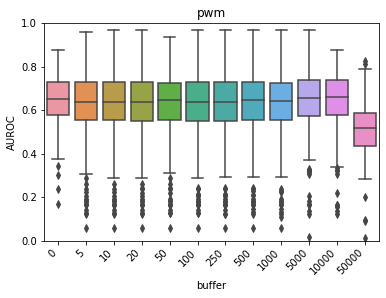

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


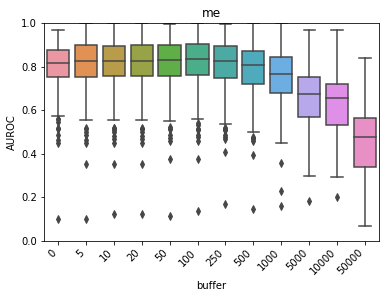

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


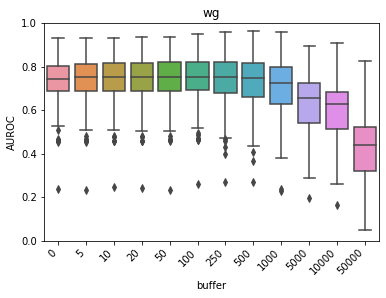

In [780]:
allbox = pd.DataFrame()
agg_meth='mean'
method='auroc'
traces= glob.glob('data/MotifPipeline/**/red/test/all/all/*.txt',recursive = True)
traces2= glob.glob('/pc/redmo/data/MotifPipeline/**/red/test/all/all/*.txt',recursive = True)
traces=traces+traces2
indices = [i for i, s in enumerate(traces) if 'sthlm_'+method+'_meltbox' in s]
for jac in (indices):
    trace=traces[jac]
    if 'pc' in trace:
        buffer=(trace).split('/')[5]
        buffer=(buffer).split('_')[2]
    else:
        buffer=(trace).split('/')[2]
        buffer=(buffer).split('_')[2]
#     print(buffer)
    meltbox=pd.read_csv(trace,sep='\t',index_col=0)
    meltbox['buffer']=buffer
    allbox=pd.concat([allbox,meltbox],axis=0)
#     allbox
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
allbox['data_buff']=allbox['data']+'_'+allbox['buffer'].astype(str)
from pathlib import Path
outdir='data/MotifPipeline/compare'
Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
# col_list = [A549]
cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# for cell in cells:
for test in tests:

    allbox2=allbox[allbox['data_buff'].str.contains(pat=test)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
    allbox2.buffer=(allbox2.buffer).astype(int)
    allbox2=allbox2.sort_values(by='buffer')
    ##limit TF to those found with no buffer
#         TFF=allbox2[allbox2.buffer==0]
#         allbox2=allbox2[allbox2.TF.isin(TFF.TF)]
    g=sns.boxplot(x='buffer',y='AUROC', data=allbox2)
#     g=sns.swarmplot(x='buffer',y='AUROC', data=allbox2,size=2, color=".3", linewidth=0)
    g.set(ylim=(0, 1))
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g=plt.title(test)

    plt.savefig(outdir+"/sthlm_allCell"+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
    plt.show()
    plt.close()

## gather and plot methyl datatype distance across buffers Fig SM2

Text(0.5, 1.0, 'mean pairwise distance across all TF/cell combs')

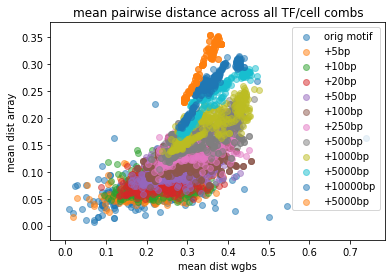

In [844]:
d1=pd.read_table('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d1=d1[d1.cell!='0']

d2=pd.read_table('data/MotifPipeline/sthlm_motif_5_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d2=d2[d2.cell!='0']

d3=pd.read_table('data/MotifPipeline/sthlm_motif_10_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d3=d3[d3.cell!='0']

d4=pd.read_table('data/MotifPipeline/sthlm_motif_20_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d4=d4[d4.cell!='0']

d5=pd.read_table('data/MotifPipeline/sthlm_motif_50_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d5=d5[d5.cell!='0']

d6=pd.read_table('data/MotifPipeline/sthlm_motif_100_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d6=d6[d6.cell!='0']  

d7=pd.read_table('data/MotifPipeline/sthlm_motif_250_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d7=d7[d7.cell!='0']  

d8=pd.read_table('data/MotifPipeline/sthlm_motif_500_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d8=d8[d8.cell!='0'] 

d9=pd.read_table('data/MotifPipeline/sthlm_motif_1000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d9=d9[d9.cell!='0']  

d10=pd.read_table('../../../pc/redmo/data/MotifPipeline/sthlm_motif_5000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d10=d10[d10.cell!='0']  

d11=pd.read_table('../../../pc/redmo/data/MotifPipeline/sthlm_motif_10000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d11=d11[d11.cell!='0']  

d12=pd.read_table('../../../pc/redmo/data/MotifPipeline/sthlm_motif_50000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d12=d12[d12.cell!='0']  

plt.scatter(d1.mean_dist_array,d1.mean_dist_wg,label='orig motif',alpha=.5)
plt.scatter(d2.mean_dist_array,d2.mean_dist_wg,label='+5bp',alpha=.5)
plt.scatter(d3.mean_dist_array,d3.mean_dist_wg,label='+10bp',alpha=.5)
plt.scatter(d4.mean_dist_array,d4.mean_dist_wg,label='+20bp',alpha=.5)
plt.scatter(d5.mean_dist_array,d5.mean_dist_wg,label='+50bp',alpha=.5)
plt.scatter(d6.mean_dist_array,d6.mean_dist_wg,label='+100bp',alpha=.5)
plt.scatter(d7.mean_dist_array,d7.mean_dist_wg,label='+250bp',alpha=.5)
plt.scatter(d8.mean_dist_array,d8.mean_dist_wg,label='+500bp',alpha=.5)
plt.scatter(d9.mean_dist_array,d9.mean_dist_wg,label='+1000bp',alpha=.5)
plt.scatter(d10.mean_dist_array,d10.mean_dist_wg,label='+5000bp',alpha=.5)
plt.scatter(d11.mean_dist_array,d11.mean_dist_wg,label='+10000bp',alpha=.5)
plt.scatter(d12.mean_dist_array,d12.mean_dist_wg,label='+5000bp',alpha=.5)

# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend(loc="best")#,bbox_to_anchor=(1,1))
plt.xlabel('mean dist wgbs')
plt.ylabel('mean dist array')
plt.title('mean pairwise distance across all TF/cell combs')

Text(0.5, 1.0, 'median pairwise distance across all TF/cell combs')

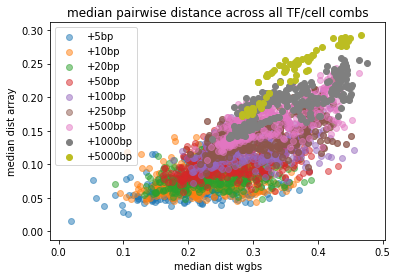

In [111]:
# d1=pd.read_table('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
# d1=d1[d1.cell!='0']

d2=pd.read_table('data/MotifPipeline/sthlm_motif_5_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d2=d2[d2.cell!='0']

d3=pd.read_table('data/MotifPipeline/sthlm_motif_10_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d3=d3[d3.cell!='0']

d4=pd.read_table('data/MotifPipeline/sthlm_motif_20_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d4=d4[d4.cell!='0']

d5=pd.read_table('data/MotifPipeline/sthlm_motif_50_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d5=d5[d5.cell!='0']

d6=pd.read_table('data/MotifPipeline/sthlm_motif_100_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d6=d6[d6.cell!='0']  

d7=pd.read_table('data/MotifPipeline/sthlm_motif_250_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d7=d7[d7.cell!='0']  

d8=pd.read_table('data/MotifPipeline/sthlm_motif_500_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d8=d8[d8.cell!='0'] 

d9=pd.read_table('data/MotifPipeline/sthlm_motif_1000_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d9=d9[d9.cell!='0']  

d10=pd.read_table('data/MotifPipeline/sthlm_motif_5000_QCbeta/red/test/median/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d10=d10[d10.cell!='0']  

# plt.scatter(d1.mean_dist_array,d1.mean_dist_wg,label='orig motif',alpha=.5)
plt.scatter(d2.mean_dist_array,d2.mean_dist_wg,label='+5bp',alpha=.5)
plt.scatter(d3.mean_dist_array,d3.mean_dist_wg,label='+10bp',alpha=.5)
plt.scatter(d4.mean_dist_array,d4.mean_dist_wg,label='+20bp',alpha=.5)
plt.scatter(d5.mean_dist_array,d5.mean_dist_wg,label='+50bp',alpha=.5)
plt.scatter(d6.mean_dist_array,d6.mean_dist_wg,label='+100bp',alpha=.5)
plt.scatter(d7.mean_dist_array,d7.mean_dist_wg,label='+250bp',alpha=.5)
plt.scatter(d8.mean_dist_array,d8.mean_dist_wg,label='+500bp',alpha=.5)
plt.scatter(d9.mean_dist_array,d9.mean_dist_wg,label='+1000bp')
plt.scatter(d10.mean_dist_array,d10.mean_dist_wg,label='+5000bp')

# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend(loc="best")#,bbox_to_anchor=(1,1))
plt.xlabel('median dist wgbs')
plt.ylabel('median dist array')
plt.title('median pairwise distance across all TF/cell combs')

# null Hypo H0 B


## simiarly, this script intersects main analysis 4 data types with varying windows ***around the METHYL location***
* -b other than 0 corresponds to null H0 B

In [ ]:
! bash mili_benchmark/camb_motif_pipeline_gamma.sh -b5 -c'A549 K562 GM12878 SKNSH HepG2 HeLa' -o'proj/remprs/rempr00/data/MotifPipeline/all_four_expMethyl'

In [4]:
buffer

'750'

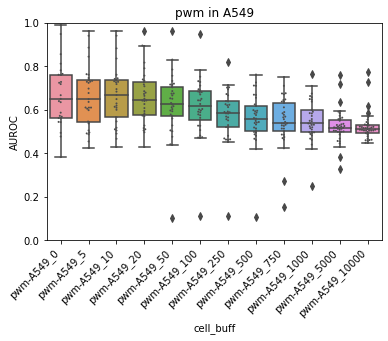

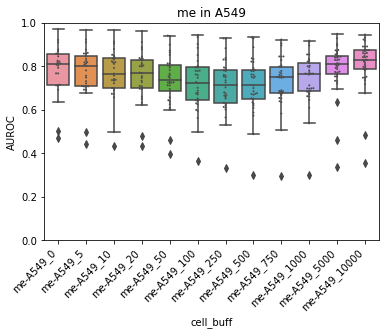

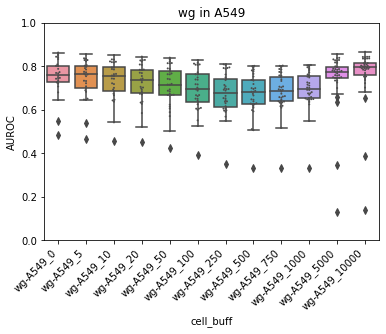

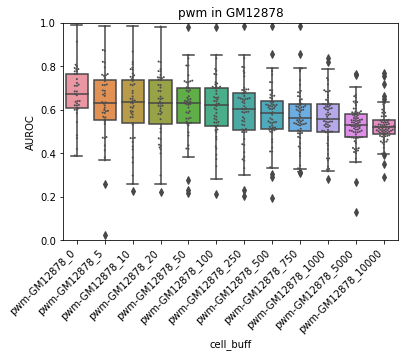

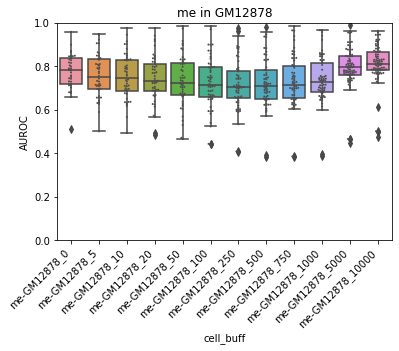

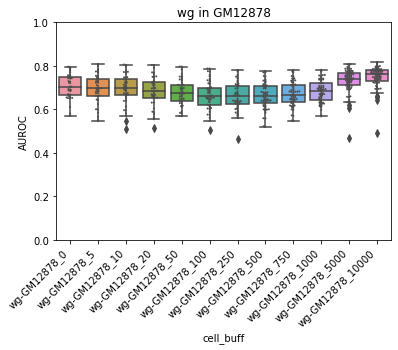

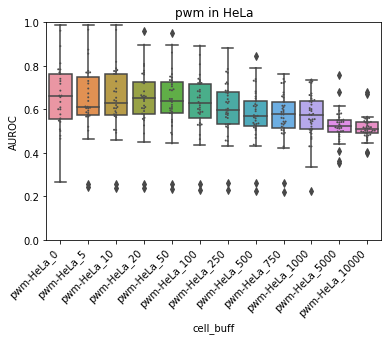

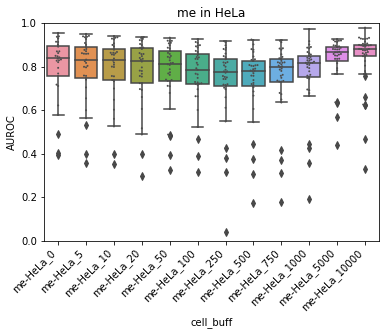

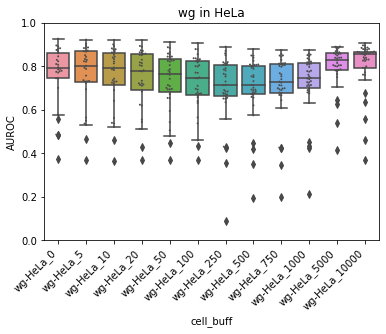

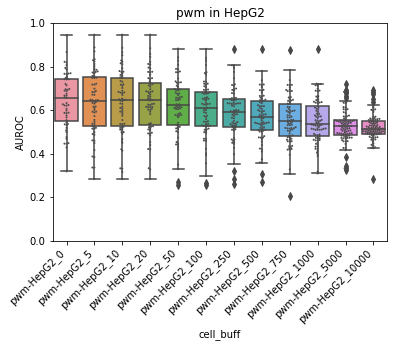

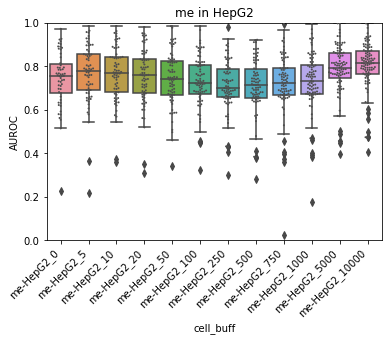

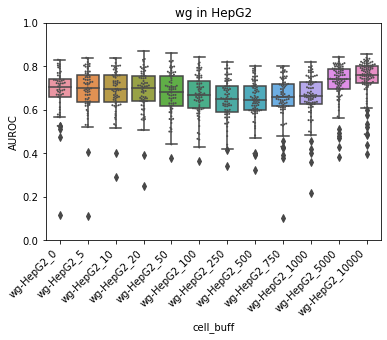

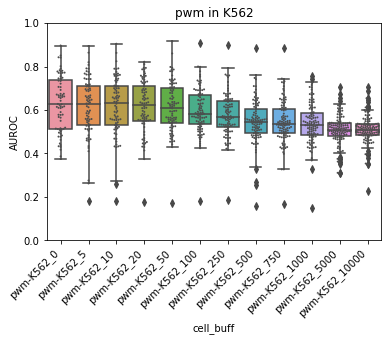

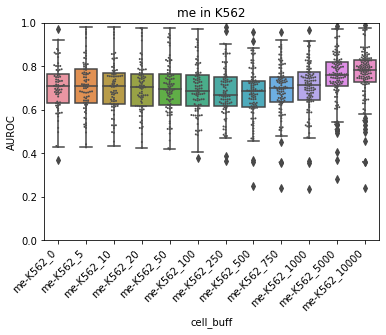

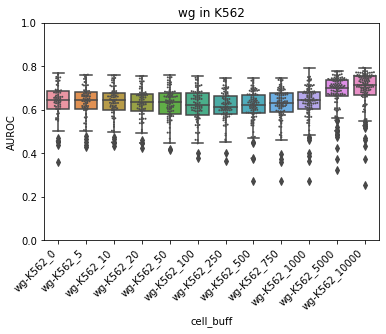

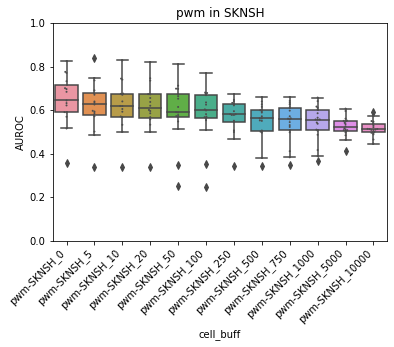

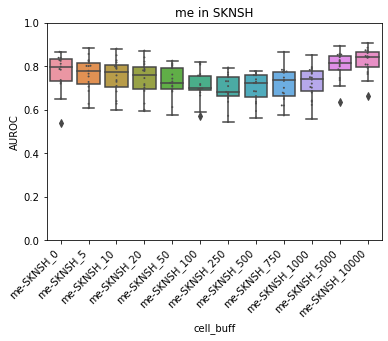

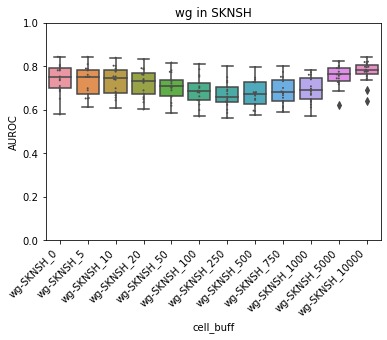

In [7]:
# indir1='../../pc/redmo/data/MotifPipeline/**'
# indir2='../../d/tmp/redmo/data/MotifPipeline/**'
outdir='../../d/tmp/redmo/data'
allbox = pd.DataFrame()
# traces1= glob.glob(indir1+'/test/*.txt',recursive = True)
# traces2= glob.glob(indir2+'/test/*.txt',recursive = True)
# traces=traces1+traces2

indir='../../d/tmp/redmo/data/PipeTest/**'
traces= glob.glob(indir+'/test/*.txt',recursive = True)

indices = [i for i, s in enumerate(traces) if 'camb_auroc_meltbox' in s]
method='auroc'

for jac in (indices):
    trace=traces[jac]
    if 'pc' in trace:
        buffer=(trace).split('/')[6]

    elif 'd/tmp' in trace:
        buffer=(trace).split('/')[7]
#     buffer=(buffer).split('_')[3]
#     buffer=(buffer).split('a')[2]

    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
from pathlib import Path
# outdir='data/MotifPipeline/compare'
Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)

cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
for cell in cells: ##### aggregate across all cellines per data type
    for test in tests:
        allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
        allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
        allbox2.buffer=(allbox2.buffer).astype(int)
        allbox2=allbox2.sort_values(by='buffer')
        g=sns.boxplot(x='cell_buff',y=method.upper(), data=allbox2)
        g=sns.swarmplot(x='cell_buff',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0)
        g.set(ylim=(0, 1))
        g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
        g.set_title(test+' in '+cell)
        plt.show()
        plt.savefig(outdir+"camb_allbox_buff.png",dpi=300,bbox_inches = "tight")
        plt.close()
# return

In [57]:
# indirs=glob.glob('../../d/tmp/redmo/data/MotifPipeline/camb_motif_pipeline_gamma*') #500/'
# indirs[1:2]
# count

### Fig SM4B 

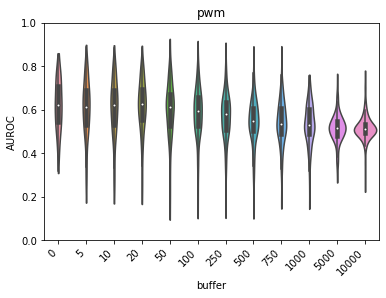

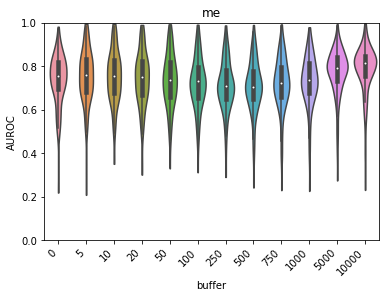

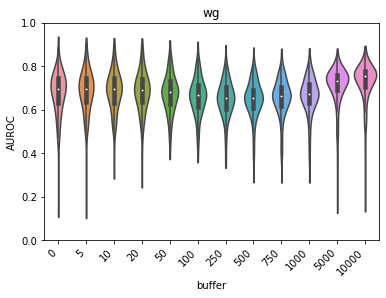

In [12]:
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()

count=allbox.groupby([allbox.TF,allbox.data,allbox.buffer],as_index=False).mean()

# allbox['data_buff']=allbox['data']+'_'+allbox['buffer'].astype(str)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
# # plt.figure(figsize=(12, 5))
# plt.xticks(rotation=30)
# # col_list = [A549]
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# for cell in cells:
for test in tests:

    allbox2=count[count['data'].str.contains(pat=test)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
    allbox2.buffer=(allbox2.buffer).astype(int)
    allbox2=allbox2.sort_values(by='buffer')
    ##limit TF to those found with no buffer
#         TFF=allbox2[allbox2.buffer==0]
#         allbox2=allbox2[allbox2.TF.isin(TFF.TF)]
    g=sns.violinplot(x='buffer',y='AUROC', data=allbox2,cut=.2)
#     g=sns.swarmplot(x='buffer',y='AUROC', data=allbox2,size=2, color=".3", linewidth=0)
    g.set(ylim=(0, 1))
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g=plt.title(test)

    plt.savefig(outdir+"/sthlm_allCell"+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
    plt.show()
    plt.close()

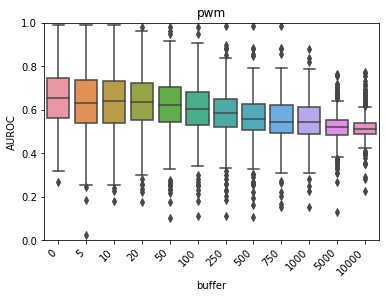

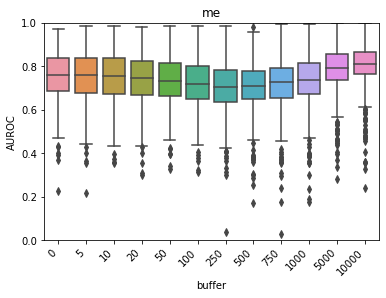

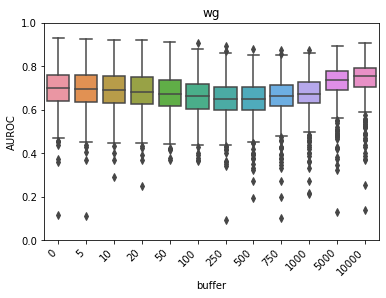

In [13]:

allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
allbox['data_buff']=allbox['data']+'_'+allbox['buffer'].astype(str)
from pathlib import Path
outdir='data/MotifPipeline/compare'
Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
# col_list = [A549]
cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# for cell in cells:
for test in tests:

    allbox2=allbox[allbox['data_buff'].str.contains(pat=test)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
    allbox2.buffer=(allbox2.buffer).astype(int)
    allbox2=allbox2.sort_values(by='buffer')
    ##limit TF to those found with no buffer
#         TFF=allbox2[allbox2.buffer==0]
#         allbox2=allbox2[allbox2.TF.isin(TFF.TF)]
    g=sns.boxplot(x='buffer',y='AUROC', data=allbox2)
#     g=sns.swarmplot(x='buffer',y='AUROC', data=allbox2,size=2, color=".3", linewidth=0)
    g.set(ylim=(0, 1))
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g=plt.title(test)

    plt.savefig(outdir+"/sthlm_allCell"+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
    plt.show()
    plt.close()

In [402]:
jj=allbox[allbox['buffer']=='100']
# gg=allbox2[allbox2['data_buff']=='array_10']
# jj
# wg10 = jj.groupby(['data - cell line'])[method.upper()].median()
# me10 = gg.groupby(['data - cell line'])[method.upper()].median()
# [wg10,me10]
ww=jj.groupby(['cell_buff'])[method.upper()].median()

In [403]:
[ww[6]-ww[0],
ww[7]-ww[1],
 ww[8]-ww[2],
 ww[9]-ww[3],
 ww[10]-ww[4],
 ww[11]-ww[5]
]

[-0.11813322762450962,
 -0.09033785713799158,
 -0.1652114406332934,
 -0.1047147192659379,
 -0.10401407241737148,
 -0.1010386936789408]

In [404]:
[ww[6]-ww[12],
ww[7]-ww[13],
 ww[8]-ww[14],
 ww[9]-ww[15],
 ww[10]-ww[16],
 ww[11]-ww[17]
]

[-0.08845096982689127,
 -0.04050724752974655,
 -0.11821562474428049,
 -0.052249493248986645,
 -0.04286177957064041,
 -0.0875416422480414]

### this script only intersect motif with WGBS and then ChiP

In [ ]:
! bash mili_benchmark/cbus_motif_pipeline_gamma.sh -b0 -c'A549 K562 GM12878 SKNSH HepG2 HeLa' -o'proj/remprs/rempr00/data/MotifPipeline/no_array'

In [ ]:
# trace='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_delta0/'
indices = [i for i, s in enumerate(traces) if 'HeLa' in s]
trace=traces[indices[1]]
data=pd.read_csv(trace,sep='\t',skiprows=1,usecols=[0,1,2,3,4,8,9,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'ChIPTF'])#,'body','TSS'])
data=data.fillna(0)
data.ChIPTF=data.ChIPTF.replace('.',0)
# print(data.shape)
Col2=os.path.basename(trace).split('_')[1] #TF
data.ChIPTF[(data.ChIPTF==Col2)]=1
data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
data.ChIPTF=pd.to_numeric(data.ChIPTF)
sum(data.ChIPTF)

In [27]:
trace

'../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_delta0/K562_SIX5'

In [ ]:
import shutil

indir='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_delta0'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'txt' not in s]
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[i]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
#     for TSS in enumerate(www):
    Col1=os.path.basename(trace).split('_')[0] #cell
    Col2=os.path.basename(trace).split('_')[1] #TF
#         TSS=TSS[1]
# #         if Col1=='GM12878':
# #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
# #             cc=data.body.str.find(TSS)
# #             cc[cc!=-1]=TSS
# #             data['TSS']=cc
# #             print(Col2+'in'+Col1)
# #         else:
    try:
        data=pd.read_csv(trace,sep='\t',skiprows=1,usecols=[0,1,2,3,4,8,9,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'ChIPTF'])#,'body','TSS'])
    #                 break

    #     data=data[data['TSS']==TSS]


        table2=[]
        tbl=[]
        tmpTBL2=[]
        tmpTBL=[]
        table3=[]
        tblC=[]
        tmpTBLC=[]
        data.pwm=data.pwm.astype('float')
        data.pwm=(data['pwm']-data['pwm'].min())/(data['pwm'].max()-data['pwm'].min())
        data=data.fillna(0)
        data.ChIPTF=data.ChIPTF.replace('.',0)
        # print(data.shape)
        data.ChIPTF[(data.ChIPTF==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)
        

        if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

            plt.plot([0, 1], [0, 1], 'k--')
            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
            roc_auc=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc2=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc2),
                     color='r', linestyle=':', linewidth=4)
            Col66=data.shape[0]
            data=data[data.hits>10]

            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
            roc_auc3=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc3),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc4=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc4),
                     color='r', linestyle=':', linewidth=4)

            Col1=cell
            Col2=TF
            Col3=roc_auc #motif auroc
            Col4=roc_auc2
            Col5=roc_auc3
            Col55=roc_auc4
            Col6=data.shape[0]
            Col7=np.sum(data.ChIPTF)
            column = [Col1, Col2, Col3, Col4,Col5,Col55,Col66,Col6,Col7]
            print(column)
            column=np.transpose(pd.DataFrame((column)))
            column.to_csv(indir+'/test/'+TSS+'_PRE_window_methyl_great10.txt',mode='a',header=False,index=False)
            aurocs=pd.concat([aurocs,column],axis=0)
            print("AUROC calculated for "+TF+" in "+cell)
    except:
        pass

### Fig S2B

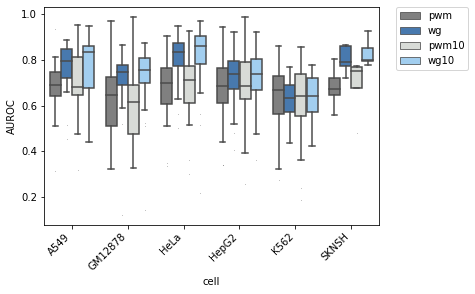

In [110]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
# www=['TSS1500','TSS200',  "5'UTR",'ExonBnd']
indir='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_delta0'
traces= glob.glob(indir+'/test/*_PRE_window_methyl_great10.txt',recursive = True)
# indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for i,trace in enumerate(traces):
#     trace=traces[jac]
    TSS=(traces[i]).split('/')[9]
    TSS=(TSS).split('_')[0]
#     region=(trace).split('/')[5]
#     depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep=',',names=['cell','TF','pwm','wg','pwm10','wg10','fullsize','size10','yes'])
#     meltbox['TSS']=TSS
#     print(pd.unique(meltbox.cell))
#     meltbox['buffer']=buffer
    
#     meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox00=pd.melt(allbox, id_vars=['cell','TF','fullsize','size10','yes'], value_vars=['pwm','wg','pwm10','wg10'])
allbox00['AUROC']=allbox00['value']
del allbox00['value']

allbox11=pd.melt(allbox, id_vars=['cell','TF','fullsize','size10','yes','pwm','pwm10'], value_vars=['wg','wg10'])
allbox11['AUROC']=allbox11['value']
del allbox11['value']
# allbox11=pd.melt(allbox, id_vars=['cell','size','yes'], value_vars=['pwm','pwm10'])
# allbox22=pd.melt(allbox, id_vars=['cell','size','yes'], value_vars=['wg','wg10'])
# allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])




# allbox11=allbox11[allbox11.cell!='overlap']
# allbox11['AUROC']=allbox11['value']
# del allbox11['value']
# aa=allbox11[allbox11['TSS']==www[0]]
# bb=allbox11[allbox11['TSS']==www[1]]
# cc=allbox11[allbox11['TSS']==www[2]]
# dd=allbox11[allbox11['TSS']==www[3]]
# # ee=allbox11[allbox11['TSS']==www[4]]
# allboxx11=pd.concat([aa,bb,cc,dd])#,ee])

# allbox22=allbox22[allbox22.cell!='overlap']
# allbox22['AUROC']=allbox22['value']
# del allbox22['value']
# aa=allbox22[allbox22['TSS']==www[0]]
# bb=allbox22[allbox22['TSS']==www[1]]
# cc=allbox22[allbox22['TSS']==www[2]]
# dd=allbox22[allbox22['TSS']==www[3]]
# # ee=allbox22[allbox22['TSS']==www[4]]
# allboxx22=pd.concat([aa,bb,cc,dd])#,ee])

# allbox33=allbox33[allbox33.cell!='overlap']
# allbox33['AUROC']=allbox33['value']
# del allbox33['value']
# aa=allbox33[allbox33['TSS']==www[0]]
# bb=allbox33[allbox33['TSS']==www[1]]
# cc=allbox33[allbox33['TSS']==www[2]]
# dd=allbox33[allbox33['TSS']==www[3]]
# ee=allbox33[allbox33['TSS']==www[4]]
# allboxx33=pd.concat([aa,bb,cc,dd,ee])
allbox00=allbox00.sort_values(['cell','variable'], axis=0)
aa=allbox00[allbox00['variable']=='pwm']
bb=allbox00[allbox00['variable']=='wg']
cc=allbox00[allbox00['variable']=='pwm10']
dd=allbox00[allbox00['variable']=='wg10']
allbox00=pd.concat([aa,bb,cc,dd])
plt.xticks(rotation=30)
g=sns.boxplot(x='cell',y=method.upper(), data=allbox00,hue='variable',fliersize = .1,palette=['grey',sns.xkcd_rgb["windows blue"],sns.xkcd_rgb["light grey"],sns.xkcd_rgb["light blue"]])
# g=sns.boxplot(x='region',y=method.upper(), data=allbox2,hue='data',palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('PWM')
plt.show()

# h=sns.boxplot(x='TSS',y=method.upper(), data=allboxx22,hue='cell',fliersize = .1)
# h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('WGBS')
# plt.show()

# j=sns.boxplot(x='TSS',y=method.upper(), data=allboxx33,hue='cell',fliersize = .1)
# j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
# plt.show()
# plt.xticks(rotation=30)


In [111]:
# allbox11=allbox11.groupby(['variable','TF']).mean()
# allbox11

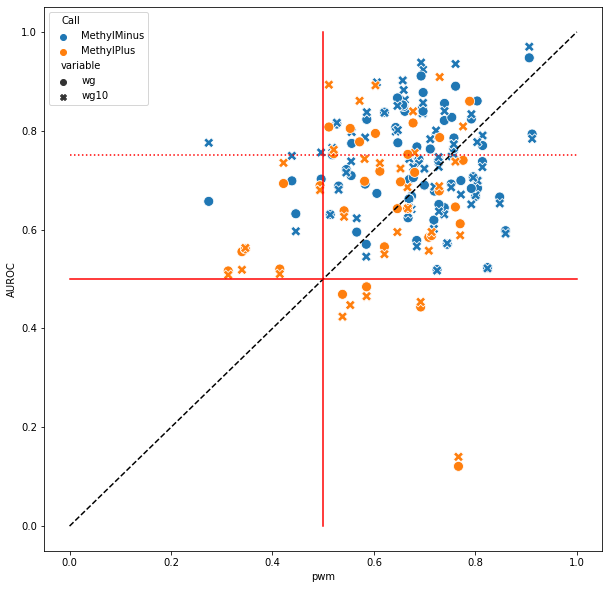

In [112]:
df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc
allboxxx22=allbox11.groupby(['variable','AUROC','TF']).mean()
allboxxx22=allboxxx22.reset_index()
# yyy=allboxxx22[allboxxx22['variable']=='array']
# xxx=allboxxx22[allboxxx22['variable']=='wg']

# allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
# ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb])

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=aa, x="pwm", y='AUROC', hue="Call",style="variable",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')

In [74]:
aa=allbox00[allbox00['variable']=='pwm']
bb=allbox00[allbox00['variable']=='wg']
pwm_med = aa.groupby(['cell'])[method.upper()].median()
wg_med = bb.groupby(['cell'])[method.upper()].median()
# me_med = cc.groupby(['cell'])[method.upper()].median()
[pwm_med,pwm_med-wg_med]

[cell
 A549       0.675708
 GM12878    0.646664
 HeLa       0.700702
 HepG2      0.651493
 K562       0.631897
 Name: AUROC, dtype: float64,
 cell
 A549      -0.138780
 GM12878   -0.102018
 HeLa      -0.128784
 HepG2     -0.087678
 K562       0.000588
 Name: AUROC, dtype: float64]

In [82]:
np.mean(allbox00['size10'])

466634.24666666664

In [73]:
aa=allbox00[allbox00['variable']=='pwm10']
bb=allbox00[allbox00['variable']=='wg10']
pwm_med = aa.groupby(['cell'])[method.upper()].median()
wg_med = bb.groupby(['cell'])[method.upper()].median()
# me_med = cc.groupby(['cell'])[method.upper()].median()
[pwm_med,pwm_med-wg_med]

[cell
 A549       0.675005
 GM12878    0.639158
 HeLa       0.707343
 HepG2      0.667426
 K562       0.629679
 Name: AUROC, dtype: float64,
 cell
 A549      -0.162211
 GM12878   -0.122422
 HeLa      -0.141780
 HepG2     -0.076910
 K562      -0.006344
 Name: AUROC, dtype: float64]

## straight PWM benchmark

In [ ]:
import shutil

indir='../../d/tmp/redmo/data/MotifPipeline/lbk_motif_pipeline_gamma0'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'txt' not in s]
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[i]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
#     for TSS in enumerate(www):
    Col1=os.path.basename(trace).split('_')[0] #cell
    Col2=os.path.basename(trace).split('_')[1] #TF
#         TSS=TSS[1]
# #         if Col1=='GM12878':
# #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
# #             cc=data.body.str.find(TSS)
# #             cc[cc!=-1]=TSS
# #             data['TSS']=cc
# #             print(Col2+'in'+Col1)
# #         else:
#     try:
#     data=pd.read_csv(trace,sep='\t',skiprows=1,usecols=[0,1,2,3,4,8,9,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'ChIPTF'])#,'body','TSS'])
#                 break
#     data=pd.read_csv(trace,sep=',',names=['cell','TF','pwm','wg','pwm10','wg10','fullsize','size','yes'])
    data=pd.read_csv(trace,sep='\t',skiprows=1,usecols=[0,1,2,3,8],names=["chr", "start", "end",'pwm','ChIPTF'])#,'body','TSS'])


#     data=data[data['TSS']==TSS]


    table2=[]
    tbl=[]
    tmpTBL2=[]
    tmpTBL=[]
    table3=[]
    tblC=[]
    tmpTBLC=[]
    data.pwm=data.pwm.astype('float')
#     data.pwm=(data['pwm']-data['pwm'].min())/(data['pwm'].max()-data['pwm'].min())
    data=data.fillna(0)
    data.ChIPTF=data.ChIPTF.replace('.',0)
    # print(data.shape)
    data.ChIPTF[(data.ChIPTF==Col2)]=1
    data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
    data.ChIPTF=pd.to_numeric(data.ChIPTF)

    if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

        plt.plot([0, 1], [0, 1], 'k--')
        fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
        roc_auc=metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='pwm (area = {0:0.2f})'
                     ''.format(roc_auc),
                 color='b', linestyle=':', linewidth=4)

#         fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
#         roc_auc2=metrics.auc(fpr2, tpr2)
#         plt.plot(fpr2, tpr2,
#                  label='wgbs (area = {0:0.2f})'
#                        ''.format(roc_auc2),
#                  color='r', linestyle=':', linewidth=4)

#         fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.array/100))
#         roc_auc3=metrics.auc(fpr, tpr)
#         plt.plot(fpr, tpr,
#                  label='array (area = {0:0.2f})'
#                      ''.format(roc_auc),
#                  color='g', linestyle=':', linewidth=4)



#             plt.xlabel('False Positive Rate')
#             plt.ylabel('True Positive Rate')
#             plt.title('AUROC for '+TF+' in '+cell)
#             plt.legend(loc="best")

#             plt.show()

        Col1=cell
        Col2=TF
        Col3=roc_auc #motif auroc
#         Col4=roc_auc2
#         Col5=roc_auc3
        Col6=data.shape[0]
        Col7=np.sum(data.ChIPTF)
        column = [Col1, Col2, Col3,Col6,Col7]
        print(column)
        column=np.transpose(pd.DataFrame((column)))
        column.to_csv(indir+'/test/'+'_PRE_window_motif.txt',mode='a',header=False,index=False)
        aurocs=pd.concat([aurocs,column],axis=0)
        print("AUROC calculated for "+TF+" in "+cell)
#     except:
#         pass

## begin regional analysis

In [22]:
# indir="data/MotifPipeline/sthlm_motif_0_QCbeta/"
indir="data/MotifPipeline/sthlm_motif_10000_QCbeta/red/"

outdir="data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/"
traces= glob.glob(indir+'/*')
traces = list(filter(lambda file: os.stat(file).st_size > 0, traces))
for jac,trace in enumerate(traces):
    if (os.path.isfile(trace) & os.stat(trace).st_size != 0):
    #     try:
    # trace='data/MotifPipeline/sthlm_motif_5_QCbeta/red/A549_ATF3'
        data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval',"hits1",'W1','array','region','gene','ChIPTF'])
        Col1=os.path.basename(trace).split('_')[0] #cell
        Col2=os.path.basename(trace).split('_')[1] #TF
        #         except:
        #             pass
        data.ChIPTF=data.ChIPTF.replace('.',0)
        data.ChIPTF[(data.gene==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)
        if np.sum(data.ChIPTF)>5:
            try:
        #         data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval',"hits1",'W1','array','region','gene','ChIPTF'])
        #         Col1=os.path.basename(trace).split('_')[0] #cell
        #         Col2=os.path.basename(trace).split('_')[1] #TF


                data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())
                data['wgbs']=data.W1/100
                data.wgbs=1-data.wgbs
                data.array=1-data.array
                data['cell']=Col1#os.path.basename(trace).split('_')[0]
                data['TF']=Col2
                aaa=(data[(data.ChIPTF-data.wgbs)>=-.5]['region']) #FP
                bbb=(data[(data.ChIPTF-data.wgbs)<-.5]['region']) #T
                ccc=(data[(data.ChIPTF-data.wgbs)>=.5]['region']) #FN
                ddd=(data[(data.ChIPTF-data.wgbs)<.5]['region']) #T

                # from collections import Counter
                aa = dict(Counter(aaa))
                bb = dict(Counter(bbb))
                cc = dict(Counter(ccc))
                dd = dict(Counter(ddd))

            #         column = Col1, Col2, Col3, Col4, Col10, Col5, Col6, Col11,Col7,Col8,Col12,Col9,Col13,Col14,Col15,Col16
                column = data.cell[1],data.TF[1],aa['N_Shore'],aa['S_Shore'],aa['OpenSea'],aa['N_Shelf'],aa['Island'],bb['N_Shore'],bb['S_Shore'],bb['OpenSea'],bb['N_Shelf'],bb['Island'],
                cc['N_Shore'],cc['S_Shore'],cc['OpenSea'],cc['N_Shelf'],cc['Island'],dd['N_Shore'],dd['S_Shore'],dd['OpenSea'],dd['N_Shelf'],dd['Island']
            #             table.append(column)
                print("calculating chromosomal region stats for "+Col2+' in '+Col1)

                np.transpose(pd.DataFrame((column))).to_csv(outdir+'/sthlm_regionPRE_indv.txt',mode='a',header=None)#,header=['cell','tf','mauroc','wauroc','meauroc','maupr','waupr','meaupr','size','max_hit','mo_length'])
            except:
                pass



In [135]:
data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())
data['wgbs']=data.W1/100
data.wgbs=1-data.wgbs
data.array=1-data.array
data['cell']=Col1#os.path.basename(trace).split('_')[0]
data['TF']=Col2
aaa=(data[(data.ChIPTF-data.wgbs)>=-.5]['region']) #FP
bbb=(data[(data.ChIPTF-data.wgbs)<-.5]['region']) #T
ccc=(data[(data.ChIPTF-data.wgbs)>=.5]['region']) #FN
ddd=(data[(data.ChIPTF-data.wgbs)<.5]['region']) #T
aa = dict(Counter(aaa))
bb = dict(Counter(bbb))
cc = dict(Counter(ccc))
dd = dict(Counter(ddd))
dd

{'OpenSea': 232,
 'S_Shelf': 14,
 'N_Shore': 22,
 'Island': 4,
 'S_Shore': 23,
 'N_Shelf': 12}

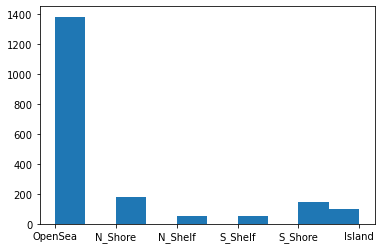

In [3]:
data=pd.read_csv('data/MotifPipeline/sthlm_motif_50_QCbeta/red/SKNSH_ZNF232',sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval',"hits1",'W1','array','region','ChIPTF','gene'])
n=plt.hist(data['region'])


### Fig 3

In [49]:
# t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
def ttest_plot_region(allboxxx,datatype,regions=[]):

    allbox=allboxxx[allboxxx['data']==datatype]
    # allbox=allbox[allbox['data']=='wg']
    # allbox=allbox[allbox['data']=='me']
    aa=allbox[allbox['region']=='OpenSea']
    bb=allbox[allbox['region']=='N_Shelf']
    cc=allbox[allbox['region']=='N_Shore']
    dd=allbox[allbox['region']=='Island']
    ee=allbox[allbox['region']=='S_Shore']
    ff=allbox[allbox['region']=='S_Shelf']



    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())

    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())

    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())

    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())

    # initialise data of lists. 
    ttest = {'OpenSea ttest':[t0a,t0b,t1a,t1b,t2a,1], 
             'N_Shelf ttest':[t2b,t3a,t3b,t4a,1,0],
            'N_Shore ttest':[t4b,t5a,t5b,1,0,0],
            'Island ttest':[t6a,t6b,1,0,0,0],
            'S_Shore ttest':[t7a,1,0,0,0,0],
            'S_Shelf ttest':[1,0,0,0,0,0]}

    pval = {'OpenSea pval':[p0a,p0b,p1a,p1b,p2a,1], 
             'N_Shelf pval':[p2b,p3a,p3b,p4a,1,0],
            'N_Shore pval':[p4b,p5a,p5b,1,0,0],
            'Island pval':[p6a,p6b,1,0,0,0],
            'S_Shore pval':[p7a,1,0,0,0,0],
            'S_Shelf pval':[1,0,0,0,0,0]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['S_Shelf','S_Shore', 'Island',  'N_Shore','N_Shelf','OpenSea']) 
    df_pval = pd.DataFrame(pval, index =['S_Shelf','S_Shore', 'Island',  'N_Shore','N_Shelf','OpenSea']) 

    # df_ttest = pd.DataFrame(ttest, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    # df_pval = pd.DataFrame(pval, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm


### Fig ST2

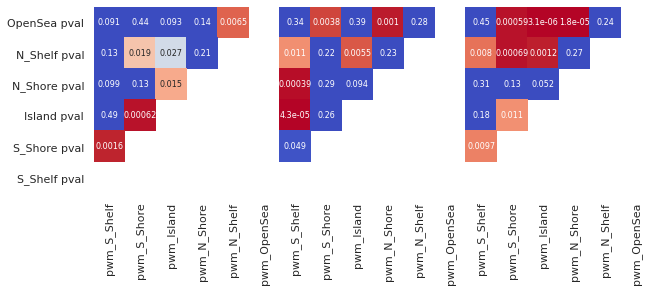

In [50]:
df_pval_pwm=ttest_plot_region(allboxxx,'pwm')
df_pval_wg=ttest_plot_region(allboxxx,'wg')
df_pval_me=ttest_plot_region(allboxxx,'me')

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:6,0:6],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T/2,annot=True,mask=mask.T,cbar=False,
                     vmax=.05, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

# FIg S6

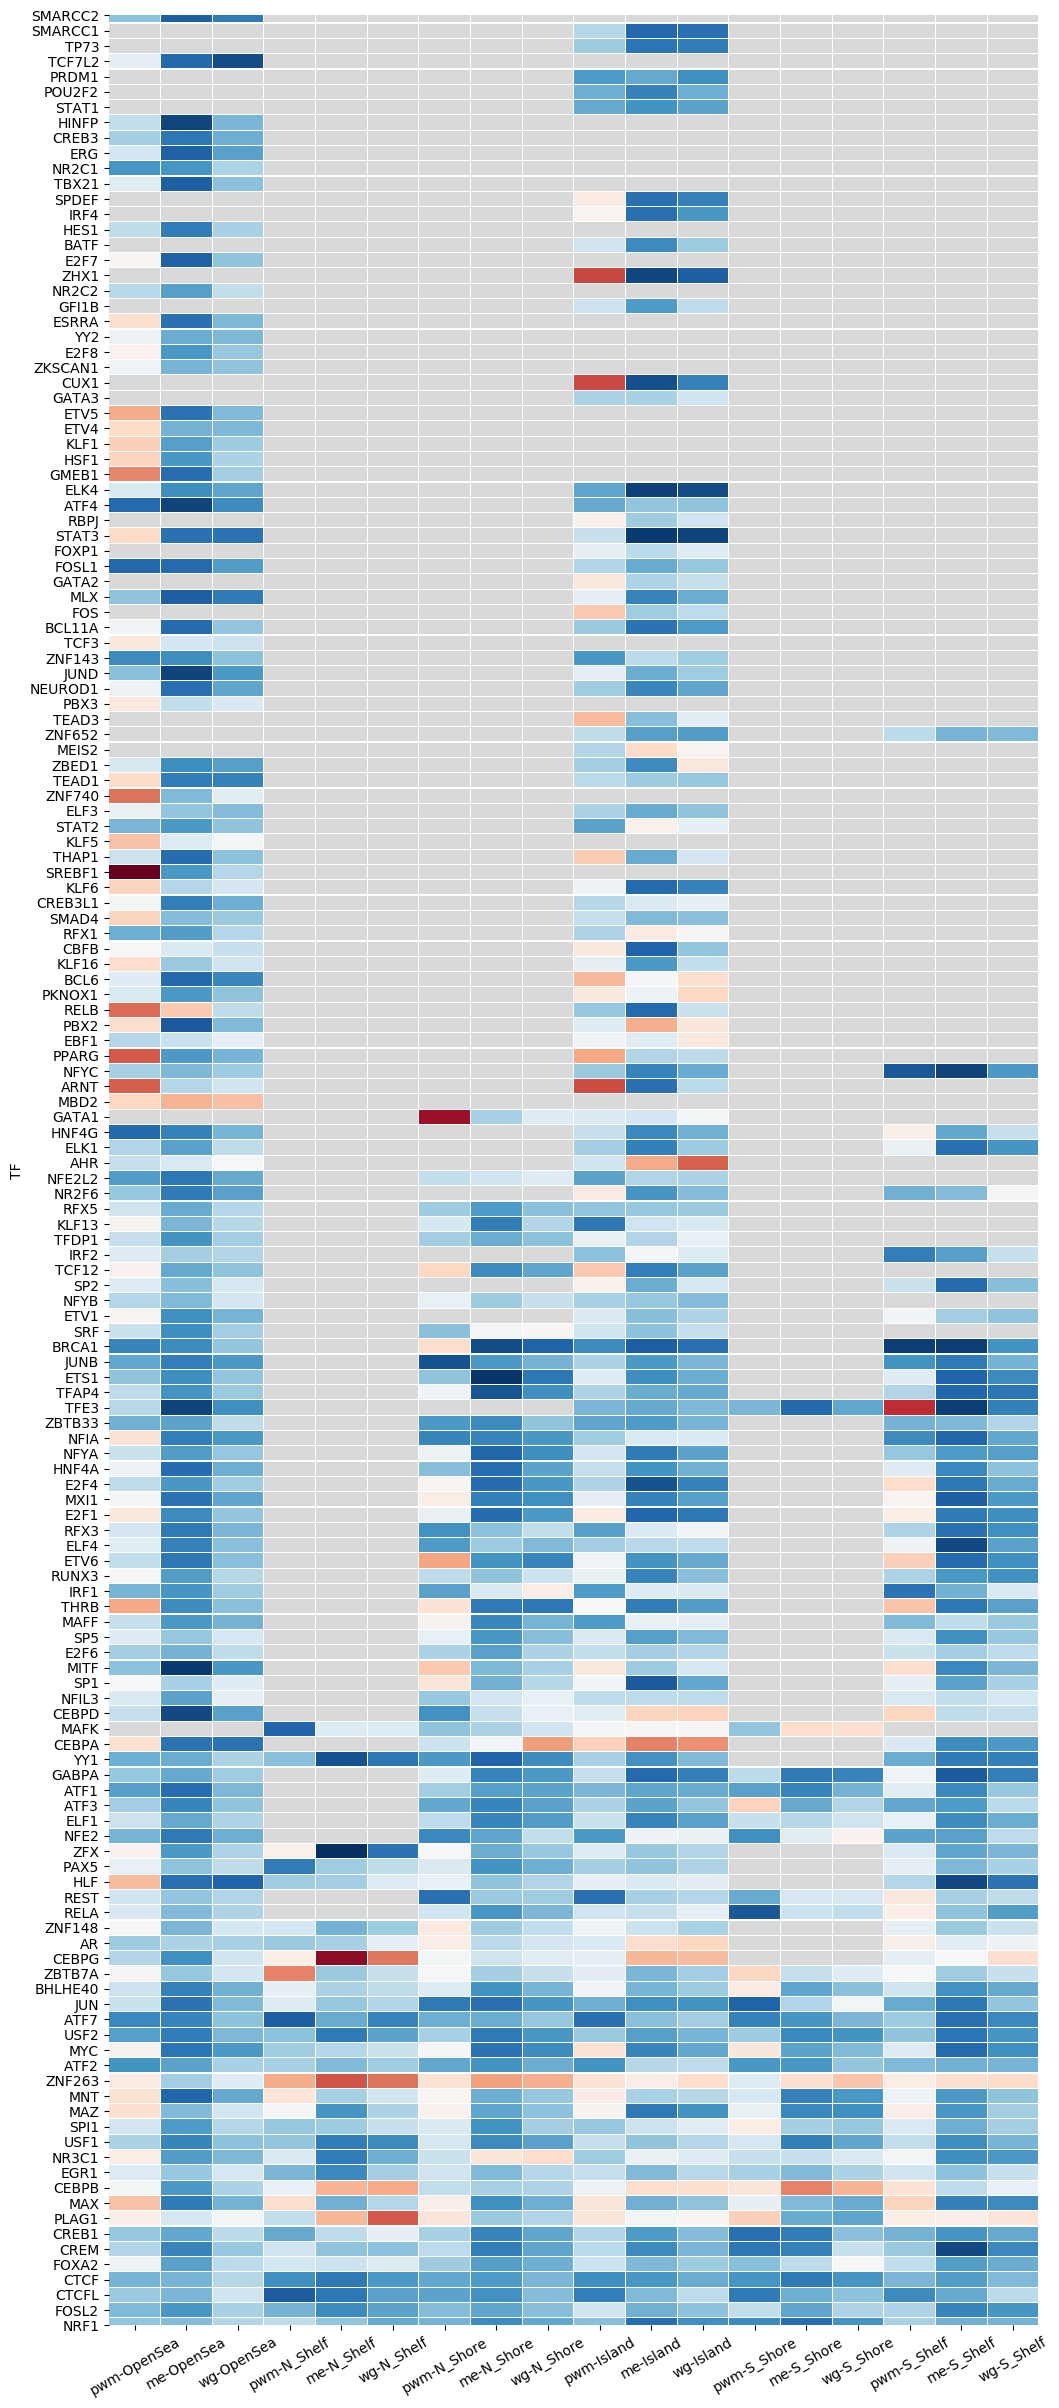

In [81]:
allbox=pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_PRE_overall' in s]
measure='auroc'

for jac in (indices):
    trace=traces[jac]
    aurocs=pd.read_table(trace,sep=',',usecols=[1,2,3,4,5],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc'])#,'mo_aupr','wgbs_aupr','me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
    aurocs=aurocs[aurocs.cell!='0']
    aurocs['region']=(trace.split('/')[5])
    
#     if measure=='auroc':
#         aurocs.drop(['mo_aupr','wgbs_aupr','me_aupr','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc'],axis=1,inplace=True)
#     elif measure=='aupr':
#         aurocs.drop(['mo_auroc','wgbs_auroc','me_auroc','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr',],axis=1,inplace=True)

    allbox=pd.concat([allbox,aurocs],axis=0)
    ###PLOT
    # measure="wg_auroc"
    # measure='auroc'

    ##sum across cells and sort
allbox=allbox[allbox['region']!='all']
heat=allbox.pivot_table(index=['TF'], columns='region')
# heat=heat[[measure]]
heat['mean']=np.nanmean(heat,axis=1)
heat['count']=heat.isnull().sum(axis=1)
#     heat['count']=(21-heat['count'])
# heat=heat.sort_values(by=['count'],ascending=True)
# heat=heat.sort_values(by=['mean'],ascending=False)
heat['weight']=heat['mean']*(heat['count'])
heat=heat.sort_values(by=['weight'],ascending=False)
# heat=heat[heat.index.str.contains(pat='CEB')]

# heat=heat[heat['count']==5]
# heat=heat[heat['mean']<0.1]
# del heat.iloc[:,0]
heat=heat.dropna(axis=1, how='all')
del heat['count']
del heat['mean']
del heat['weight']
# heat['sum']=heat.isnull().sum(axis=0)
# heat=heat.sort_values(by=['sum'],ascending=True)
# del heat['sum']
heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','me-OpenSea','me-N_Shelf','me-N_Shore','me-Island','me-S_Shore','me-S_Shelf',
             'pwm-OpenSea','pwm-N_Shelf','pwm-N_Shore','pwm-Island','pwm-S_Shore','pwm-S_Shelf',
             'wg-OpenSea','wg-N_Shelf','wg-N_Shore','wg-Island','wg-S_Shore','wg-S_Shelf']

# heat=heat[['TF','pwm-OpenSea','pwm-N_Shelf','pwm-N_Shore','pwm-Island','pwm-S_Shore','pwm-S_Shelf',
#           'me-OpenSea','me-N_Shelf','me-N_Shore','me-Island','me-S_Shore','me-S_Shelf',
#              'wg-OpenSea','wg-N_Shelf','wg-N_Shore','wg-Island','wg-S_Shore','wg-S_Shelf']]


heat=heat[['TF','pwm-OpenSea','me-OpenSea','wg-OpenSea',
           'pwm-N_Shelf','me-N_Shelf','wg-N_Shelf',
           'pwm-N_Shore', 'me-N_Shore','wg-N_Shore',
           'pwm-Island','me-Island','wg-Island',
           'pwm-S_Shore','me-S_Shore','wg-S_Shore',
           'pwm-S_Shelf','me-S_Shelf','wg-S_Shelf']]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))
# grid_kws = {"height_ratios": (60,12), "hspace": .3}

# f, (ax, cbar_ax) = plt.subplots(2)#, gridspec_kw=grid_kws)
# rdgn = sns.diverging_palette(h_neg=200, h_pos=20, s=99, l=55, sep=3, as_cmap=True)
# rdgn=sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# rdgn=sns.color_palette("RdBu", 100)
rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)
# f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
g1 = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

# plt.imshow(heat, cmap='hot', interpolation='nearest')
# ax= sns.heatmap(heat, center=.5,cmap=rdgn,linewidth=.1)
# ax= sns.heatmap(heat, linewidth=.1,cmap="YlGnBu")

#     plt.savefig(outdir+"sthlm_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show

#     print([(heat55['pwm-OpenSea'].dropna().shape),(heat55['pwm-N_Shelf'].dropna().shape),(heat55['pwm-N_Shore'].dropna().shape),(heat55['pwm-Island'].dropna().shape),(heat55['pwm-S_Shore'].dropna().shape),(heat55['pwm-S_Shelf'].dropna().shape)])

box=heat55

### Fig S4B

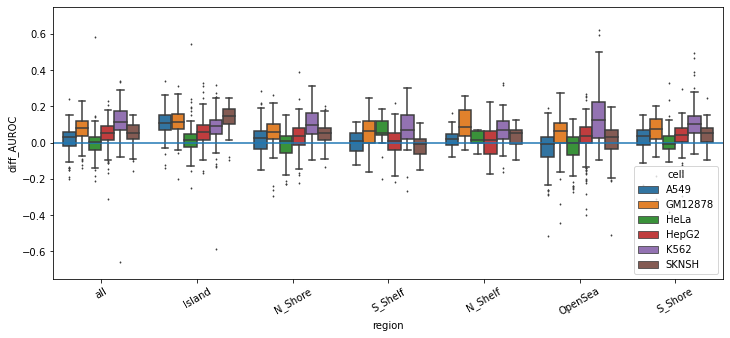

In [8]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='cell')
    
# allbox2=allbox[allbox['cell']==cell]
#     allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
# allbox2=allbox2.sort_values('data', axis=0)
aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
dd['diff_AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
dd['data']='me-wg'
dd['depth']=dd['depth_y']
dd['cell']=dd['cell_y']
allbox2=pd.concat([dd])
g=sns.boxplot(x='region',y='diff_AUROC', data=allbox2,hue='cell',fliersize=1)#.set(title = cell)
# g=sns.swarmplot(x='cell',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
plt.axhline(y=0, xmin=-1, xmax=6)

g.set(ylim=(-.75, .75))
#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

In [ ]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# it='me'
for cell in cells:
    allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='buffer')
#     allbox2=allbox[allbox['cell line']!='']
    allbox2=allbox2[allbox2['region']!='all']

    # allbox2=allbox2.sort_values('region', axis=0)

    aa=allbox2[allbox2['region']=='OpenSea']
    bb=allbox2[allbox2['region']=='N_Shelf']
    cc=allbox2[allbox2['region']=='N_Shore']
    dd=allbox2[allbox2['region']=='Island']
    ee=allbox2[allbox2['region']=='S_Shore']
    ff=allbox2[allbox2['region']=='S_Shelf']
    allbox2=pd.concat([aa,bb,cc,dd,ee,ff])

    aa=allbox2[allbox2['data']=='pwm']
    bb=allbox2[allbox2['data']=='wg']
    cc=allbox2[allbox2['data']=='me']
    allbox2=pd.concat([aa,bb,cc])

    g=sns.boxplot(x='region',y=method.upper(), data=allbox2,hue='data',palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])#
#     g=sns.swarmplot(x='region',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
    medians = allbox2.groupby(['region'])['AUROC'].median().values
    nobs = np.array([allbox2[(allbox2['region']=='OpenSea')]['AUROC'].dropna().shape[0],
allbox2[(allbox2['region']=='N_Shelf')]['AUROC'].dropna().shape[0],
allbox2[(allbox2['region']=='N_Shore')]['AUROC'].dropna().shape[0],
allbox2[(allbox2['region']=='Island')]['AUROC'].dropna().shape[0],
allbox2[(allbox2['region']=='S_Shore')]['AUROC'].dropna().shape[0],
allbox2[(allbox2['region']=='S_Shelf')]['AUROC'].dropna().shape[0]])
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        g.text(pos[tick], medians[tick] - 0.5, nobs[tick],
        horizontalalignment='center', size='medium', color='r', weight='semibold')
    g.set(ylim=(-0.1, 1.1))
    g.set(title = cell)
    #     plt.title=it
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

In [10]:
CGcont=pd.read_table('tmp1.txt',sep=' ',names=['CG','total','motif','gene'])
type(CGcont['CG'])
# CGcont['frac_CG']=CGcont['CG']/CGcont['total']
# CGcont=CGcont[CGcont['CG'] == int]

# cc=np.log10(CGcont[CGcont['CG']>0]['total'])
# plt.hist(cc,bins=50)
# plt.title(str(cc.shape)+' of 733 have some CGs')
# plt.xlabel('log CG count')
# plt.ylabel('frequency')

pandas.core.series.Series

Text(0, 0.5, 'frequency')

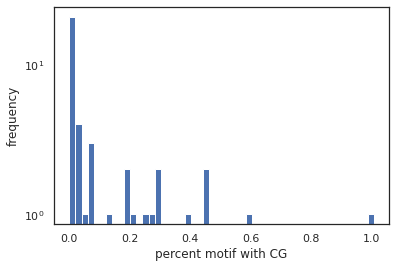

In [27]:
plt.hist(CGcont['CG']/CGcont['total'],bins=50,log=True)
plt.xlabel('percent motif with CG')
plt.ylabel('frequency')

## back to original cell line specific AUROC analysis

In [152]:
from mili_benchmark.predScore import predScore

RR,DD=predScore(indir,outdir,'mean',cell,TF,None,None)

In [60]:
CGcont=CGcont.sort_values(by=['CG_pre'],ascending=False)
# CGcont=CGcont.sort_values(by=['CG_pre'],ascending=True)


In [61]:
CGcont

CG   total  motif    gene    CG_pre
41   473006  473007  M0609   DNMT1  0.999998
213  473006  473007  M0609   DNMT1  0.999998
180  370391  370392  M0196   NPAS2  0.999997
512  328567  328568  M5634     MNT  0.999997
753  322546  322547  M6352    MYCN  0.999997
..      ...     ...    ...     ...       ...
72        0  431157  M0943     OTP  0.000000
19        0  317000  M0395  ZNF187  0.000000
574       0  370206  M5945    VAX2  0.000000
69        0  750254  M0931    LHX1  0.000000
818       0  607562  M6440   PRRX2  0.000000

[882 rows x 5 columns]

### Fig S5

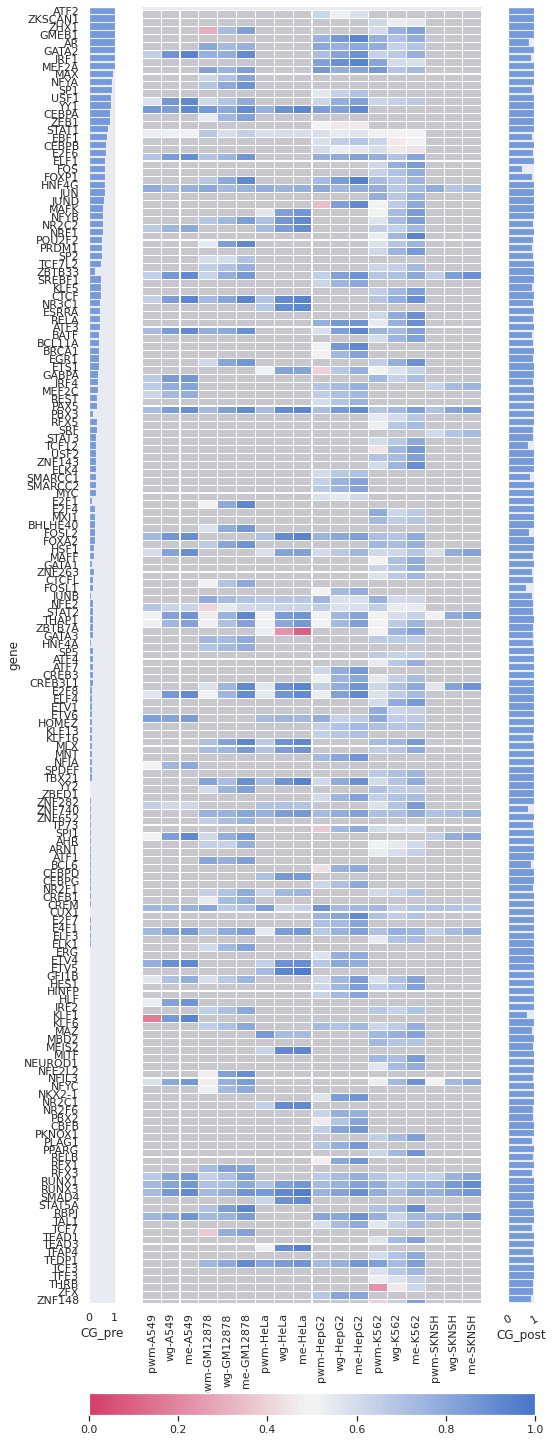

In [62]:
measure='auroc'
aurocs=pd.read_table('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/'+'all'+'/'+'all'+'/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,3,4,5,6,7,8,18,19,20,21,22,23,24,25,26,27],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc','mo_aupr','wgbs_aupr','me_aupr',
    'rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
aurocs=aurocs[aurocs.cell!='0']

###change second last label to factor wgbs >10 reads threshold remove wgbs_auroc rather than tr_wg_auroc
if measure=='auroc':
    aurocs.drop(['mo_aupr','wgbs_aupr','me_aupr','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc'],axis=1,inplace=True)
elif measure=='aupr':
    aurocs.drop(['mo_auroc','wgbs_auroc','me_auroc','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr',],axis=1,inplace=True)

CGcont=pd.read_table('data/MotifPipeline/total_CGandNonCont.txt',sep=' ',names=['CG','total','motif','gene'])
CGcont['CG_pre']=CGcont['CG']/CGcont['total']
CGcont=CGcont[CGcont.CG_pre<=1]

CGcont2=pd.read_table('data/MotifPipeline/CGcont.txt',sep=' ',names=['CG','total','motif','gene'])
CGcont2['CG_post']=CGcont2['CG']/CGcont2['total']
###PLOT
# measure="wg_auroc"
# measure='auroc'

##sum across cells and sort
heat=aurocs.pivot_table(index=['TF'], columns='cell')
# heat=heat[[measure]]
# heat['mean']=np.nanmean(heat,axis=1)
# heat['count']=heat.isnull().sum(axis=1)
# heat['count']=(21-heat['count'])
# heat=heat.sort_values(by=['count'],ascending=True)
# heat=heat.sort_values(by=['mean'],ascending=False)
# heat['weight']=heat['mean']*(heat['count'])
# heat=heat.sort_values(by=['weight'],ascending=False)
# heat=heat[heat.index.str.contains(pat='CEB')]

# heat=heat[heat['count']==5]
# heat=heat[heat['mean']<0.1]
# del heat.iloc[:,0]
heat=heat.dropna(axis=1, how='all')
# del heat['count']
# del heat['mean']
# del heat['weight']
# heat['sum']=heat.isnull().sum(axis=0)
# heat=heat.sort_values(by=['sum'],ascending=True)
# del heat['sum']
heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
             'pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
             'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']

# heat=heat[['TF','pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
#           'me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
#              'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']]


heat=heat[['TF','pwm-A549','wg-A549','me-A549',
           'pwm-GM12878','wg-GM12878','me-GM12878',
           'pwm-HeLa', 'wg-HeLa','me-HeLa',
           'pwm-HepG2','wg-HepG2','me-HepG2',
           'pwm-K562','wg-K562','me-K562',
           'pwm-SKNSH','wg-SKNSH','me-SKNSH']]
heat55=heat
heat=heat.set_index('TF')
# heat.sort_values(by='pwm-A549',ascending=False,inplace=True)
# heat=heat.iloc[::-1]

# plt.figure(figsize=(8, 30))
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(8, 30),gridspec_kw={'width_ratios':[0.08,1,0.08]})
# grid_kws = {"height_ratios": (60,12), "hspace": .3}

# f, (ax, cbar_ax) = plt.subplots(2)#, gridspec_kw=grid_kws)
# rdgn = sns.diverging_palette(h_neg=200, h_pos=20, s=99, l=55, sep=3, as_cmap=True)
# rdgn=sns.diverging_palette(220, 20, sep=20, as_cmap=True)
rdgn=sns.diverging_palette(0.5, 255, sep=8, n=256,as_cmap=True)#sns.color_palette("RdBu",norm=DivergingNorm(0.5))

# offset=colors.DivergingNorm(vmin=0.0, vcenter=0.5, vmax=1.0)
# rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)

# im = ax1.imshow(heat, norm=DivergingNorm(0.5), cmap=rdgn, interpolation='none')
# fig.colorbar(im)
# rdgn.set_bad(color='red')

CGcont=CGcont.sort_values(by=['CG_pre'],ascending=False)
# CGcont['CG_pre']

g2 = sns.barplot(x='CG_pre',y='gene',color='cornflowerblue',data=CGcont[CGcont['gene'].isin(heat.index)].dropna(),ax=ax1,linewidth=.1,errwidth=0,capsize=0,ci=None)

# g2.xticks(rotation=30)
g1 = sns.heatmap(heat,linewidth=.1,cmap=rdgn, vmin=0, vmax=1,cbar=False,mask=heat.isnull(),yticklabels=True,ax=ax2)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
g1.set(ylabel=None)
# for p in g2.patches:
#     height = p.get_height()
#     g2.text(p.get_x()+p.get_width()/2.,
#             height + 3,
#             '{:1.2f}'.format(height),
#             ha="center") 
# plt.show

g3 = sns.barplot(x='CG_post',y='gene',color='cornflowerblue',data=CGcont2[CGcont2['gene'].isin(heat.index)].dropna(),ax=ax3,linewidth=.1,errwidth=0,capsize=0,ci=None)
g3.set(ylabel=None)
# g3.xticks(rotation=30)
# for p in g3.patches:
#     height = p.get_height()
#     g3.text(p.get_x()+p.get_width()/2.,
#             height + 3,
#             '{:1.2f}'.format(height),
#             ha="center") 
# plt.show

mappable = g1.get_children()[0]
plt.colorbar(mappable, ax = [g2,g1,g3],orientation = 'horizontal',pad=.055) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

# for ax in [g1,g2,g3]:
#     tl = ax.get_xticklabels()
#     ax.set_xticklabels(tl, rotation=30)
#     tly = ax.get_yticklabels()
#     ax.set_yticklabels(tly, rotation=0)

# plt.imshow(heat, cmap='hot', interpolation='nearest')
# ax= sns.heatmap(heat, center=.5,cmap=rdgn,linewidth=.1)
# ax= sns.heatmap(heat, linewidth=.1,cmap="YlGnBu")

# plt.savefig(outdir+"camb_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show()

# print([(heat55['pwm-A549'].dropna().shape),(heat55['pwm-GM12878'].dropna().shape),(heat55['pwm-HeLa'].dropna().shape),(heat55['pwm-HepG2'].dropna().shape),(heat55['pwm-K562'].dropna().shape),(heat55['pwm-SKNSH'].dropna().shape)])

box=heat55
# box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
meltbox=pd.melt(box,id_vars=['TF'])
# # del box.TF
# if measure=='auroc':
#     meltbox.columns=['TF','data - cell line','AUROC']
#     plt.figure(figsize=(18, 5))
#     plt.xticks(rotation=30)
#     g=sns.boxplot(x='data - cell line',y='AUROC', data=meltbox)
#     g=sns.swarmplot(x='data - cell line',y='AUROC', data=meltbox,
#                   size=2, color=".3", linewidth=0)
# elif measure=='aupr':
#     meltbox.columns=['TF','data - cell line','AUPR']
#     plt.figure(figsize=(12, 5))
#     plt.xticks(rotation=30)
#     g=sns.boxplot(x='data - cell line',y='AUPR', data=meltbox)
#     g=sns.swarmplot(x='data - cell line',y='AUPR', data=meltbox,
#                   size=2, color=".3", linewidth=0)
# g.set(ylim=(0, 1))
# plt.savefig(outdir+"sthlm_"+measure+"_box.png",dpi=300,bbox_inches = "tight")
# # meltbox.to_csv(outdir+measure+"meltbox.txt")

# plt.show
# # Tweak the visual presentation
# # ax.xaxis.grid(True)
# # ax.set(ylabel="")
# sns.despine(trim=True, left=True)

### Fig 2

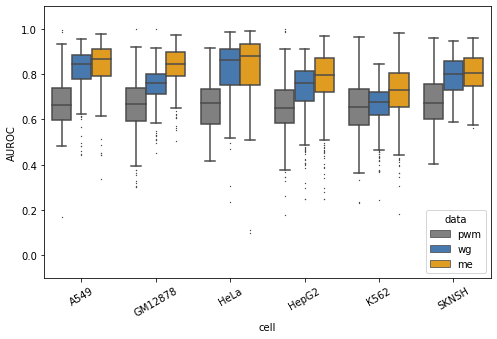

In [10]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# allbox=allbox[allbox['depth'].astype(np.int64)>10]
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(8, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='cell')
    
# allbox2=allbox[allbox['cell']==cell]
#     allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
# allbox2=allbox2.sort_values('data', axis=0)
aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
allbox2=pd.concat([aa,bb,cc])
g=sns.boxplot(x='cell',y=method.upper(), data=allbox2,hue='data',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])#.set(title = cell)
# g=sns.swarmplot(x='cell',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
g.set(ylim=(-0.1, 1.1))

# x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
# y, h, col = allbox2['AUROC'].max() , .1, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

## Fig 5

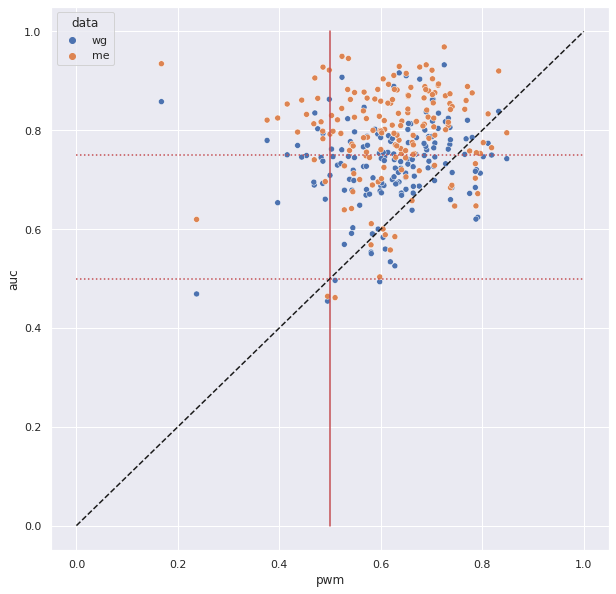

In [66]:
pwmmm=np.mean(heat[heat.columns[heat.columns.str.contains('pwm')]],axis=1)
wgbsss=np.mean(heat[heat.columns[heat.columns.str.contains('wg')]],axis=1)
meee=np.mean(heat[heat.columns[heat.columns.str.contains('me')]],axis=1)
invData=pd.DataFrame([pwmmm,wgbsss,meee]).transpose()
invData.columns=['pwm','wg','me']

plt.figure(figsize=(10, 10))
# fig, ax = plt.subplots()
invData['TF']=invData.index
invData2=pd.melt(invData,id_vars=['TF','pwm'])
invData2.columns=['TF','pwm','data','auc']
sns.scatterplot(
    data=invData2, x="pwm", y='auc', hue='data',# size="diff",
    sizes=(200, 200), legend='full'
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r:')
# ax.fill_between(.5*invData2.auc, [0.5],1, alpha=0.2)

### all wgbs reads

In [17]:
pwm_med = aa.groupby(['cell'])[method.upper()].median()
wg_med = bb.groupby(['cell'])[method.upper()].median()
me_med = cc.groupby(['cell'])[method.upper()].median()
[np.round(pwm_med-wg_med,4),np.round(pwm_med-me_med,4)]

[cell
 A549      -0.1821
 GM12878   -0.0906
 HeLa      -0.1901
 HepG2     -0.1083
 K562      -0.0214
 SKNSH     -0.1303
 Name: AUROC, dtype: float64,
 cell
 A549      -0.2044
 GM12878   -0.1781
 HeLa      -0.2075
 HepG2     -0.1458
 K562      -0.0770
 SKNSH     -0.1332
 Name: AUROC, dtype: float64]

### WGBS read > 10

In [15]:
pwm_med = aa.groupby(['cell'])[method.upper()].median()
wg_med = bb.groupby(['cell'])[method.upper()].median()
me_med = cc.groupby(['cell'])[method.upper()].median()
[np.round(pwm_med-wg_med,4),np.round(pwm_med-me_med,4)]

[cell
 A549      -0.1818
 GM12878   -0.0816
 HeLa      -0.1863
 HepG2     -0.0901
 K562       0.0250
 SKNSH     -0.1442
 Name: AUROC, dtype: float64,
 cell
 A549      -0.1951
 GM12878   -0.1733
 HeLa      -0.2012
 HepG2     -0.1039
 K562      -0.0158
 SKNSH     -0.1287
 Name: AUROC, dtype: float64]

In [ ]:
pwmmm=np.mean(heat[heat.columns[heat.columns.str.contains('pwm')]],axis=1)
wgbsss=np.mean(heat[heat.columns[heat.columns.str.contains('wg')]],axis=1)
meee=np.mean(heat[heat.columns[heat.columns.str.contains('me')]],axis=1)
heat2=np.transpose([wgbsss-pwmmm,meee-wgbsss])
heat2=pd.DataFrame(heat2,columns=['wg-pwm','me-pwm'],index=heat.index)
plt.figure(figsize=(3, 30))
heat3=heat2['me-pwm']
# del heat2['me-pwm']
# heat4['mean']=np.mean([heat4['wg-pwm'],heat4['me-pwm']],axis=0)
heat2=heat2.sort_index()#(by=heat2.index,ascending=False)
ax = sns.heatmap(heat2,linewidth=.1,center=0,cmap='RdBu',yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
plt.xticks(rotation=30)


In [ ]:
heat3=pd.DataFrame(heat3)
heat3=heat3.sort_values(by=['me-pwm'],ascending=False)
plt.figure(figsize=(.5, 30))
ax = sns.heatmap(heat3,linewidth=.1,center=0,cmap='RdBu',yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
plt.xticks(rotation=30)

### subset performing worse than PWM

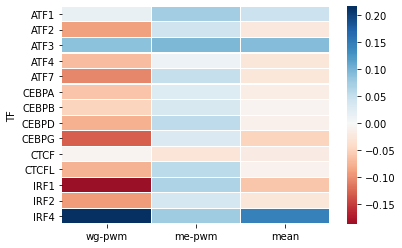

In [246]:
heat4=heat2[(heat2.index.str.contains('IRF'))|(heat2.index.str.contains('CTCF'))|
      (heat2.index.str.contains('ATF'))|(heat2.index.str.contains('CEB'))]
heat4=heat4[(heat4.index.str.contains('BATF'))==False]
heat4['mean']=np.mean([heat4['wg-pwm'],heat4['me-pwm']],axis=0)
heat4
ax = sns.heatmap(heat4,linewidth=.1,center=0,cmap='RdBu',yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})


In [327]:
# heat3=heat[(heat.index.str.contains('IRF'))|(heat.index.str.contains('CTCF'))|
#       (heat.index.str.contains('ATF'))|(heat.index.str.contains('CEB'))]
# heat4=heat4[(heat4.index.str.contains('BATF'))==False]
# heat4['mean']=np.mean([heat4['wg-pwm'],heat4['me-pwm']],axis=0)
# heat4
# ax = sns.heatmap(heat4,linewidth=.1,center=0,cmap='RdBu',yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
# heat3
pwmmm=np.mean(heat[heat.columns[heat.columns.str.contains('pwm')]],axis=1)
wgbsss=np.mean(heat[heat.columns[heat.columns.str.contains('wg')]],axis=1)
meee=np.mean(heat[heat.columns[heat.columns.str.contains('me')]],axis=1)
invData=pd.DataFrame([pwmmm,wgbsss,meee]).transpose()
invData.columns=['pwm','wg','me']
subinv=invData[invData['me']<.5]
subinv=subinv[subinv['pwm']>.4]
subinv


pwm        wg        me
TF                                 
CEBPA  0.495076  0.434386  0.464085
MBD2   0.509902  0.623388  0.461302

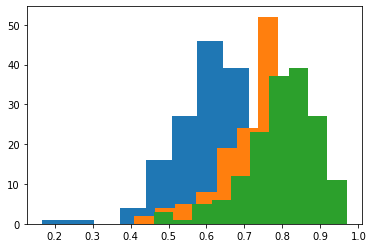

In [328]:
a=plt.hist(invData['pwm'])
b=plt.hist(invData['wg'])
c=plt.hist(invData['me'])

In [329]:
[invData[invData['pwm']<.4] , 
 invData[invData['wg']<.5] ,
 invData[invData['me']<.5] ]

[             pwm        wg        me
 TF                                  
 ZEB1    0.375837  0.878994  0.820513
 SREBF1  0.167489  0.914130  0.934581
 ZNF740  0.396693  0.758353  0.824766
 ZNF282  0.236812  0.493268  0.619583,
              pwm        wg        me
 TF                                  
 AHR     0.627718  0.409683  0.584687
 CEBPA   0.495076  0.434386  0.464085
 ZNF282  0.236812  0.493268  0.619583
 CEBPG   0.597839  0.469946  0.503230,
             pwm        wg        me
 TF                                 
 CEBPA  0.495076  0.434386  0.464085
 MBD2   0.509902  0.623388  0.461302]

# which data has largest overall signal

In [32]:
invData[sP]=invData[invData['pwm']]-.5
invData[sW]=invData[invData['wg']]-.5
invData[sA]=invData[invData['wA']]-.5

NameError: name 'invData' is not defined

In [ ]:
a=plt.hist(invData['sP'])
b=plt.hist(invData['sW'])
c=plt.hist(invData['sA'])

<AxesSubplot:xlabel='pwm', ylabel='auc'>

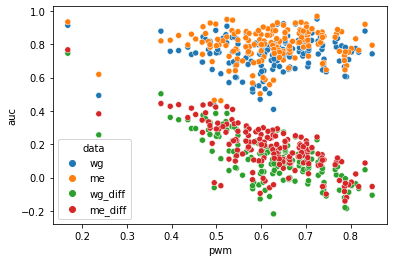

In [351]:
# invData['methyl-mean']=np.nanmean([invData['me'],invData['me']],axis=0)
# invData['wg_diff']=invData['wg']-invData['pwm']
# invData['me_diff']=invData['me']-invData['pwm']
invData['TF']=invData.index
invData2=pd.melt(invData,id_vars=['TF','pwm'])
invData2.columns=['TF','pwm','data','auc']
sns.scatterplot(
    data=invData2, x="pwm", y='auc', hue='data',# size="diff",
    sizes=(200, 200), legend='full'
)
# # invData

In [362]:

invData=pd.DataFrame([pwmmm,wgbsss,meee]).transpose()
invData.columns=['pwm','wg','me']
invData['TF']=invData.index
invData2=pd.melt(invData,id_vars=['TF','pwm'])
invData2.columns=['TF','pwm','data','auc']

fig = px.scatter(invData2, x="pwm", y="auc",
    color="data",
    hover_name="TF")#, log_x=True, size_max=60)
fig.show()

In [6]:
chA549=pd.read_csv('data/MotifPipeline/remap/remap_TFcell.txt',sep=':',names=['TF','cell'])


In [ ]:
# chA549['TF']=(chA549['TF:cell'].str.split(':').str[0].tolist())
# chA549['cell']=(chA549['TF:cell'].str.split(':').str[1].tolist())

In [31]:
sub=chA549[(chA549['cell']=='A-549')|
           (chA549['cell']=='GM12878')|
           (chA549['cell']=='Hep-G2')|
           (chA549['cell']=='HeLa')|
            (chA549['cell']=='K-562')|
            (chA549['cell']=='SK-N-SH')]



In [33]:
pd.unique(sub.cell)

array(['GM12878', 'K-562', 'A-549', 'Hep-G2', 'HeLa', 'SK-N-SH'],
      dtype=object)

In [38]:
remap=sub.groupby(sub.columns.tolist(),as_index=False).size()

In [49]:
reA549=chA549[chA549['cell']=='A-549']
reA549=reA549.groupby(reA549.columns.tolist(),as_index=False).size()

reGM12878=chA549[chA549['cell']=='GM12878']
reGM12878=reGM12878.groupby(reGM12878.columns.tolist(),as_index=False).size()

reHepG2=chA549[chA549['cell']=='Hep-G2']
reHepG2=reHepG2.groupby(reHepG2.columns.tolist(),as_index=False).size()

reHeLa=chA549[chA549['cell']=='HeLa']
reHeLa=reHeLa.groupby(reHeLa.columns.tolist(),as_index=False).size()

reK562=chA549[chA549['cell']=='K-562']
reK562=reK562.groupby(reK562.columns.tolist(),as_index=False).size()

reSKNSH=chA549[chA549['cell']=='SK-N-SH']
reSKNSH=reSKNSH.groupby(reSKNSH.columns.tolist(),as_index=False).size()


[Text(0, 0.5, 'count'), Text(0.5, 0, 'log10 TF reads')]

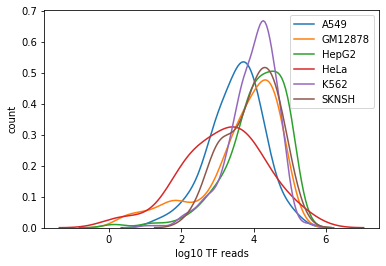

In [69]:
y=sns.distplot(np.log10(reA549),hist=None,kde_kws={"label":'A549'})
y=sns.distplot(np.log10(reGM12878),hist=None,kde_kws={"label":'GM12878'})
y=sns.distplot(np.log10(reHepG2),hist=None,kde_kws={"label":'HepG2'})
y=sns.distplot(np.log10(reHeLa),hist=None,kde_kws={"label":'HeLa'})
y=sns.distplot(np.log10(reK562),hist=None,kde_kws={"label":'K562'})
y=sns.distplot(np.log10(reSKNSH),hist=None,kde_kws={"label":'SKNSH'})
y.set(xlabel='log10 TF reads', ylabel='count')





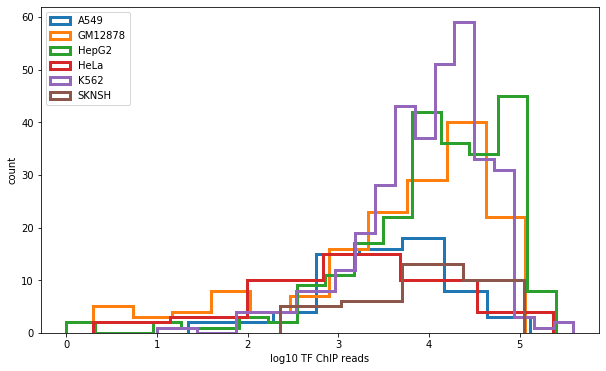

In [86]:
plt.figure(figsize=(10, 6))
x=sns.distplot(np.log10(reA549),kde=0,label='A549',
             hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
x=sns.distplot(np.log10(reGM12878),kde=0,label='GM12878',hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
x=sns.distplot(np.log10(reHepG2),kde=0,label='HepG2',hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
x=sns.distplot(np.log10(reHeLa),kde=0,label='HeLa',hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
x=sns.distplot(np.log10(reK562),kde=0,label='K562',hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})
x=sns.distplot(np.log10(reSKNSH),kde=0,label='SKNSH',hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1})

x.set(xlabel='log10 TF ChIP reads', ylabel='count')
plt.legend(loc='upper left')


## read depth analysis

In [ ]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)

# plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox=allbox.sort_values('depth', axis=0)
for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='buffer')
#     plt.figure(figsize=(8, 5))
    allbox2=allbox[allbox['cell']==cell]
    allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
    aa=allbox2[allbox2['data']=='pwm']
    bb=allbox2[allbox2['data']=='wg']
    cc=allbox2[allbox2['data']=='me']
#     dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
#     dd['AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
#     dd['data']='me-wg'
#     dd['depth']=dd['depth_y']
    allbox2=pd.concat([aa,bb,cc])
#     cc=allbox2[allbox2['data']=='me']
#     allbox2=pd.concat([aa,bb])
#     allbox3['diff_auroc']=aa[method.upper()]-bb[method.upper()]
#     allbox3['depth']=allbox2['depth'][allbox2['data']=='wg']
#     allbox2=allbox2.sort_values('data', axis=0)

    ax=sns.boxplot(x='depth',y=method.upper(), data=allbox2,hue='data',palette=['grey',sns.xkcd_rgb["windows blue"],'orange','deeppink'])#,fliersize=1,meanline=True)
    medians = allbox2.groupby(['depth'])['AUROC'].median().values
    nobs = np.array([allbox2[(allbox2['depth']==0)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==5)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==10)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==15)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==20)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==30)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==50)]['AUROC'].dropna().shape[0]])
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] - 0.5, nobs[tick],
        horizontalalignment='center', size='medium', color='r', weight='semibold')
    # g=sns.swarmplot(x='depth',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
    ax.set(ylim=(-0.5, 1.1))
    ax.set(title = cell)
    #     plt.title=it
    #     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

In [918]:
np.array([allbox2[(allbox2['depth']==0)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==5)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==10)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==15)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==20)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==30)]['AUROC'].dropna().shape[0],
allbox2[(allbox2['depth']==50)]['AUROC'].dropna().shape[0]])

array([24, 24, 24, 24, 24, 24, 15])

### SM3

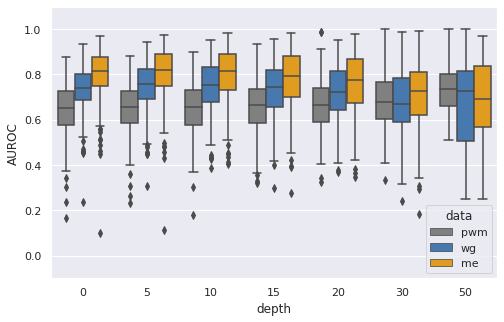

In [54]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)

# plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox=allbox.sort_values('depth', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='buffer')
plt.figure(figsize=(8, 5))
allbox2=allbox
# allbox2=allbox[allbox['cell']==cell]
# allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
#     dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
#     dd['AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
#     dd['data']='me-wg'
#     dd['depth']=dd['depth_y']
allbox2=pd.concat([aa,bb,cc])
#     cc=allbox2[allbox2['data']=='me']
#     allbox2=pd.concat([aa,bb])
#     allbox3['diff_auroc']=aa[method.upper()]-bb[method.upper()]
#     allbox3['depth']=allbox2['depth'][allbox2['data']=='wg']
#     allbox2=allbox2.sort_values('data', axis=0)

g=sns.boxplot(x='depth',y=method.upper(), data=allbox2,hue='data',palette=['grey',sns.xkcd_rgb["windows blue"],'orange','deeppink'])
# g=sns.swarmplot(x='depth',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
g.set(ylim=(-0.1, 1.1))
# g.set(title = cell)
#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()
allboxxx=allbox
#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

In [55]:
def ttest_plot_depth(allboxxx,datatype,regions=[]):

    allbox=allboxxx[allboxxx['data']==datatype]
    # allbox=allbox[allbox['data']=='wg']
    # allbox=allbox[allbox['data']=='me']
    aa=allbox[allbox['depth']==0]
    bb=allbox[allbox['depth']==5]
    cc=allbox[allbox['depth']==10]
    dd=allbox[allbox['depth']==15]
    ee=allbox[allbox['depth']==20]
    ff=allbox[allbox['depth']==30]
    gg=allbox[allbox['depth']==50]



    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())
    t2aa, p2aa = stats.ttest_ind(aa['AUROC'].dropna(),gg['AUROC'].dropna())


    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())
    t4aa, p4aa = stats.ttest_ind(bb['AUROC'].dropna(),gg['AUROC'].dropna())


    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())
    t5bb, p5bb = stats.ttest_ind(cc['AUROC'].dropna(),gg['AUROC'].dropna())


    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())
    t6bb, p6bb = stats.ttest_ind(dd['AUROC'].dropna(),gg['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())
    t7aa, p7aa = stats.ttest_ind(ee['AUROC'].dropna(),gg['AUROC'].dropna())

    t8a, p8a = stats.ttest_ind(ee['AUROC'].dropna(),gg['AUROC'].dropna())


    # initialise data of lists. 
    ttest = {'0 ttest':[t0a,t0b,t1a,t1b,t2a,t2aa,1], 
             '5 ttest':[t2b,t3a,t3b,t4a,t4aa,1,0],
            '10 ttest':[t4b,t5a,t5b,t5bb,1,0,0],
            '15 ttest':[t6a,t6b,t6bb,1,0,0,0],
            '20 ttest':[t7a,t7aa,1,0,0,0,0],
            '30 ttest':[t8a,1,0,0,0,0,0],
            '50 ttest':[1,0,0,0,0,0,0]}

    pval = {'0 pval':[p0a,p0b,p1a,p1b,p2a,p2aa,1], 
             '5 pval':[p2b,p3a,p3b,p4a,p4aa,1,0],
            '10 pval':[p4b,p5a,p5b,p5bb,1,0,0],
            '15 pval':[p6a,p6b,p6bb,1,0,0,0],
            '20 pval':[p7a,p7aa,1,0,0,0,0],
            '30 pval':[p8a,1,0,0,0,0,0],
            '50 pval':[1,0,0,0,0,0,0]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['50','30', '20',  '15','10','5','0']) 
    df_pval = pd.DataFrame(pval, index =['50','30', '20',  '15','10','5','0']) 

    # df_ttest = pd.DataFrame(ttest, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    # df_pval = pd.DataFrame(pval, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm

### ST3

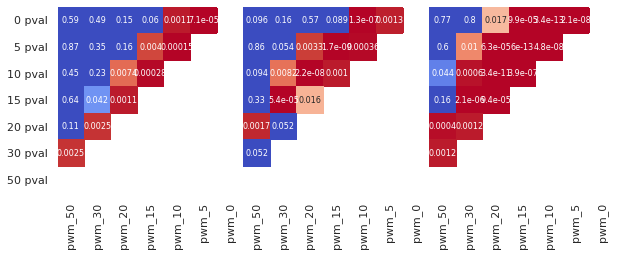

In [63]:
df_pval_pwm=ttest_plot_depth(allboxxx,'pwm')
df_pval_wg=ttest_plot_depth(allboxxx,'wg')
df_pval_me=ttest_plot_depth(allboxxx,'me')

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:7,0:7],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T,annot=True,mask=mask.T,cbar=False,
                     vmax=.05, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

In [416]:
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
# plt.figure(figsize=(12, 5))
# plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox=allbox.sort_values('depth', axis=0)

In [ ]:
# aa=allbox[(allbox['data']=='pwm')&(allbox['cell']=='A549')]
# len((allbox[(allbox['data']=='pwm')&(allbox['cell']=='SKNSH')]['TF']))
# bb=allbox[(allbox['data']=='wg')&(allbox['cell']=='A549')]
# pd.DataFrame(aa['AUROC']-bb['AUROC']).dropna()
# bb.dropna()
# allbox=allbox[allbox['cell']=='A549']
cells=np.sort((pd.unique(allbox['cell'])).tolist())
# for cell in cells:
allbox2=allbox[allbox['cell']==cell]
allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
allbox2['merge']=allbox2['TF']+'_'+allbox2['depth'].astype('str')+allbox2['cell']
aa=allbox2[allbox2['data']=='wg']
bb=allbox2[allbox2['data']=='pwm']
cc=aa.merge(bb,left_on='merge',right_on='merge')
cc['diff_AUROC']=cc['AUROC_x']-cc['AUROC_y']
g=sns.boxplot(x='depth_x',y='diff_AUROC', hue=cell,data=cc).set(title = cell)
plt.show()

### Fig SM3

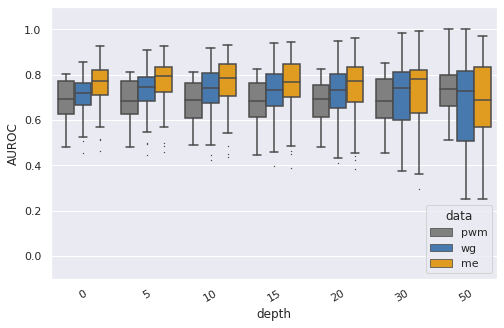

In [96]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(8, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox=allbox.sort_values('depth', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='buffer')
aa=allbox[allbox['data']=='pwm']
bb=allbox[allbox['data']=='wg']
cc=allbox[allbox['data']=='me']
allbox2=pd.concat([aa,bb,cc])
#     allbox2=allbox[allbox['cell']==cell]
allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
# allbox2=allbox2[allbox2['data']!='me']
#     allbox2=allbox2.sort_values('data', axis=0)

g=sns.boxplot(x='depth',y=method.upper(), data=allbox2,hue='data',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])#.set(title = cell)
# g=sns.swarmplot(x='depth',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
g.set(ylim=(-0.1, 1.1))
#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

In [ ]:
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/*',recursive = True)
for trace in (traces):
    data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval',"depth",'W1','array','region','ChIPTF','gene'])
    data5=data[data['depth']>5]
    data10=data[data['depth']>10]
    data20=data[data['depth']>20]
    data30=data[data['depth']>30]
    data50=data[data['depth']>50]
    print(os.path.basename(trace),[data5.shape,data10.shape,data20.shape,data30.shape,data50.shape])

### Fig S4D

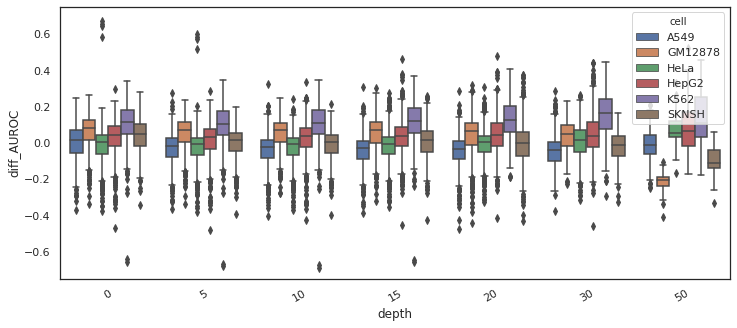

In [23]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='cell')
    
# allbox2=allbox[allbox['cell']==cell]
#     allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
# allbox2=allbox2.sort_values('data', axis=0)
aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
dd['diff_AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
dd['data']='me-wg'
dd['depth']=dd['depth_y']
dd['cell']=dd['cell_y']
allbox2=pd.concat([dd])
sns.set_style("white")
g=sns.boxplot(x='depth',y='diff_AUROC', data=allbox2,hue='cell')#.set(title = cell)
# g=sns.swarmplot(x='cell',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
g.set(ylim=(-.75, .75))
#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

### Fig S7

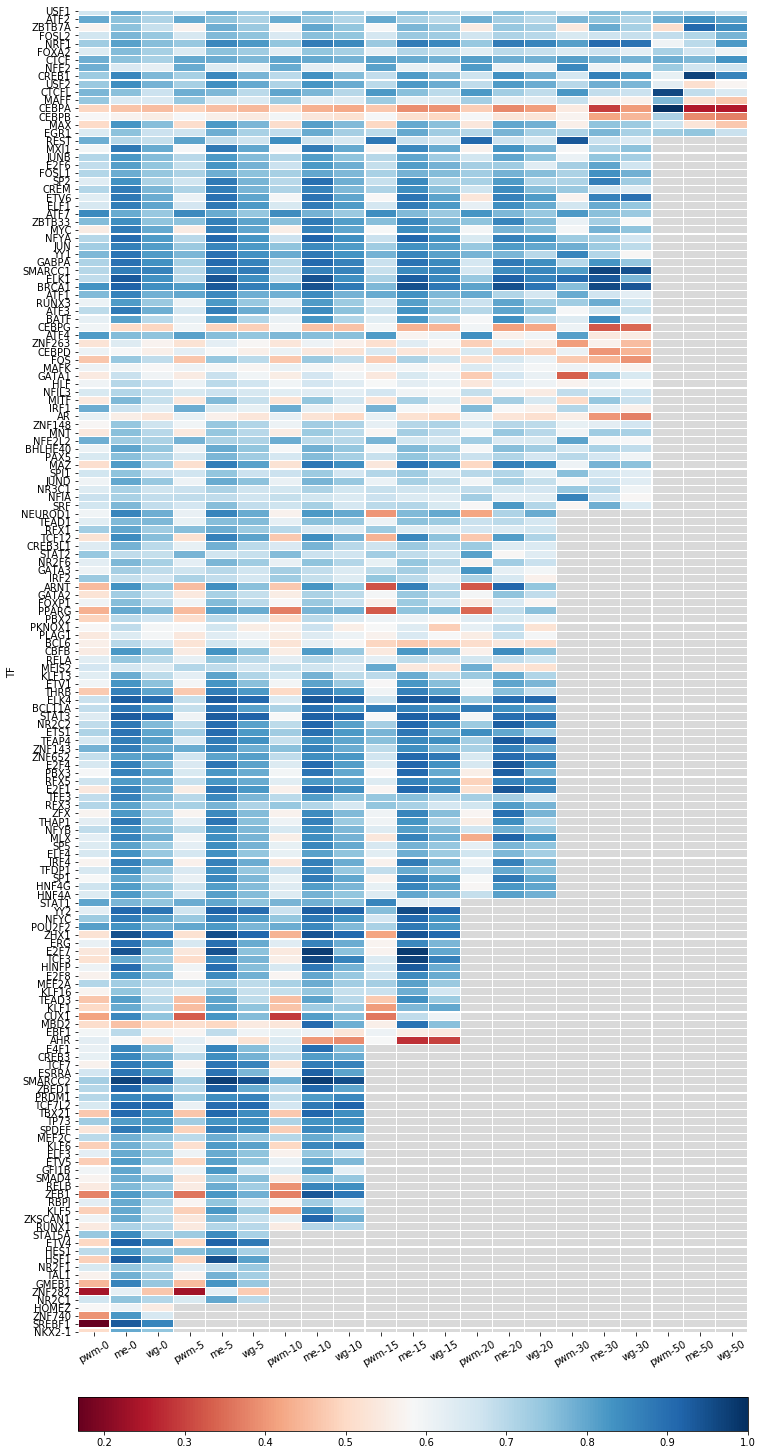

In [195]:
allbox=pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_PRE_overall' in s]
measure='auroc'

for jac in (indices):
    trace=traces[jac]
    aurocs=pd.read_table(trace,sep=',',usecols=[1,2,3,4,5],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc'])#,'mo_aupr','wgbs_aupr','me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
    aurocs=aurocs[aurocs.cell!='0']
    aurocs['depth']=(trace.split('/')[6])
    
#     if measure=='auroc':
#         aurocs.drop(['mo_aupr','wgbs_aupr','me_aupr','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc'],axis=1,inplace=True)
#     elif measure=='aupr':
#         aurocs.drop(['mo_auroc','wgbs_auroc','me_auroc','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr',],axis=1,inplace=True)

    allbox=pd.concat([allbox,aurocs],axis=0)
    ###PLOT
    # measure="wg_auroc"
    # measure='auroc'

    ##sum across cells and sort
# allbox=allbox[allbox['depth']!='all']
allbox['depth']=allbox['depth'].replace('all',0)
allbox.depth=allbox.depth.astype(int)
allbox=allbox.sort_values(by='depth')

heat=allbox.pivot_table(index=['TF'], columns='depth')
# heat=heat[[measure]]
heat['mean']=np.nanmean(heat,axis=1)
heat['count']=heat.isnull().sum(axis=1)
#     heat['count']=(21-heat['count'])
# heat=heat.sort_values(by=['count'],ascending=True)
# heat=heat.sort_values(by=['mean'],ascending=False)
heat['weight']=heat['mean']*(heat['count'])
heat=heat.sort_values(by=['weight'],ascending=False)
# heat=heat[heat.index.str.contains(pat='CEB')]

# heat=heat[heat['count']==5]
# heat=heat[heat['mean']<0.1]
# del heat.iloc[:,0]
# heat=heat.dropna(axis=1, how='all')
del heat['count']
del heat['mean']
del heat['weight']
heat['sum']=heat.isnull().sum(axis=1)
heat=heat.sort_values(by=['sum'],ascending=True)
del heat['sum']
heat=pd.DataFrame(heat.to_records())


heat.columns=['TF','me-0','me-5','me-10','me-15','me-20','me-30','me-50',
             'pwm-0','pwm-5','pwm-10','pwm-15','pwm-20','pwm-30','pwm-50',
             'wg-0','wg-5','wg-10','wg-15','wg-20','wg-30','wg-50']

# heat=heat[['TF','pwm-0','pwm-5','pwm-10','pwm-20','pwm-30','pwm-50',
#           'me-0','me-5','me-10','me-20','me-30','me-50',
#              'wg-0','wg-5','wg-10','wg-20','wg-30','wg-50']]


heat=heat[['TF','pwm-0','me-0','wg-0',
           'pwm-5','me-5','wg-5',
           'pwm-10', 'me-10','wg-10',
           'pwm-15', 'me-15','wg-15',
           'pwm-20','me-20','wg-20',
           'pwm-30','me-30','wg-30',
           'pwm-50','me-50','wg-50']]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))
# grid_kws = {"height_ratios": (60,12), "hspace": .3}

# f, (ax, cbar_ax) = plt.subplots(2)#, gridspec_kw=grid_kws)
# rdgn = sns.diverging_palette(h_neg=200, h_pos=20, s=99, l=55, sep=3, as_cmap=True)
# rdgn=sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# rdgn=sns.color_palette("RdBu", 100)
rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)
# rdgn.set_bad(color='red')

ax = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)
# plt.imshow(heat, cmap='hot', interpolation='nearest')
# ax= sns.heatmap(heat, center=.5,cmap=rdgn,linewidth=.1)
# ax= sns.heatmap(heat, linewidth=.1,cmap="YlGnBu")

#     plt.savefig(outdir+"sthlm_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show

#     print([(heat55['pwm-OpenSea'].dropna().shape),(heat55['pwm-N_Shelf'].dropna().shape),(heat55['pwm-N_Shore'].dropna().shape),(heat55['pwm-Island'].dropna().shape),(heat55['pwm-S_Shore'].dropna().shape),(heat55['pwm-S_Shelf'].dropna().shape)])

box=heat55

In [557]:
P=stats.f_oneway(box['pwm-0'].dropna(),box['pwm-5'].dropna(),box['pwm-10'].dropna(),box['pwm-20'].dropna(),box['pwm-30'].dropna(),box['pwm-50'].dropna())
W=stats.f_oneway(box['wg-0'].dropna(),box['wg-5'].dropna(),box['wg-10'].dropna(),box['wg-20'].dropna(),box['wg-30'].dropna(),box['wg-50'].dropna())
A=stats.f_oneway(box['me-0'].dropna(),box['me-5'].dropna(),box['me-10'].dropna(),box['me-20'].dropna(),box['me-30'].dropna(),box['me-50'].dropna())

[P,W,A]


[F_onewayResult(statistic=4.244071488394406, pvalue=0.0008401777965445997),
 F_onewayResult(statistic=8.486759389948162, pvalue=8.769273065900511e-08),
 F_onewayResult(statistic=10.645830192381577, pvalue=7.896820332242624e-10)]

## CG content analysis

### this script only intersect motif with ChiP

In [ ]:
! bash mili_benchmark/lbk_motif_pipeline_gamma.sh -b0 -c'A549 K562 GM12878 SKNSH HepG2 HeLa' -o'proj/remprs/rempr00/data/MotifPipeline/only_pwm'

In [89]:
allbox = pd.DataFrame()
dirr='../../d/tmp/redmo/camb_motif_ALL/'
# dirrA='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_gamma0/

# dirr2='../../d/tmp/redmo/camb_motif_ALL/'
# dirr2A='../../d/tmp/redmo/camb_motif/'
outdir='../../d/tmp/redmo/camb_motif/'
traces= glob.glob(dirr+'CG/'+'*',recursive = False)
# traces2= glob.glob(dirrA+'CG/'+'*',recursive = False)
# traces=traces+traces2
# traces= glob.glob(dirrA+'*',recursive = False)


# trace=traces[0]
for i,trace in enumerate(traces):
#     print(trace)
#     plt.subplot(2, 2, 3)
    combo=trace.split('/')[7]
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
    dataCG=pd.read_csv(trace,sep='\t',names=['pwm','ChIPTF'])

    dataCG.ChIPTF=dataCG.ChIPTF.replace(' ',0)
    dataCG.ChIPTF=dataCG.ChIPTF.fillna(0)
    dataCG.ChIPTF[(dataCG.ChIPTF==TF)]=1
    dataCG=dataCG[(dataCG.ChIPTF==0)|(dataCG.ChIPTF==1)]
    dataCG.ChIPTF=pd.to_numeric(dataCG.ChIPTF)
    
    data_nonCG=pd.read_csv(dirr+'nonCG/'+combo,sep='\t',names=['pwm','ChIPTF'])

    data_nonCG.ChIPTF=data_nonCG.ChIPTF.replace(' ',0)
    data_nonCG.ChIPTF=data_nonCG.ChIPTF.fillna(0)
    data_nonCG.ChIPTF[(data_nonCG.ChIPTF==TF)]=1
    data_nonCG=data_nonCG[(data_nonCG.ChIPTF==0)|(data_nonCG.ChIPTF==1)]
    data_nonCG.ChIPTF=pd.to_numeric(data_nonCG.ChIPTF)

    if np.sum(dataCG.ChIPTF)>5 and np.sum(data_nonCG.ChIPTF)>5:
        plt.plot([0, 1], [0, 1], 'k--')
        fpr, tpr, thresholds = metrics.roc_curve(dataCG.ChIPTF, dataCG.pwm)
        roc_auc=metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 label='CG (area = {0:0.2f})'
                     ''.format(roc_auc),
                 color='b', linestyle=':', linewidth=4)

        fpr2, tpr2, thresholds = metrics.roc_curve(data_nonCG.ChIPTF, data_nonCG.pwm)
        roc_auc2=metrics.auc(fpr2, tpr2)
        plt.plot(fpr2, tpr2,
                 label='nonCG (area = {0:0.2f})'
                       ''.format(roc_auc2),
                 color='r', linestyle=':', linewidth=4)
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUROC for '+TF+' in '+cell)
        plt.legend(loc="best")
        
        plt.show()

        Col1=cell
        Col2=TF
        Col3=roc_auc #motif auroc
        Col4=roc_auc2
        column = Col1, Col2, Col3, Col4
        np.transpose(pd.DataFrame((column))).to_csv(outdir+'camb_PRE_overall.txt',mode='a')
        del roc_auc, roc_auc2

### Fig S9

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))


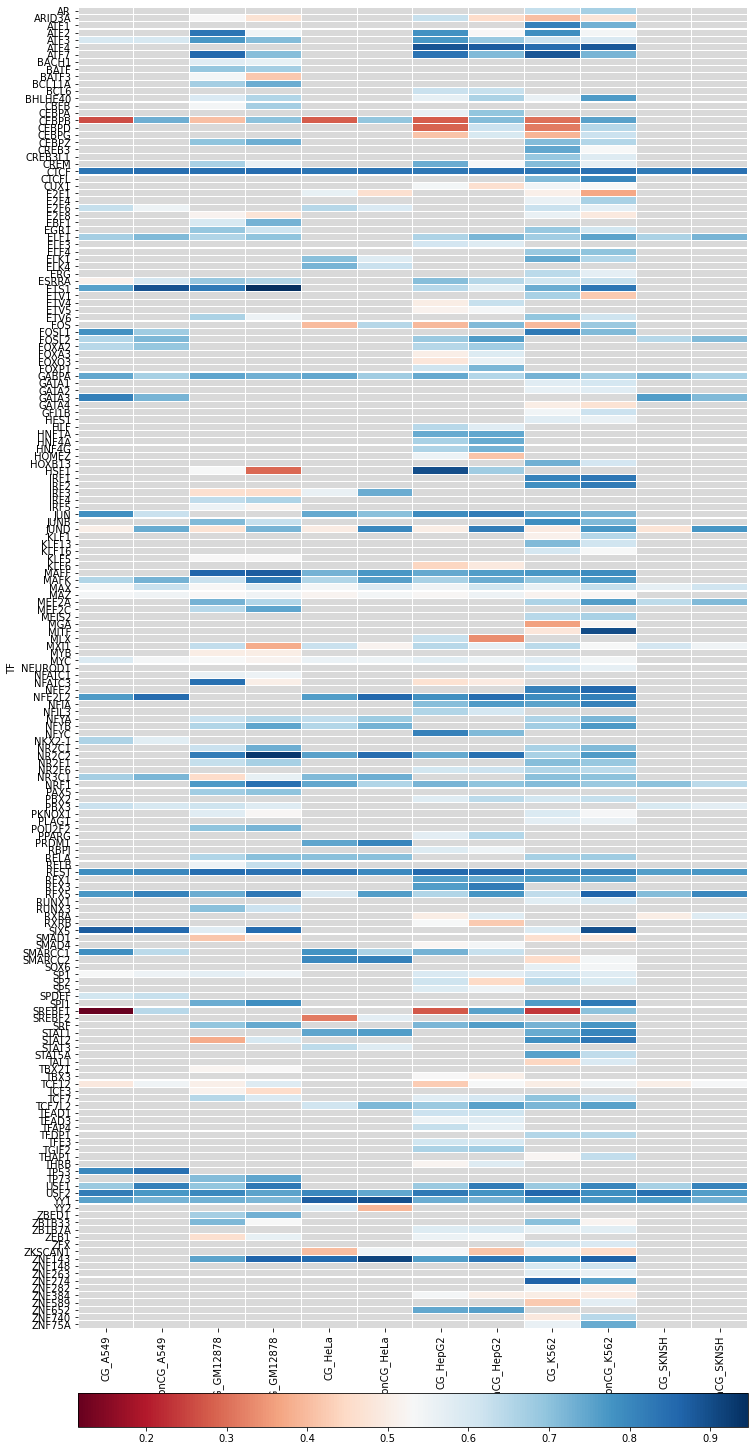

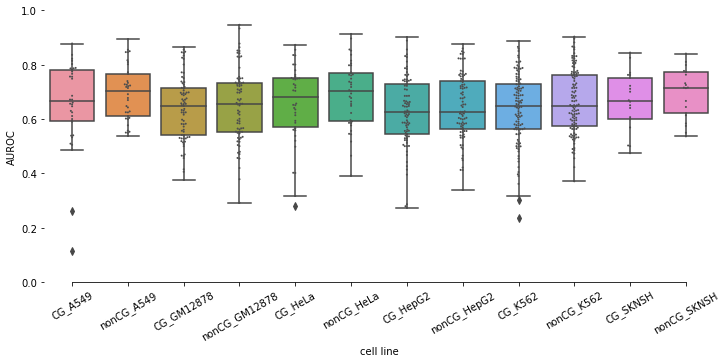

In [44]:
indir="../../d/tmp/redmo/camb_motif/camb_PRE_overall.txt"
# outdir="../../d/tmp/redmo/"
agg_meth='mean'
measure='auroc'
region='all'
depth='all'

aurocs=pd.read_table(indir,sep=',',names=['cell','TF','CG','nonCG'])
aurocs=aurocs[aurocs.cell!='0']

# if measure=='auroc':
#     aurocs.drop(['mo_aupr','wgbs_aupr','me_aupr','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc'],axis=1,inplace=True)


###PLOT
# measure="wg_auroc"
# measure='auroc'

##sum across cells and sort
# aurocs['diff']=aurocs['CG']-aurocs['nonCG']
heat=aurocs.pivot_table(index=['TF'], columns='cell')
# heat=heat[[measure]]
# heat['mean']=np.nanmean(heat,axis=1)
# heat['count']=heat.isnull().sum(axis=1)
# heat['count']=(21-heat['count'])
# heat=heat.sort_values(by=['count'],ascending=True)
# heat=heat.sort_values(by=['mean'],ascending=False)
# heat['diff']=heat['CG']-heat['nonCG']
# heat=heat.sort_values(by=['diff'],ascending=False)
# heat=heat[heat.index.str.contains(pat='CEB')]

# heat=heat[heat['count']==5]
# heat=heat[heat['mean']<0.1]
# del heat.iloc[:,0]
heat=heat.dropna(axis=1, how='all')
# del heat['count']
# del heat['mean']
# del heat['weight']
# heat['sum']=heat.isnull().sum(axis=0)
# heat=heat.sort_values(by=['sum'],ascending=True)
# del heat['sum']
heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','CG_A549','CG_GM12878','CG_HeLa','CG_HepG2','CG_K562','CG_SKNSH',
             'nonCG_A549','nonCG_GM12878','nonCG_HeLa','nonCG_HepG2','nonCG_K562','nonCG_SKNSH']

# # heat=heat[['TF','pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
# #           'me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
# #              'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']]

# heat['A549_diff']=GM12878['CG_A549']-GM12878['nonCG_A549']

# heat['GM12878_diff']=heat['CG_GM12878']-heat['nonCG_GM12878']
# heat['HeLa_diff']=heat['CG_HeLa']-heat['nonCG_HeLa']
# heat['HepG2_diff']=heat['CG_HepG2']-heat['nonCG_HepG2']
# heat['K562_diff']=heat['CG_K562']-heat['nonCG_K562']
# heat['SKNSH_diff']=heat['CG_SKNSH']-heat['nonCG_SKNSH']

heat=heat[['TF','CG_A549','nonCG_A549',#'A549_diff',
           'CG_GM12878','nonCG_GM12878',#'GM12878_diff',
           'CG_HeLa','nonCG_HeLa',#'HeLa_diff',
           'CG_HepG2','nonCG_HepG2',#'HepG2_diff',
           'CG_K562','nonCG_K562',#'K562_diff',
           'CG_SKNSH','nonCG_SKNSH'#'SKNSH_diff'
           ]]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))
# grid_kws = {"height_ratios": (60,12), "hspace": .3}

# f, (ax, cbar_ax) = plt.subplots(2)#, gridspec_kw=grid_kws)
# rdgn = sns.diverging_palette(h_neg=200, h_pos=20, s=99, l=55, sep=3, as_cmap=True)
# rdgn=sns.diverging_palette(220, 20, sep=20, as_cmap=True)
# rdgn=sns.color_palette("RdBu", 100)
# rdgn = plt.get_cmap("RdBu")
# rdgn.set_bad(color='black', alpha=0.15)
# # rdgn.set_bad(color='red')
# ax = sns.heatmap(heat, center=.5,linewidth=.1,cmap=rdgn,mask=heat.isnull(), cbar=False)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})

# mappable = ax.get_children()[0]
# plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
# plt.xticks(rotation=30)


rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)
# rdgn.set_bad(color='red')

ax = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40



# plt.imshow(heat, cmap='hot', interpolation='nearest')
# ax= sns.heatmap(heat, center=.5,cmap=rdgn,linewidth=.1)
# ax= sns.heatmap(heat, linewidth=.1,cmap="YlGnBu")

plt.savefig(outdir+"sthlm_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show

# print([(heat55['pwm-A549'].dropna().shape),(heat55['pwm-GM12878'].dropna().shape),(heat55['pwm-HeLa'].dropna().shape),(heat55['pwm-HepG2'].dropna().shape),(heat55['pwm-K562'].dropna().shape)])

box=heat55
# box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
meltbox=pd.melt(box,id_vars=['TF'])
# del box.TF
if measure=='auroc':
    meltbox.columns=['TF','cell line','AUROC']
    plt.figure(figsize=(12, 5))
    plt.xticks(rotation=30)
    g=sns.boxplot(x='cell line',y='AUROC', data=meltbox)
    g=sns.swarmplot(x='cell line',y='AUROC', data=meltbox,
                  size=2, color=".3", linewidth=0)
# elif measure=='aupr':
#     meltbox.columns=['TF','data - cell line','AUPR']
#     plt.figure(figsize=(12, 5))
#     plt.xticks(rotation=30)
#     g=sns.boxplot(x='data - cell line',y='AUPR', data=meltbox)
#     g=sns.swarmplot(x='data - cell line',y='AUPR', data=meltbox,
#                   size=2, color=".3", linewidth=0)
g.set(ylim=(0, 1))
plt.savefig(outdir+"camb_heat_CG-non.png",dpi=300,bbox_inches = "tight")
# meltbox.to_csv(outdir+measure+"meltbox.txt")

# plt.show
# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.show()


# t0a, p0a = stats.ttest_ind(box[''].dropna(),box['wg-A549'].dropna())
t0a, p0a = stats.ttest_ind(box['CG_A549'].dropna(),box['nonCG_A549'].dropna())
t1a, p1a = stats.ttest_ind(box['CG_GM12878'].dropna(),box['nonCG_GM12878'].dropna())
# t1b, p1b = stats.ttest_ind(box['pwm-GM12878'].dropna(),box['me-GM12878'].dropna())
t2a, p2a = stats.ttest_ind(box['CG_HeLa'].dropna(),box['nonCG_HeLa'].dropna())
# t2b, p2b = stats.ttest_ind(box['pwm-HeLa'].dropna(),box['me-HeLa'].dropna())
t3a, p3a = stats.ttest_ind(box['CG_HepG2'].dropna(),box['nonCG_HepG2'].dropna())
# t3b, p3b = stats.ttest_ind(box['pwm-HepG2'].dropna(),box['me-HepG2'].dropna())
t4a, p4a = stats.ttest_ind(box['CG_K562'].dropna(),box['nonCG_K562'].dropna())
# t4b, p4b = stats.ttest_ind(box['pwm-K562'].dropna(),box['me-K562'].dropna())
t5a, p5a = stats.ttest_ind(box['CG_SKNSH'].dropna(),box['nonCG_SKNSH'].dropna())


# initialise data of lists. 
ttest = {'CG-nonCG ttest':[t0a,t1a,t2a,t3a,t4a,t5a], 'CG-non pvalue':[p0a,p1a,p2a,p3a,p4a,p5a],}# 'Me ttest':[t0b,t1b,t2b,t3b,t4b],'Me pvalue':[p0b,p1b,p2b,p3b,p4b]} 

# Creates pandas DataFrame. 
df_ttest = pd.DataFrame(ttest, index =['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']) 

df_ttest.to_csv(outdir+"/camb_ttest.txt")
meltbox.to_csv(outdir+"/camb_meltbox.txt",sep='\t')

In [ ]:
df_ttest

## counts per window size ancilary analysis


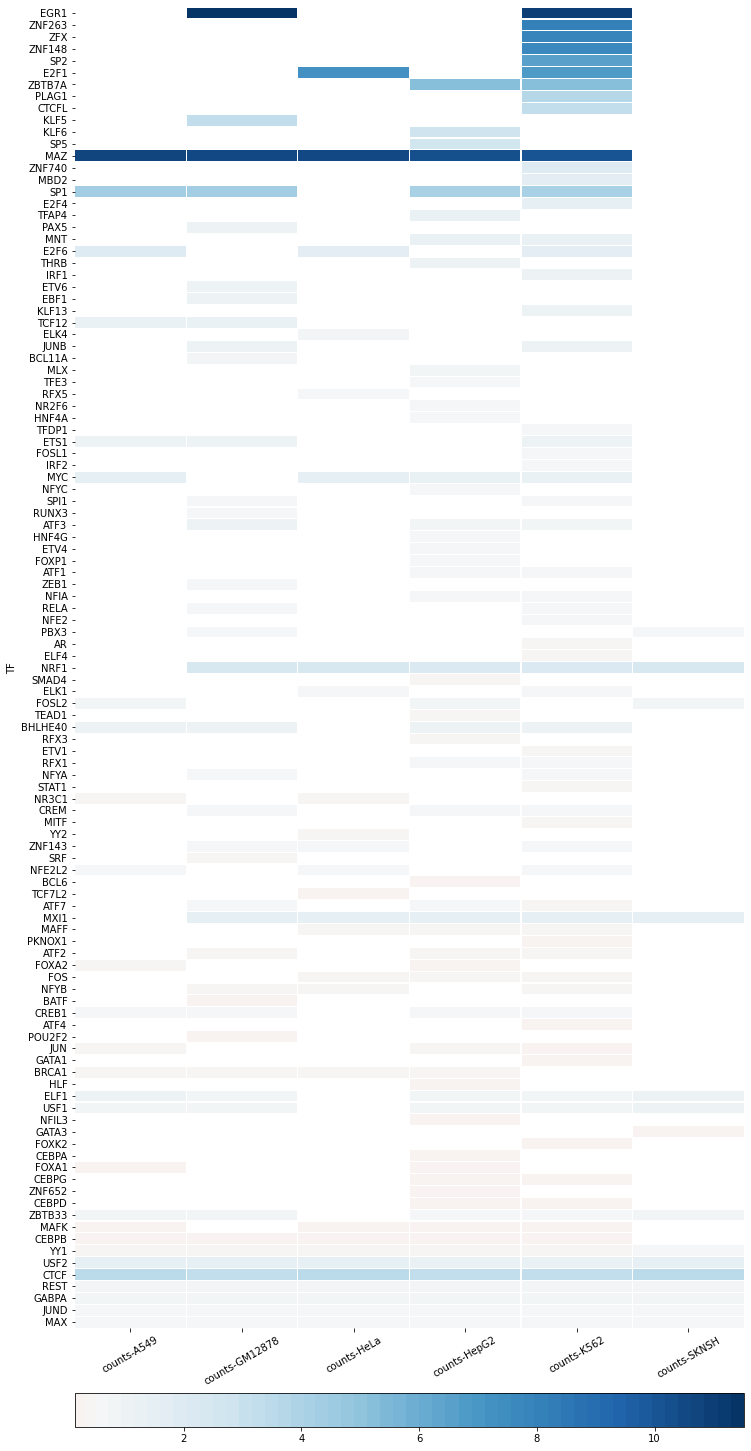

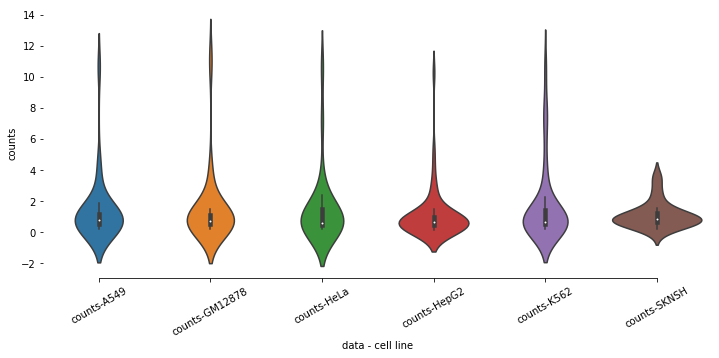

In [50]:

# aurocs.columns=['cell','TF','pwm','wgbs','array','counts']
##sum across cells and sort
heat=aurocs.pivot_table(index=['TF'], columns='cell',aggfunc='first')# heat=heat[[measure]]
heat['mean']=np.nanmean(heat,axis=1)
heat['count']=heat.isnull().sum(axis=1)

heat['weight']=heat['mean']*(heat['count'])
heat=heat.sort_values(by=['weight'],ascending=False)

heat=heat.dropna(axis=1, how='all')
del heat['count']
del heat['mean']
del heat['weight']

heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
              'counts-A549','counts-GM12878','counts-HeLa','counts-HepG2','counts-K562','counts-SKNSH',
              'pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
            'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']

heat=heat[['TF','counts-A549','counts-GM12878','counts-HeLa','counts-HepG2','counts-K562','counts-SKNSH']]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))
rdgn=sns.color_palette("RdBu", 100)
ax = sns.heatmap(heat/10000, center=.5,linewidth=.1,cmap=rdgn, cbar=False)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

# plt.savefig(indir+"/test/camb_auroc_heat.png",dpi=300,bbox_inches = "tight")
plt.show

# print([(heat55['pwm-A549'].dropna().shape),(heat55['pwm-GM12878'].dropna().shape),(heat55['pwm-HeLa'].dropna().shape),(heat55['pwm-HepG2'].dropna().shape),(heat55['pwm-K562'].dropna().shape),(heat55['pwm-SKNSH'].dropna().shape)])

box=heat55
# box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
countbox=pd.melt(box,id_vars=['TF'])
# del box.TF
# if measure=='auroc':
countbox.columns=['TF','data - cell line','counts']
plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
g=sns.violinplot(x='data - cell line',y=countbox.counts/10000, data=countbox)
# g=sns.swarmplot(x='data - cell line',y='AUROC', data=meltbox,
#               size=2, color=".3", linewidth=0)
plt.xticks(rotation=30)
# g.set(ylim=(0, 1))
# plt.savefig(indir+"/test/camb_auroc_box.png",dpi=300,bbox_inches = "tight")
countbox.to_csv(outdir+"countbox.txt")

plt.show

sns.despine(trim=True, left=True)
# plt.show()



/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

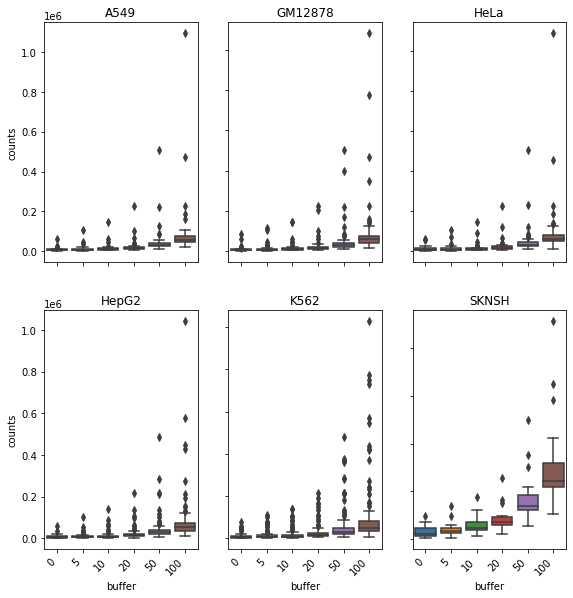

In [122]:
# indir='../../pc/redmo/data/MotifPipeline/**'

# # indir='../../pc/redmo/data/MotifPipeline/'
# # aurocs=pd.read_csv(indir+'/test/.txt',)

# # outdir='../../pc/redmo/data/MotifPipeline'
# allbox = pd.DataFrame()
# traces= glob.glob(indir+'/test/*',recursive = True)
# indices = [i for i, s in enumerate(traces) if '' in s]
# # method='auroc'


indir='../../pc/redmo/data/MotifPipeline/**'
outdir='../../pc/redmo/data/MotifPipeline'
allbox = pd.DataFrame()
traces= glob.glob(indir+'/test/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'camb_PRE_window_methyl' in s]

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[6]
    buffer=(buffer).split('_')[3]
    buffer=(buffer).split('a')[2]

    meltbox=pd.read_csv(trace,sep=',',names=['cell','TF','pwm','wgbs','array','counts'])
    meltbox['buffer']=buffer
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['cell']+'_'+allbox['buffer'].astype(str)
from pathlib import Path
# outdir='data/MotifPipeline/compare'
Path(outdir).mkdir(parents=True, exist_ok=True)
fig=plt.figure(figsize=(8, 8))
plt.xticks(rotation=30)
# plt.subplot(2, 2, 3)
cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']
# for cell in (cells): ##### aggregate across all cellines per data type
#     for test in tests:
# fig, axes = plt.subplots(nrows=3, ncols=2)
fig.tight_layout()
plt.subplot(2,3,1)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="A549")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('A549')
# g.set_yticklabels([])
g.set_xticklabels([])
# g.set_ylabel([])
g.set_xlabel('')

plt.subplot(2,3,2)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="GM12878")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('GM12878')
g.set_yticklabels([])
g.set_xticklabels([])
g.set_ylabel('')
g.set_xlabel('')

plt.subplot(2,3,3)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="HeLa")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('HeLa')
g.set_yticklabels([])
g.set_xticklabels([])
g.set_ylabel('')
g.set_xlabel('')

plt.subplot(2,3,4)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="HepG2")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('HepG2')
# g.set_yticklabels([])
# g.set_xticklabels([])
# g.set_ylabel([])
# g.set_xlabel([])

plt.subplot(2,3,5)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="K562")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('K562')
g.set_yticklabels([])
# g.set_xticklabels([])
g.set_ylabel('')
# g.set_xlabel([])

plt.subplot(2,3,6)
allbox2=allbox[allbox['cell_buff'].str.contains(pat="SKNSH")]
#         allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
allbox2.buffer=(allbox2.buffer).astype(int)
allbox2=allbox2.sort_values(by='buffer')
g=sns.boxplot(x='buffer',y='counts', data=allbox2)
# g=sns.swarmplot(x='cell_buff',y='counts', data=allbox2,size=2, color=".3", linewidth=0)
#     g.set(ylim=(0, 1))
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('SKNSH')
g.set_yticklabels([])
# g.set_xticklabels([])
g.set_ylabel('')
# g.set_xlabel([])

plt.show()
plt.savefig(outdir+"camb_allbox_buff.png",dpi=300,bbox_inches = "tight")
plt.close()
# return

## promoter centric analysis and functions

In [ ]:
plotallll(indir='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_gamma0')

# plotallll(indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma0')
# plotallll(indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma5')
# plotallll(indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma10')
# plotallll(indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma20')
# plotallll(indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma50')
# plotallll(indir='../../d/tmp/redmo/data/MotifPipeline/camb_motif_pipeline_gamma100')
# plotallll(indir='../../d/tmp/redmo/data/MotifPipeline/camb_motif_pipeline_gamma250')
# plotallll(indir='../../d/tmp/redmo/data/MotifPipeline/camb_motif_pipeline_gamma500')



In [18]:
def plotallll(indir):
    traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
    indices = [i for i, s in enumerate(traces) if 'txt' not in s]

    aurocs = pd.DataFrame()

    # os.makedirs(indir+'/test')


    # trace=traces[0]
    for i,trace in enumerate(indices):
        trace=traces[i]
    #     plt.subplot(2, 2, 3)
        if 'pc' in trace:
            combo=(trace).split('/')[7]

        elif 'd/tmp' in trace:
            combo=(trace).split('/')[8]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
        TF=combo.split('_')[1]
        cell=combo.split('_')[0]
    #     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
        try:
            data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,9,10,11],names=["chr", "start", "end",'pwm',"W1",'array','ChIPTF'])

            Col1=os.path.basename(trace).split('_')[0] #cell
            Col2=os.path.basename(trace).split('_')[1] #TF


            table2=[]
            tbl=[]
            tmpTBL2=[]
            tmpTBL=[]
            table3=[]
            tblC=[]
            tmpTBLC=[]
            data.pwm=(data.pwm-data.pwm.min())/(data.pwm.max()-data.pwm.min())
            data=data.fillna(0)
            data.ChIPTF=data.ChIPTF.replace('.',0)
            # print(data.shape)
            data.ChIPTF[(data.ChIPTF==Col2)]=1
            data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
            data.ChIPTF=pd.to_numeric(data.ChIPTF)

            if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

                plt.plot([0, 1], [0, 1], 'k--')
                fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
                roc_auc=metrics.auc(fpr, tpr)
                plt.plot(fpr, tpr,
                         label='pwm (area = {0:0.2f})'
                             ''.format(roc_auc),
                         color='b', linestyle=':', linewidth=4)

                fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
                roc_auc2=metrics.auc(fpr2, tpr2)
                plt.plot(fpr2, tpr2,
                         label='wgbs (area = {0:0.2f})'
                               ''.format(roc_auc2),
                         color='r', linestyle=':', linewidth=4)

                fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.array/100))
                roc_auc3=metrics.auc(fpr, tpr)
                plt.plot(fpr, tpr,
                         label='array (area = {0:0.2f})'
                             ''.format(roc_auc),
                         color='g', linestyle=':', linewidth=4)



#                 plt.xlabel('False Positive Rate')
#                 plt.ylabel('True Positive Rate')
#                 plt.title('AUROC for '+TF+' in '+cell)
#                 plt.legend(loc="best")

#                 plt.show()

                Col1=cell
                Col2=TF
                Col3=roc_auc #motif auroc
                Col4=roc_auc2
                Col5=roc_auc3
                Col6=data.shape[0]
                column = [Col1, Col2, Col3, Col4,Col5,Col6]
                column=np.transpose(pd.DataFrame((column)))
                column.to_csv(indir+'/test/camb_PRE_window_methyl.txt',mode='a',header=False,index=False)
                aurocs=pd.concat([aurocs,column],axis=0)
                print("AUROC calculated for "+TF+" in "+cell)
        except:
            pass

In [ ]:
aurocs=pd.read_csv(indir+'/test/camb_PRE_window_methyl.txt',names=['cell','TF','pwm','wgbs','array','counts'])


In [21]:
# indir='../../pc/redmo/data/MotifPipeline/camb_motif_pipeline_gamma0'
def heatallll(indir):
    aurocs=pd.read_csv(indir+'/test/camb_PRE_window_methyl.txt',names=['cell','TF','pwm','wgbs','array','counts'])

    aurocs.columns=['cell','TF','pwm','wgbs','array','counts']
    ##sum across cells and sort
    heat=aurocs.pivot_table(index=['TF'], columns='cell',aggfunc='first')# heat=heat[[measure]]
    heat['mean']=np.nanmean(heat,axis=1)
    heat['count']=heat.isnull().sum(axis=1)

    heat['weight']=heat['mean']*(heat['count'])
    heat=heat.sort_values(by=['weight'],ascending=False)

    heat=heat.dropna(axis=1, how='all')
    del heat['count']
    del heat['mean']
    del heat['weight']

    heat=pd.DataFrame(heat.to_records())

    heat.columns=['TF','me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
                  'counts-A549','counts-GM12878','counts-HeLa','counts-HepG2','counts-K562','counts-SKNSH',
                  'pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
                'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']

    heat=heat[['TF','pwm-A549','me-A549','wg-A549',
               'pwm-GM12878','me-GM12878','wg-GM12878',
               'pwm-HeLa', 'me-HeLa','wg-HeLa',
               'pwm-HepG2','me-HepG2','wg-HepG2',
               'pwm-K562','me-K562','wg-K562',
               'pwm-SKNSH','me-SKNSH','wg-SKNSH']]
    heat55=heat
    heat=heat.set_index('TF')

    plt.figure(figsize=(12, 60))
    rdgn = plt.get_cmap("RdBu")
    rdgn.set_bad(color='black', alpha=0.15)
    # rdgn.set_bad(color='red')
    ax = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
    #cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
    mappable = ax.get_children()[0]
    plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40

    plt.xticks(rotation=30)

    plt.savefig(indir+"/test/camb_auroc_heat.png",dpi=300,bbox_inches = "tight")
    plt.show

    print([(heat55['pwm-A549'].dropna().shape),(heat55['pwm-GM12878'].dropna().shape),(heat55['pwm-HeLa'].dropna().shape),(heat55['pwm-HepG2'].dropna().shape),(heat55['pwm-K562'].dropna().shape),(heat55['pwm-SKNSH'].dropna().shape)])

    box=heat55
    # box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
    meltbox=pd.melt(box,id_vars=['TF'])
    # del box.TF
    # if measure=='auroc':
    meltbox.columns=['TF','data - cell line','AUROC']
    plt.figure(figsize=(12, 5))
    plt.xticks(rotation=30)
    g=sns.boxplot(x='data - cell line',y='AUROC', data=meltbox)
    g=sns.swarmplot(x='data - cell line',y='AUROC', data=meltbox,
                  size=2, color=".3", linewidth=0)

    g.set(ylim=(0, 1))
    plt.savefig(indir+"/test/camb_auroc_box.png",dpi=300,bbox_inches = "tight")
    # meltbox.to_csv(outdir+measure+"meltbox.txt")

    plt.show

    sns.despine(trim=True, left=True)
    # plt.show()


    t0a, p0a = stats.ttest_ind(box['pwm-A549'].dropna(),box['wg-A549'].dropna())
    t0b, p0b = stats.ttest_ind(box['pwm-A549'].dropna(),box['me-A549'].dropna())
    t1a, p1a = stats.ttest_ind(box['pwm-GM12878'].dropna(),box['wg-GM12878'].dropna())
    t1b, p1b = stats.ttest_ind(box['pwm-GM12878'].dropna(),box['me-GM12878'].dropna())
    t2a, p2a = stats.ttest_ind(box['pwm-HeLa'].dropna(),box['wg-HeLa'].dropna())
    t2b, p2b = stats.ttest_ind(box['pwm-HeLa'].dropna(),box['me-HeLa'].dropna())
    t3a, p3a = stats.ttest_ind(box['pwm-HepG2'].dropna(),box['wg-HepG2'].dropna())
    t3b, p3b = stats.ttest_ind(box['pwm-HepG2'].dropna(),box['me-HepG2'].dropna())
    t4a, p4a = stats.ttest_ind(box['pwm-K562'].dropna(),box['wg-K562'].dropna())
    t4b, p4b = stats.ttest_ind(box['pwm-K562'].dropna(),box['me-K562'].dropna())
    t5a, p5a = stats.ttest_ind(box['pwm-SKNSH'].dropna(),box['wg-SKNSH'].dropna())
    t5b, p5b = stats.ttest_ind(box['pwm-SKNSH'].dropna(),box['me-SKNSH'].dropna())


    # initialise data of lists. 
    ttest = {'WG ttest':[t0a,t1a,t2a,t3a,t4a,t5a], 'WG pvalue':[p0a,p1a,p2a,p3a,p4a,p5a], 'Me ttest':[t0b,t1b,t2b,t3b,t4b,t5b],'Me pvalue':[p0b,p1b,p2b,p3b,p4b,p5b]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']) 

    df_ttest.to_csv(indir+"/test/camb_auroc_ttest.txt")
    meltbox.to_csv(indir+"/test/camb_auroc_meltbox.txt",sep='\t')
    return meltbox,heat

In [ ]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/sthlm_motif_0_QCbeta/red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'camb_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[2]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
# from pathlib import Path
# outdir='data/MotifPipeline/compare'
# Path(outdir).mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
# cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
# tests=['pwm','me','wg']
allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)
# for cell in cells:
# it='pwm'
#     for test in tests:
#     allbox2=allbox[allbox['cell_buff'].str.contains(pat=cell)]
#     allbox2=allbox2[allbox2['cell_buff'].str.contains(pat=test)]
#     allbox2.buffer=(allbox2.buffer).astype(int)
#     allbox2=allbox2.sort_values(by='cell')
    
# allbox2=allbox[allbox['cell']==cell]
#     allbox2=allbox2[allbox2.TF.isin(allbox2[allbox2['depth']==50]['TF'])]
#     allbox2=allbox2[allbox2['data']!='me']
# allbox2=allbox2.sort_values('data', axis=0)
aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
dd['diff_AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
dd['data']='me-wg'
dd['depth']=dd['depth_y']
dd['cell']=dd['cell_y']
allbox2=pd.concat([dd])
g=sns.boxplot(x='region',y='diff_AUROC', data=allbox2,hue='cell',fliersize=1)#.set(title = cell)
# g=sns.swarmplot(x='cell',y=method.upper(), data=allbox2,size=2, color=".3", linewidth=0,hue='data',palette="colorblind")
plt.axhline(y=0, xmin=-1, xmax=6)

g.set(ylim=(-.75, .75))
#     plt.title=it
#     g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#         plt.savefig(outdir+"/sthlm_"+cell+test+"_allbox_buff.png",dpi=300,bbox_inches = "tight")
#     plt.close()
# return

## TSS analysis

array([ 148.,    0., 1784.,    0.,   86.,    0.,   94.,    0.,  184.,
        156.])

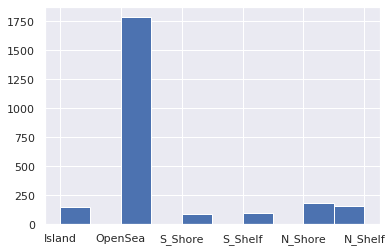

In [134]:
c=plt.hist(data.body)
c[0]

['GM12878', 'NRF1', 0.7326061783374007, 0.8065143636334122, 0.8080808627378834, 3225, 119]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.7004286594231743, 0.7468824769223679, 0.7566991129305973, 2523, 206]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.8100592166087374, 0.8756041615466535, 0.8919472433849431, 2269, 78]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.6618574973413683, 0.8882311237149947, 0.8903934774902517, 1098, 13]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.7088923511930523, 0.872630485588159, 0.9404627946565105, 3869, 18]
AUROC calculated for NRF1 in GM12878
['HepG2', 'ETV4', 0.49056603773584906, 0.8301886792452831, 0.8710691823899372, 59, 6]
AUROC calculated for ETV4 in HepG2
['GM12878', 'E2F4', 0.7064048620850865, 0.8287881149031218, 0.8919017193912004, 2148, 9]
AUROC calculated for E2F4 in GM12878
['GM12878', 'E2F4', 0.7635946940759775, 0.8455795541357038, 0.8707549135356623, 1320, 11]
AUROC calculated for E2F4 i

['K562', 'EGR1', 0.681591836617304, 0.7385738814319281, 0.7654160638943454, 4448, 433]
AUROC calculated for EGR1 in K562
['K562', 'EGR1', 0.6599344433425545, 0.68414572785636, 0.7051379060941146, 14910, 1225]
AUROC calculated for EGR1 in K562
['HeLa', 'NFE2L2', 0.7641070389761488, 0.7553810354857475, 0.7024432809773123, 391, 9]
AUROC calculated for NFE2L2 in HeLa
['HeLa', 'NFE2L2', 0.7453598484848485, 0.6950757575757576, 0.6880681818181819, 1006, 16]
AUROC calculated for NFE2L2 in HeLa
['K562', 'TFDP1', 0.6739062008183822, 0.8148016997167138, 0.8781082782499213, 742, 36]
AUROC calculated for TFDP1 in K562
['K562', 'TFDP1', 0.6809925629290617, 0.7640875286041189, 0.8279462242562929, 327, 23]
AUROC calculated for TFDP1 in K562
['K562', 'TFDP1', 0.5533923303834809, 0.7374631268436578, 0.7853982300884955, 577, 12]
AUROC calculated for TFDP1 in K562
['K562', 'TFDP1', 0.6144071844845705, 0.7796885449507976, 0.7746250119422948, 1172, 9]
AUROC calculated for TFDP1 in K562
['K562', 'ATF2', 0.80

['HepG2', 'CREM', 0.6724228981833544, 0.8795680185889312, 0.9170891423743135, 1590, 12]
AUROC calculated for CREM in HepG2
['SKNSH', 'NRF1', 0.713070190691474, 0.7620406595954328, 0.7680794644409668, 4014, 180]
AUROC calculated for NRF1 in SKNSH
['SKNSH', 'NRF1', 0.6202763555015572, 0.660042234371836, 0.6706936368808276, 3282, 276]
AUROC calculated for NRF1 in SKNSH
['SKNSH', 'NRF1', 0.7182280655136692, 0.8116809347212435, 0.8201897786044647, 2672, 101]
AUROC calculated for NRF1 in SKNSH
['SKNSH', 'NRF1', 0.6708604954367666, 0.8291232073011734, 0.857529335071708, 1206, 26]
AUROC calculated for NRF1 in SKNSH
['SKNSH', 'NRF1', 0.6656651126180674, 0.8439619157180915, 0.8653578348268346, 4177, 48]
AUROC calculated for NRF1 in SKNSH
['HepG2', 'NR2F6', 0.823512585812357, 0.7864702517162472, 0.8389588100686498, 445, 8]
AUROC calculated for NR2F6 in HepG2
['HepG2', 'NR2F6', 0.3032258064516129, 0.5935483870967742, 0.6440860215053763, 161, 6]
AUROC calculated for NR2F6 in HepG2
['HepG2', 'NR2F6'

['A549', 'FOSL2', 0.6486077481840193, 0.8038236481033091, 0.808817594834544, 437, 24]
AUROC calculated for FOSL2 in A549
['A549', 'FOSL2', 0.6178683385579937, 0.819435736677116, 0.9153605015673981, 156, 11]
AUROC calculated for FOSL2 in A549
['A549', 'FOSL2', 0.59086531337976, 0.8633130834197659, 0.8682026966958069, 431, 34]
AUROC calculated for FOSL2 in A549
['A549', 'FOSL2', 0.6938841201716738, 0.7139484978540773, 0.7626609442060086, 253, 20]
AUROC calculated for FOSL2 in A549
['A549', 'FOSL2', 0.6841402232534805, 0.8168443496801705, 0.8373636021572808, 1209, 70]
AUROC calculated for FOSL2 in A549
['A549', 'ETS1', 0.7296102490075784, 0.884578371225791, 0.89167568868038, 995, 17]
AUROC calculated for ETS1 in A549
['A549', 'ETS1', 0.706544502617801, 0.8436649214659686, 0.8703664921465969, 407, 25]
AUROC calculated for ETS1 in A549
['K562', 'NFE2L2', 0.7576252723311546, 0.8042846768336964, 0.7287581699346405, 315, 9]
AUROC calculated for NFE2L2 in K562
['K562', 'NFE2L2', 0.7560856864654

['K562', 'E2F6', 0.6717952124586982, 0.7718726172046491, 0.7950853762794888, 1645, 113]
AUROC calculated for E2F6 in K562
['K562', 'E2F6', 0.6743892262760187, 0.7257486903713319, 0.7706874971025914, 920, 106]
AUROC calculated for E2F6 in K562
['K562', 'E2F6', 0.5996956820508506, 0.7269482659486446, 0.7597571065954254, 1308, 57]
AUROC calculated for E2F6 in K562
['K562', 'E2F6', 0.6909294512877939, 0.6447368421052632, 0.7132458806590946, 677, 19]
AUROC calculated for E2F6 in K562
['K562', 'E2F6', 0.639791351386161, 0.6128771291496281, 0.6221624754483691, 2441, 52]
AUROC calculated for E2F6 in K562
['K562', 'NFE2', 0.8586206896551722, 0.8449270557029177, 0.8435676392572944, 342, 52]
AUROC calculated for NFE2 in K562
['K562', 'NFE2', 0.7810569663692519, 0.7831159917638985, 0.8007320979180965, 140, 47]
AUROC calculated for NFE2 in K562
['K562', 'NFE2', 0.8509508416943035, 0.7767306158431635, 0.7524873011208597, 370, 83]
AUROC calculated for NFE2 in K562
['K562', 'NFE2', 0.8550295857988166,

AUROC calculated for MYC in GM12878
['GM12878', 'MYC', 0.4700029481132076, 0.7435878537735849, 0.8236291273584906, 1704, 8]
AUROC calculated for MYC in GM12878
['HeLa', 'ELK1', 0.6654234654234654, 0.9058275058275058, 0.9087801087801088, 596, 11]
AUROC calculated for ELK1 in HeLa
['HeLa', 'ELK1', 0.6620317460317461, 0.8681269841269841, 0.8877460317460317, 340, 25]
AUROC calculated for ELK1 in HeLa
['HeLa', 'ELK1', 0.6687995124923827, 0.9367763558805606, 0.949116392443632, 553, 6]
AUROC calculated for ELK1 in HeLa
['HepG2', 'SMAD4', 0.41904761904761906, 0.7925170068027211, 0.8360544217687075, 251, 6]
AUROC calculated for SMAD4 in HepG2
['HepG2', 'SMAD4', 0.8099296536796536, 0.66504329004329, 0.6680194805194806, 535, 7]
AUROC calculated for SMAD4 in HepG2
['SKNSH', 'YY1', 0.772127659574468, 0.8937825059101655, 0.8994799054373522, 473, 50]
AUROC calculated for YY1 in SKNSH
['SKNSH', 'YY1', 0.7676107480029049, 0.8533042846768337, 0.837037037037037, 198, 45]
AUROC calculated for YY1 in SKNSH

AUROC calculated for NEUROD1 in K562
['K562', 'NEUROD1', 0.5513673318551368, 0.766629711751663, 0.8547671840354768, 257, 11]
AUROC calculated for NEUROD1 in K562
['K562', 'NEUROD1', 0.660407110091743, 0.825053243774574, 0.820076998689384, 1542, 16]
AUROC calculated for NEUROD1 in K562
['K562', 'PLAG1', 0.5579661083473157, 0.6525614985330626, 0.6534544170027375, 3023, 69]
AUROC calculated for PLAG1 in K562
['K562', 'PLAG1', 0.4674680691209617, 0.5453794139744553, 0.6204214518264105, 1892, 77]
AUROC calculated for PLAG1 in K562
['K562', 'PLAG1', 0.5773565573770492, 0.5790894511760514, 0.6144779044903779, 2486, 46]
AUROC calculated for PLAG1 in K562
['K562', 'PLAG1', 0.582050546930134, 0.596727240649259, 0.6573967889908257, 1449, 32]
AUROC calculated for PLAG1 in K562
['K562', 'PLAG1', 0.5510616438356165, 0.5663056506849314, 0.5889982876712329, 4747, 75]
AUROC calculated for PLAG1 in K562
['HepG2', 'JUND', 0.446520618556701, 0.7042525773195876, 0.8002577319587628, 105, 8]
AUROC calculated

AUROC calculated for SPI1 in K562
['HepG2', 'MAFF', 0.7182222222222222, 0.6448888888888888, 0.624, 245, 20]
AUROC calculated for MAFF in HepG2
['HepG2', 'MAFF', 0.9069444444444444, 0.663888888888889, 0.7111111111111111, 82, 10]
AUROC calculated for MAFF in HepG2
['HepG2', 'MAFF', 0.7184531886024423, 0.6134667571234735, 0.619572591587517, 290, 22]
AUROC calculated for MAFF in HepG2
['HepG2', 'MAFF', 0.7181818181818181, 0.7327823691460055, 0.7008264462809918, 176, 11]
AUROC calculated for MAFF in HepG2
['HepG2', 'MAFF', 0.750781209978997, 0.5865606270170586, 0.5985349111213565, 777, 54]
AUROC calculated for MAFF in HepG2
['HepG2', 'MXI1', 0.6053153372525829, 0.8175200890527707, 0.8560719379413505, 1725, 34]
AUROC calculated for MXI1 in HepG2
['HepG2', 'MXI1', 0.6919561243144423, 0.8293723339427178, 0.8989640463132236, 562, 15]
AUROC calculated for MXI1 in HepG2
['HepG2', 'MXI1', 0.7060191797592328, 0.8419608243215669, 0.9003468679861253, 1719, 29]
AUROC calculated for MXI1 in HepG2
['Hep

AUROC calculated for SP2 in HepG2
['HepG2', 'SP2', 0.587434554973822, 0.6613743455497383, 0.722914485165794, 4609, 25]
AUROC calculated for SP2 in HepG2
['K562', 'USF2', 0.8131716826812279, 0.8950376024720275, 0.9075858695601051, 1511, 374]
AUROC calculated for USF2 in K562
['K562', 'USF2', 0.8036899529831131, 0.8636034292181658, 0.8782215029537604, 870, 447]
AUROC calculated for USF2 in K562
['K562', 'USF2', 0.824077468230694, 0.8826147903768872, 0.8754649994569349, 1380, 264]
AUROC calculated for USF2 in K562
['K562', 'USF2', 0.7820486527418439, 0.8207783807660756, 0.8625134094781347, 781, 92]
AUROC calculated for USF2 in K562
['K562', 'USF2', 0.7768556035672871, 0.8026762417858523, 0.8027025581202717, 3310, 398]
AUROC calculated for USF2 in K562
['K562', 'ETV6', 0.6189311594202899, 0.8158967391304348, 0.8782608695652174, 932, 12]
AUROC calculated for ETV6 in K562
['K562', 'ETV6', 0.5689604898673276, 0.7208776789619478, 0.7381542498906546, 380, 19]
AUROC calculated for ETV6 in K562
[

AUROC calculated for ATF2 in HepG2
['HepG2', 'ATF2', 0.8138057594579333, 0.8860107284020328, 0.8790231507622812, 281, 28]
AUROC calculated for ATF2 in HepG2
['HepG2', 'ATF2', 0.7912493425554656, 0.79234084186833, 0.7882774104885731, 1322, 151]
AUROC calculated for ATF2 in HepG2
['GM12878', 'BATF', 0.5271062271062271, 0.7849816849816851, 0.8666666666666667, 118, 13]
AUROC calculated for BATF in GM12878
['GM12878', 'BATF', 0.6416023166023166, 0.7159749034749036, 0.8052123552123551, 398, 28]
AUROC calculated for BATF in GM12878
['A549', 'REST', 0.6360248447204969, 0.841959972394755, 0.8679089026915113, 814, 9]
AUROC calculated for REST in A549
['A549', 'REST', 0.6768238434163701, 0.8607651245551601, 0.8830071174377225, 289, 8]
AUROC calculated for REST in A549
['A549', 'REST', 0.8627388126682908, 0.8693422233619695, 0.8999871778433132, 720, 11]
AUROC calculated for REST in A549
['A549', 'REST', 0.8717559523809524, 0.802281746031746, 0.7673412698412698, 1828, 28]
AUROC calculated for REST 

['A549', 'E2F6', 0.6592691064539673, 0.801199040767386, 0.8219268063809821, 2131, 46]
AUROC calculated for E2F6 in A549
['A549', 'E2F6', 0.6391487150415722, 0.6799768518518519, 0.7262613378684808, 1212, 36]
AUROC calculated for E2F6 in A549
['A549', 'E2F6', 0.5248693834900732, 0.7809299895506792, 0.793521421107628, 1607, 12]
AUROC calculated for E2F6 in A549
['A549', 'E2F6', 0.7024612471896816, 0.8331114660986866, 0.8860489882854101, 2829, 12]
AUROC calculated for E2F6 in A549
['K562', 'GFI1B', 0.5732686517229844, 0.6806624289059886, 0.7627969220475075, 434, 7]
AUROC calculated for GFI1B in K562
['K562', 'ETS1', 0.7791216216216217, 0.8812162162162163, 0.8940540540540541, 770, 30]
AUROC calculated for ETS1 in K562
['K562', 'ETS1', 0.7961079168509508, 0.8948474126492703, 0.9239274657231313, 257, 19]
AUROC calculated for ETS1 in K562
['K562', 'ETS1', 0.4535958587539286, 0.6970789425032353, 0.7413569975965982, 610, 9]
AUROC calculated for ETS1 in K562
['K562', 'ETS1', 0.8537508846426043, 0

['HepG2', 'NRF1', 0.7470453939101409, 0.8616737235063022, 0.8747426239223809, 2106, 267]
AUROC calculated for NRF1 in HepG2
['HepG2', 'NRF1', 0.738885008481462, 0.8840748079198324, 0.9080438470200847, 1034, 73]
AUROC calculated for NRF1 in HepG2
['HepG2', 'NRF1', 0.6765748462109561, 0.8401762276608157, 0.8644203743967758, 3661, 173]
AUROC calculated for NRF1 in HepG2
['GM12878', 'BCL11A', 0.687572505800464, 0.8129350348027843, 0.8225058004640372, 870, 8]
AUROC calculated for BCL11A in GM12878
['SKNSH', 'ZBTB33', 0.8088775851186278, 0.8772076387083998, 0.8868674117253926, 1240, 69]
AUROC calculated for ZBTB33 in SKNSH
['SKNSH', 'ZBTB33', 0.6403515332834704, 0.7254861630516081, 0.7576477187733732, 834, 70]
AUROC calculated for ZBTB33 in SKNSH
['SKNSH', 'ZBTB33', 0.7003065917220235, 0.8491313234542667, 0.8748083801737353, 843, 19]
AUROC calculated for ZBTB33 in SKNSH
['K562', 'THAP1', 0.5961680403493665, 0.8098167056218477, 0.8474597121417149, 761, 22]
AUROC calculated for THAP1 in K562
[

['SKNSH', 'USF1', 0.6040498442367601, 0.807433666344398, 0.865119776560318, 622, 87]
AUROC calculated for USF1 in SKNSH
['SKNSH', 'USF1', 0.6575631525436985, 0.7506417901693192, 0.7825934579439253, 2818, 428]
AUROC calculated for USF1 in SKNSH
['K562', 'ATF3', 0.6748767258382643, 0.7982445759368837, 0.8280374753451676, 965, 120]
AUROC calculated for ATF3 in K562
['K562', 'ATF3', 0.5871886120996441, 0.7506524317912219, 0.7934282325029656, 431, 150]
AUROC calculated for ATF3 in K562
['K562', 'ATF3', 0.6656430914173765, 0.7971890202293689, 0.7846969997138392, 854, 57]
AUROC calculated for ATF3 in K562
['K562', 'ATF3', 0.5882084095063985, 0.7045899712718726, 0.7255158004700967, 575, 28]
AUROC calculated for ATF3 in K562
['K562', 'ATF3', 0.5883797448812211, 0.6253883710608077, 0.6585953028811826, 2345, 92]
AUROC calculated for ATF3 in K562
['HeLa', 'RELA', 0.6549376640419947, 0.8874671916010498, 0.8861548556430445, 520, 12]
AUROC calculated for RELA in HeLa
['HeLa', 'RELA', 0.30098934550989

['HepG2', 'TCF7', 0.6302211302211302, 0.8828828828828829, 0.8988533988533989, 413, 6]
AUROC calculated for TCF7 in HepG2
['SKNSH', 'GABPA', 0.7561454621127384, 0.8630830060088963, 0.8595583071040241, 1076, 37]
AUROC calculated for GABPA in SKNSH
['SKNSH', 'GABPA', 0.6153193981995314, 0.746300406955235, 0.783049697866568, 665, 53]
AUROC calculated for GABPA in SKNSH
['SKNSH', 'GABPA', 0.7677380952380952, 0.8943650793650794, 0.9027777777777778, 914, 14]
AUROC calculated for GABPA in SKNSH
['SKNSH', 'GABPA', 0.569865704366892, 0.8613648821487302, 0.8810067604604421, 1697, 13]
AUROC calculated for GABPA in SKNSH
['K562', 'MITF', 0.5281323877068558, 0.6758865248226951, 0.7574468085106383, 156, 15]
AUROC calculated for MITF in K562
['K562', 'MITF', 0.5491935483870968, 0.805241935483871, 0.8943548387096774, 71, 31]
AUROC calculated for MITF in K562
['K562', 'MITF', 0.5558724397199897, 0.686414311641172, 0.7049520352605653, 162, 29]
AUROC calculated for MITF in K562
['K562', 'MITF', 0.45599250

AUROC calculated for MLX in HepG2
['HepG2', 'MLX', 0.699686219820448, 0.8426087335483308, 0.8794996949359366, 1653, 14]
AUROC calculated for MLX in HepG2
['HeLa', 'ELK4', 0.6912993920972644, 0.8694275582573454, 0.8752955082742317, 874, 28]
AUROC calculated for ELK4 in HeLa
['HeLa', 'ELK4', 0.6900299850074962, 0.8768948858903881, 0.890887889388639, 545, 23]
AUROC calculated for ELK4 in HeLa
['HeLa', 'ELK4', 0.7424906964380649, 0.9330143540669857, 0.9568048910154174, 845, 9]
AUROC calculated for ELK4 in HeLa
['HepG2', 'CEBPD', 0.6439393939393939, 0.8696969696969697, 0.8929292929292929, 81, 15]
AUROC calculated for CEBPD in HepG2
['HepG2', 'CEBPD', 0.59863523573201, 0.5856079404466501, 0.673697270471464, 75, 13]
AUROC calculated for CEBPD in HepG2
['HepG2', 'CEBPD', 0.384375, 0.1640625, 0.2125, 48, 8]
AUROC calculated for CEBPD in HepG2
['HepG2', 'CEBPD', 0.6042424242424242, 0.6815584415584415, 0.6931601731601731, 200, 35]
AUROC calculated for CEBPD in HepG2
['A549', 'MAX', 0.598396457847

AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.6504761904761904, 0.739047619047619, 0.7765079365079365, 239, 14]
AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.6513782676063377, 0.734342979957015, 0.7559604138551507, 1104, 78]
AUROC calculated for FOSL2 in HepG2
['GM12878', 'MXI1', 0.6230561061137369, 0.7929562433297759, 0.867586522335722, 1888, 14]
AUROC calculated for MXI1 in GM12878
['GM12878', 'MXI1', 0.4971169686985173, 0.7022240527182867, 0.8314113124656782, 619, 12]
AUROC calculated for MXI1 in GM12878
['GM12878', 'MXI1', 0.48863305630113507, 0.7639944377971088, 0.8445493645506581, 1836, 17]
AUROC calculated for MXI1 in GM12878
['GM12878', 'MXI1', 0.7567080943275972, 0.8053696622052263, 0.874251115360102, 5236, 6]
AUROC calculated for MXI1 in GM12878
['K562', 'KLF1', 0.46313131313131317, 0.5537878787878787, 0.7141414141414142, 449, 9]
AUROC calculated for KLF1 in K562
['GM12878', 'USF1', 0.6668910506963143, 0.8225918526882654, 0.8955962824633023, 881, 87]
AUR

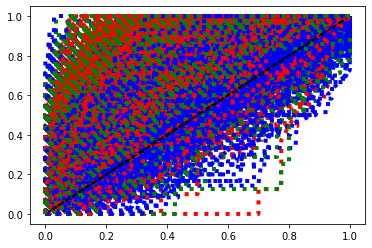

In [201]:
import shutil

indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'txt' not in s]
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[i]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
    for TSS in enumerate(www):
        Col1=os.path.basename(trace).split('_')[0] #cell
        Col2=os.path.basename(trace).split('_')[1] #TF
        TSS=TSS[1]
#         if Col1=='GM12878':
#             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
#             cc=data.body.str.find(TSS)
#             cc[cc!=-1]=TSS
#             data['TSS']=cc
#             print(Col2+'in'+Col1)
#         else:
        try:
            data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','body','TSS','ChIPTF'])
#                 break
        except:
            pass
        data=data[data['TSS']==TSS]


        table2=[]
        tbl=[]
        tmpTBL2=[]
        tmpTBL=[]
        table3=[]
        tblC=[]
        tmpTBLC=[]
#         data.pwm=(data.pwm-data.pwm.min())/(data.pwm.max()-data.pwm.min())
        data=data.fillna(0)
        data.ChIPTF=data.ChIPTF.replace('.',0)
        # print(data.shape)
        data.ChIPTF[(data.ChIPTF==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)

        if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

            plt.plot([0, 1], [0, 1], 'k--')
            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, (data.pwm))
            roc_auc=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc2=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc2),
                     color='r', linestyle=':', linewidth=4)

            fpr3, tpr3, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.array))
            roc_auc3=metrics.auc(fpr3, tpr3)
            plt.plot(fpr3, tpr3,
                     label='array (area = {0:0.2f})'
                         ''.format(roc_auc3),
                     color='g', linestyle=':', linewidth=4)



#             plt.xlabel('False Positive Rate')
#             plt.ylabel('True Positive Rate')
#             plt.title('AUROC for '+TF+' in '+cell)
#             plt.legend(loc="best")

#             plt.show()

            Col1=cell
            Col2=TF
            Col3=roc_auc #motif auroc
            Col4=roc_auc2
            Col5=roc_auc3
            Col6=data.shape[0]
            Col7=np.sum(data.ChIPTF)
            column = [Col1, Col2, Col3, Col4,Col5,Col6,Col7]
            print(column)
            column=np.transpose(pd.DataFrame((column)))
            column.to_csv(indir+'/test/'+TSS+'_PRE_window_methyl.txt',mode='a',header=False,index=False)
            aurocs=pd.concat([aurocs,column],axis=0)
            print("AUROC calculated for "+TF+" in "+cell)
#     except:
#         pass

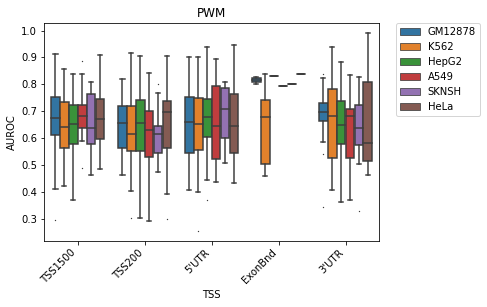

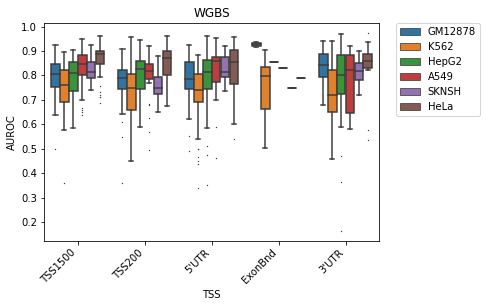

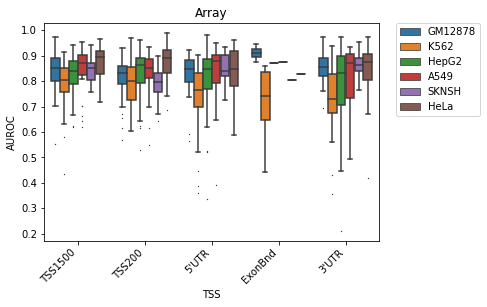

In [202]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR",'overlap']
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces= glob.glob(indir+'/pwm_multi/*_PRE_window_methyl.txt',recursive = True)
# indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for i,trace in enumerate(traces):
#     trace=traces[jac]
    TSS=(traces[i]).split('/')[9]
    TSS=(TSS).split('_')[0]
#     region=(trace).split('/')[5]
#     depth=(trace).split('/')[6]
    meltbox=pd.read_csv(traces[i],sep=',',names=['cell','TF','pwm','wg','array','size','yes'])
    meltbox['TSS']=TSS
#     print(pd.unique(meltbox.cell))
#     meltbox['buffer']=buffer
    
#     meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox00=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['pwm','wg','array'])
allbox11=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['pwm'])
allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])




allbox11=allbox11[allbox11.cell!='overlap']
allbox11['AUROC']=allbox11['value']
del allbox11['value']
aa=allbox11[allbox11['TSS']==www[0]]
bb=allbox11[allbox11['TSS']==www[1]]
cc=allbox11[allbox11['TSS']==www[2]]
dd=allbox11[allbox11['TSS']==www[3]]
ee=allbox11[allbox11['TSS']==www[4]]
ff=allbox11[allbox11['TSS']==www[5]]
allboxx11=pd.concat([aa,bb,cc,dd,ee,ff])

allbox22=allbox22[allbox22.cell!='overlap']
allbox22['AUROC']=allbox22['value']
del allbox22['value']
aa=allbox22[allbox22['TSS']==www[0]]
bb=allbox22[allbox22['TSS']==www[1]]
cc=allbox22[allbox22['TSS']==www[2]]
dd=allbox22[allbox22['TSS']==www[3]]
ee=allbox22[allbox22['TSS']==www[4]]
ff=allbox22[allbox22['TSS']==www[5]]
allboxx22=pd.concat([aa,bb,cc,dd,ee,ff])

allbox33=allbox33[allbox33.cell!='overlap']
allbox33['AUROC']=allbox33['value']
del allbox33['value']
aa=allbox33[allbox33['TSS']==www[0]]
bb=allbox33[allbox33['TSS']==www[1]]
cc=allbox33[allbox33['TSS']==www[2]]
dd=allbox33[allbox33['TSS']==www[3]]
ee=allbox33[allbox33['TSS']==www[4]]
ff=allbox33[allbox33['TSS']==www[5]]
allboxx33=pd.concat([aa,bb,cc,dd,ee,ff])
plt.grid(False)

plt.xticks(rotation=30)
g=sns.boxplot(x='TSS',y=method.upper(), data=allboxx11,hue='cell',fliersize = .5)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PWM')
plt.show()
plt.grid(False)
h=sns.boxplot(x='TSS',y=method.upper(), data=allboxx22,hue='cell',fliersize = .5)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('WGBS')
plt.show()
plt.grid(False)
j=sns.boxplot(x='TSS',y=method.upper(), data=allboxx33,hue='cell',fliersize = .5)
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Array')
plt.show()
# plt.xticks(rotation=30)


In [123]:
allbox00

TF     cell      TSS  size  yes variable     AUROC
680      NRF1  GM12878  TSS1500  3225  119      pwm  0.732606
681      E2F4  GM12878  TSS1500  2148    9      pwm  0.706405
682     CREB3     K562  TSS1500   388    6      pwm  0.534686
683      USF2    HepG2  TSS1500  1643  383      pwm  0.754080
684      E2F8     K562  TSS1500   498    7      pwm  0.473814
...       ...      ...      ...   ...  ...      ...       ...
2579    FOSL1     K562        0   638   35    array  0.658849
2580   NFE2L2    HepG2        0   935   20    array  0.527213
2581  SMARCC1     A549        0  1935   18    array  0.919898
2582     NFYB     K562        0   446   13    array  0.554628
2583     MAFF     K562        0   745   68    array  0.567056

[3201 rows x 7 columns]

### Fig 4

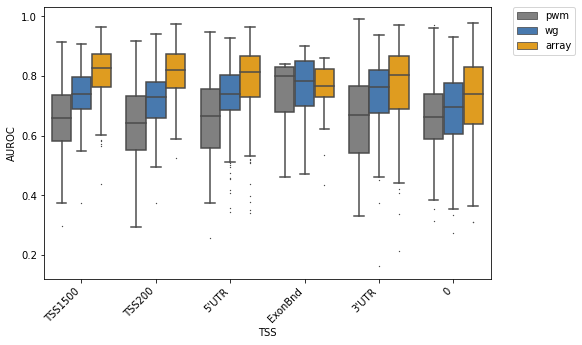

In [14]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces= glob.glob(indir+'/test/*_PRE_window_methyl.txt',recursive = True)
# indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for i,trace in enumerate(traces):
#     trace=traces[jac]
    TSS=(traces[i]).split('/')[9]
    TSS=(TSS).split('_')[0]
#     region=(trace).split('/')[5]
#     depth=(trace).split('/')[6]
    meltbox=pd.read_csv(traces[i],sep=',',names=['cell','TF','pwm','wg','array','size','yes'])
    meltbox['TSS']=TSS
#     print(pd.unique(meltbox.cell))
#     meltbox['buffer']=buffer
    
#     meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array'])
allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array'])
# allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
# allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])
plt.figure(figsize=(8, 5))
plt.grid(False)
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']
del allbox00['value']
aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
ff=allbox00[allbox00['TSS']==www[5]]
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

j=sns.boxplot(x='TSS',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox


<function matplotlib.pyplot.show(close=None, block=None)>

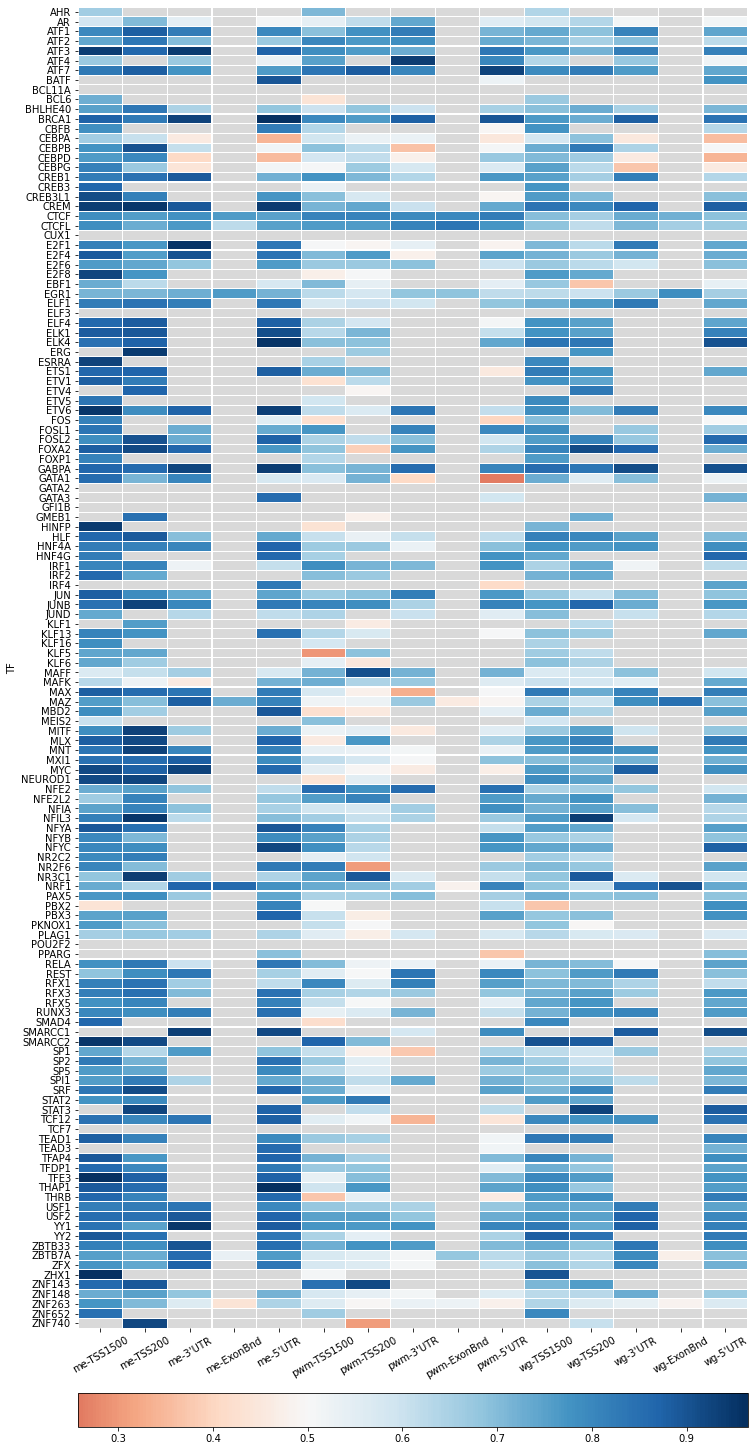

In [15]:
del allbox['size']
del allbox['yes']
del allbox['cell']
tssheat=allbox.pivot_table(index=['TF'], columns=['TSS'],aggfunc='first')

tssheat.columns=['me-0',"me-3'UTR","me-5'UTR",'me-ExonBnd','me-TSS1500','me-TSS200',
              'pwm-0',"pwm-3'UTR","pwm-5'UTR",'pwm-ExonBnd','pwm-TSS1500','pwm-TSS200',
            'wg-0',"wg-3'UTR","wg-5'UTR",'wg-ExonBnd','wg-TSS1500','wg-TSS200']

tssheat=tssheat[['me-TSS1500','me-TSS200',"me-3'UTR",'me-ExonBnd',"me-5'UTR",
          'pwm-TSS1500','pwm-TSS200',"pwm-3'UTR",'pwm-ExonBnd',"pwm-5'UTR",
          'wg-TSS1500','wg-TSS200',"wg-3'UTR",'wg-ExonBnd',"wg-5'UTR"]]
heat55=tssheat
# tssheat=tssheat.set_index('TF')

plt.figure(figsize=(12, 30))
# rdgn=sns.color_palette("RdBu", 100)
rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)
ax = sns.heatmap(tssheat, center=.5,linewidth=.1,cmap=rdgn, cbar=False)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

# plt.savefig(indir+"/test/camb_auroc_heat.png",dpi=300,bbox_inches = "tight")
plt.show

# print([(heat55['pwm-A549'].dropna().shape),(heat55['pwm-GM12878'].dropna().shape),(heat55['pwm-HeLa'].dropna().shape),(heat55['pwm-HepG2'].dropna().shape),(heat55['pwm-K562'].dropna().shape),(heat55['pwm-SKNSH'].dropna().shape)])

# box=heat55
# # box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
# countbox=pd.melt(box)
# # del box.TF
# # if measure=='auroc':
# countbox.columns=['TF','TSS']
# plt.figure(figsize=(12, 5))
# plt.xticks(rotation=30)
# g=sns.violinplot(x='TF',y='TSS', data=countbox)
# # g=sns.swarmplot(x='data - cell line',y='AUROC', data=meltbox,
# #               size=2, color=".3", linewidth=0)
# plt.xticks(rotation=30)
# # g.set(ylim=(0, 1))
# # plt.savefig(indir+"/test/camb_auroc_box.png",dpi=300,bbox_inches = "tight")
# countbox.to_csv(indir+"countbox.txt")

# plt.show

# sns.despine(trim=True, left=True)
# plt.show()



# Fig 5 TSS scatter

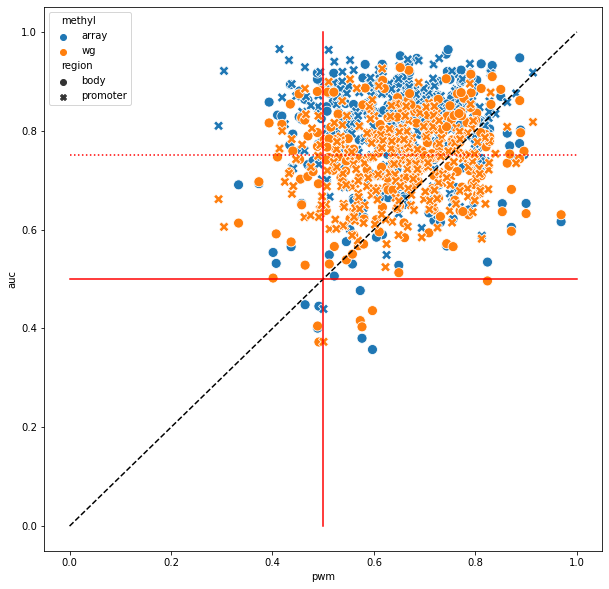

In [16]:
# pwmmm=np.mean(heat[heat.columns[heat.columns.str.contains('pwm')]],axis=1)
# wgbsss=np.mean(heat[heat.columns[heat.columns.str.contains('wg')]],axis=1)
# meee=np.mean(heat[heat.columns[heat.columns.str.contains('me')]],axis=1)
# invData=pd.DataFrame([pwmmm,wgbsss,meee]).transpose()
# invData.columns=['pwm','wg','me']

plt.figure(figsize=(10, 10))
allbox11['auc']=allbox11['value']
allbox11['methyl']=allbox11['variable']

aa=allbox11[allbox11['TSS']==www[0]]
bb=allbox11[allbox11['TSS']==www[1]]
cc=allbox11[allbox11['TSS']==www[2]]
dd=allbox11[allbox11['TSS']==www[3]]
ee=allbox11[allbox11['TSS']==www[4]]
aa['region']='promoter'
bb['region']='promoter'
cc['region']='body'
dd['region']='body'
ee['region']='body'
allbox11=pd.concat([aa,bb,cc,dd,ee])
allboxxx11=allbox11.groupby(['methyl','region','cell','TF']).mean()

# fig, ax = plt.subplots()
# invData['TF']=invData.index
# invData2=pd.melt(allbox00,id_vars=['TF','pwm'])
# invData2.columns=['TF','pwm','data','auc']
sns.scatterplot(
    data=allboxxx11, x="pwm", y='auc', style='region', hue="methyl",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')
# ax.fill_between(.5*invData2.auc, [0.5],1, alpha=0.2)

In [17]:
# df_sheet_index = pd.read_excel('mili_benchmark/aaj2239_Yin_SM_tables_S1-S6.xlsx', sheet_name='S3 bisulfite-SELEX data')
df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc

TF name  Unnamed: 1           Call methyl-SELEX call        bisulfite call
0      ALX3         NaN     MethylPlus        MethylPlus  low complexity motif
1      CDX4         NaN     MethylPlus        MethylPlus            MethylPlus
2      CDX4         NaN     MethylPlus        MethylPlus            MethylPlus
3     CEBPB         NaN     MethylPlus     Little effect       weak MethylPlus
4     CEBPE         NaN     MethylPlus     Little effect       weak MethylPlus
..      ...         ...            ...               ...                   ...
667  ZBTB12         NaN  Little effect     Little effect                   NaN
668     NaN         NaN    MethylMinus       MethylMinus                   NaN
669  ZBTB37         NaN     MethylPlus        MethylPlus                   NaN
670    CUX2         NaN   inconclusive        MethylPlus                   NaN
671     NaN         NaN            NaN               NaN                   NaN

[672 rows x 5 columns]

In [18]:
allboxxx22=allbox11.groupby(['methyl','region','TF','cell']).mean()

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb,ccc])

In [19]:
bbb[bbb['TF name']=='CEBPB']

size   yes       pwm     value       auc TF name  Unnamed: 1  \
84    73.5  45.0  0.464354  0.447948  0.447948   CEBPB         NaN   
85    80.0   7.0  0.823875  0.534247  0.534247   CEBPB         NaN   
86    59.0  24.5  0.521917  0.505930  0.505930   CEBPB         NaN   
87    71.5  55.0  0.436774  0.565334  0.565334   CEBPB         NaN   
88   100.0  81.0  0.407315  0.531595  0.531595   CEBPB         NaN   
89    65.5  43.0  0.642833  0.679385  0.679385   CEBPB         NaN   
90    48.5  11.0  0.636967  0.797911  0.797911   CEBPB         NaN   
91    48.5  21.0  0.606777  0.708622  0.708622   CEBPB         NaN   
92    61.5  44.5  0.658405  0.840515  0.840515   CEBPB         NaN   
93    76.0  60.0  0.648627  0.632013  0.632013   CEBPB         NaN   
94    73.5  45.0  0.464354  0.528006  0.528006   CEBPB         NaN   
95    80.0   7.0  0.823875  0.496086  0.496086   CEBPB         NaN   
96    59.0  24.5  0.521917  0.565829  0.565829   CEBPB         NaN   
97    71.5  55.0  0.436774  0.574989  0.574989   CEBPB         NaN   
98   100.0  81.0  0.407315  0.591275  0.591275   CEBPB         NaN   
99    65.5  43.0  0.642833  0.664499  0.664499   CEBPB         NaN   
100   48.5  11.0  0.636967  0.740789  0.740789   CEBPB         NaN   
101   48.5  21.0  0.606777  0.683049  0.683049   CEBPB         NaN   
102   61.5  44.5  0.658405  0.778336  0.778336   CEBPB         NaN   
103   76.0  60.0  0.648627  0.588861  0.588861   CEBPB         NaN   

           Call methyl-SELEX call   bisulfite call  
84   MethylPlus     Little effect  weak MethylPlus  
85   MethylPlus     Little effect  weak MethylPlus  
86   MethylPlus     Little effect  weak MethylPlus  
87   MethylPlus     Little effect  weak MethylPlus  
88   MethylPlus     Little effect  weak MethylPlus  
89   MethylPlus     Little effect  weak MethylPlus  
90   MethylPlus     Little effect  weak MethylPlus  
91   MethylPlus     Little effect  weak MethylPlus  
92   MethylPlus     Little effect  weak MethylPlus  
93   MethylPlus     Little effect  weak MethylPlus  
94   MethylPlus     Little effect  weak MethylPlus  
95   MethylPlus     Little effect  weak MethylPlus  
96   MethylPlus     Little effect  weak MethylPlus  
97   MethylPlus     Little effect  weak MethylPlus  
98   MethylPlus     Little effect  weak MethylPlus  
99   MethylPlus     Little effect  weak MethylPlus  
100  MethylPlus     Little effect  weak MethylPlus  
101  MethylPlus     Little effect  weak MethylPlus  
102  MethylPlus     Little effect  weak MethylPlus  
103  MethylPlus     Little effect  weak MethylPlus

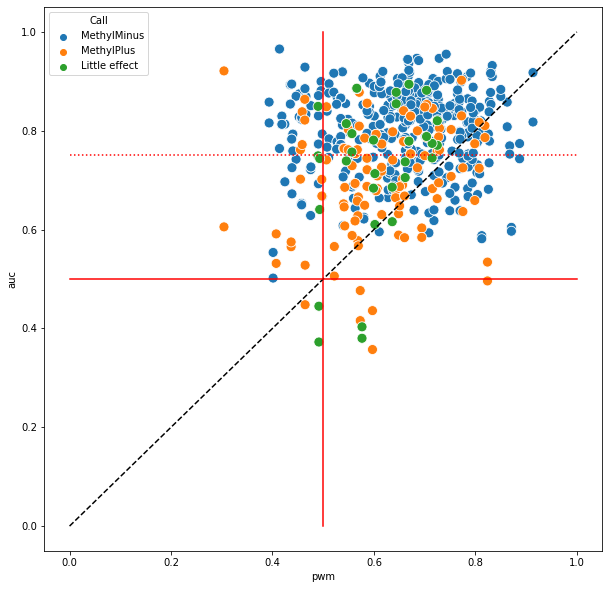

In [20]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=aa, x="pwm", y='auc', hue="Call",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')

In [21]:
allboxxx22=allbox11.groupby(['methyl','TF','cell']).mean()
allboxxx22

size    yes       pwm     value       auc
methyl TF     cell                                                
array  AHR    HepG2     719.0   8.00  0.709388  0.661920  0.661920
       AR     K562      191.5  29.75  0.614384  0.585855  0.585855
       ATF1   HepG2     462.5  13.50  0.717569  0.934191  0.934191
              K562      523.5  59.50  0.752727  0.826190  0.826190
       ATF2   GM12878   459.0  49.75  0.787780  0.748680  0.748680
...                       ...    ...       ...       ...       ...
wg     ZNF143 K562      302.5  16.00  0.880342  0.734367  0.734367
       ZNF148 K562     4956.0  81.50  0.549223  0.661297  0.661297
       ZNF263 K562     3988.4  78.00  0.517572  0.558848  0.558848
       ZNF652 HepG2      95.0   7.00  0.664773  0.798701  0.798701
       ZNF740 K562      703.0   6.00  0.304400  0.605452  0.605452

[546 rows x 5 columns]

In [22]:
cc

TF name  Unnamed: 1           Call methyl-SELEX call        bisulfite call
0      ALX3         NaN     MethylPlus        MethylPlus  low complexity motif
1      CDX4         NaN     MethylPlus        MethylPlus            MethylPlus
2      CDX4         NaN     MethylPlus        MethylPlus            MethylPlus
3     CEBPB         NaN     MethylPlus     Little effect       weak MethylPlus
4     CEBPE         NaN     MethylPlus     Little effect       weak MethylPlus
..      ...         ...            ...               ...                   ...
667  ZBTB12         NaN  Little effect     Little effect                   NaN
668     NaN         NaN    MethylMinus       MethylMinus                   NaN
669  ZBTB37         NaN     MethylPlus        MethylPlus                   NaN
670    CUX2         NaN   inconclusive        MethylPlus                   NaN
671     NaN         NaN            NaN               NaN                   NaN

[672 rows x 5 columns]

In [24]:
allboxxx22=pd.merge(allbox11,cc,left_on='TF',right_on='TF name')

aa=allboxxx22.groupby(['methyl','TF','cell','Call']).mean()

# aa=.groupby(['methyl','region','TF','cell']).mean()


aa=aa.reset_index()
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
ccc=aa[aa['Call']=='Little effect']
ddd=pd.concat([aaa,bbb,ccc])

In [25]:
ddd

methyl    TF     cell           Call         size        yes       pwm  \
0    array  ATF2  GM12878    MethylMinus   459.000000  49.750000  0.787780   
1    array  ATF2    HepG2    MethylMinus   383.750000  64.000000  0.807312   
2    array  ATF2     K562    MethylMinus   397.750000  89.250000  0.772331   
3    array  ATF3     A549    MethylMinus   789.500000   9.000000  0.600661   
4    array  ATF3  GM12878    MethylMinus   798.250000  28.000000  0.779320   
..     ...   ...      ...            ...          ...        ...       ...   
236     wg  KLF5  GM12878  Little effect  2314.000000   8.500000  0.493112   
253     wg  RFX5     A549  Little effect   639.000000   9.000000  0.714727   
255     wg  RFX5     HeLa  Little effect   472.666667   6.666667  0.559317   
257     wg  RFX5    HepG2  Little effect   371.500000  13.000000  0.669047   
259     wg  RFX5    SKNSH  Little effect   490.000000   7.500000  0.556594   

        value       auc  Unnamed: 1  
0    0.748680  0.748680         NaN  
1    0.819767  0.819767         NaN  
2    0.736615  0.736615         NaN  
3    0.876907  0.876907         NaN  
4    0.907042  0.907042         NaN  
..        ...       ...         ...  
236  0.640629  0.640629         NaN  
253  0.744974  0.744974         NaN  
255  0.836957  0.836957         NaN  
257  0.778939  0.778939         NaN  
259  0.756938  0.756938         NaN  

[284 rows x 10 columns]

(array([ 2.,  2., 10.,  9.,  9., 11., 13.,  7.,  5.,  2.]),
 array([0.49260445, 0.53545304, 0.57830163, 0.62115023, 0.66399882,
        0.70684742, 0.74969601, 0.7925446 , 0.8353932 , 0.87824179,
        0.92109039]),
 <BarContainer object of 10 artists>)

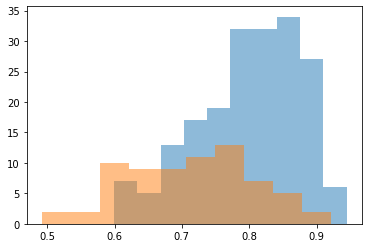

In [26]:
plt.hist(aaa.auc,alpha=0.5)
plt.hist(bbb.auc,alpha=0.5)
# plt.hist(ccc.auc,alpha=0.5)

(array([ 1.,  1.,  9., 12., 15., 10., 10.,  7.,  4.,  1.]),
 array([0.18429945, 0.23379335, 0.28328725, 0.33278115, 0.38227505,
        0.43176894, 0.48126284, 0.53075674, 0.58025064, 0.62974453,
        0.67923843]),
 <BarContainer object of 10 artists>)

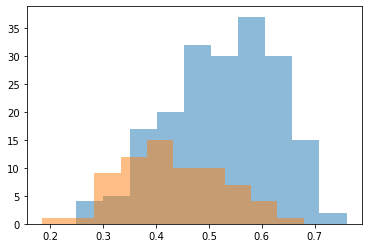

In [27]:
plt.hist(aaa.pwm*aaa.auc,alpha=0.5)
plt.hist(bbb.pwm*bbb.auc,alpha=0.5)
# plt.hist(ccc.auc,alpha=0.5)

In [28]:


aaa=aa[aa['Call']=='MethylPlus']
www=aaa[['TF','cell']]
www['name']=www['cell']+'_'+www['TF']
pd.unique(www.name)
# www.sort_values(['cell','TF']).to_csv('33_methylPlusbench.txt',sep='\t')

array(['A549_CEBPB', 'GM12878_CEBPB', 'HeLa_CEBPB', 'HepG2_CEBPB',
       'K562_CEBPB', 'HepG2_CEBPG', 'K562_CEBPG', 'SKNSH_GATA3',
       'HepG2_HLF', 'K562_IRF2', 'K562_KLF13', 'K562_KLF16', 'HepG2_KLF6',
       'K562_MEIS2', 'HepG2_NR2F6', 'A549_NR3C1', 'HeLa_NR3C1',
       'K562_PKNOX1', 'A549_RFX5', 'HeLa_RFX5', 'HepG2_RFX5',
       'SKNSH_RFX5', 'A549_SP1', 'GM12878_SP1', 'HepG2_SP1', 'K562_SP1',
       'HepG2_SP2', 'K562_SP2', 'HepG2_THRB', 'A549_ZBTB33',
       'GM12878_ZBTB33', 'HepG2_ZBTB33', 'K562_ZBTB33', 'SKNSH_ZBTB33',
       'K562_ZNF740'], dtype=object)

<AxesSubplot:xlabel='auc', ylabel='yes'>

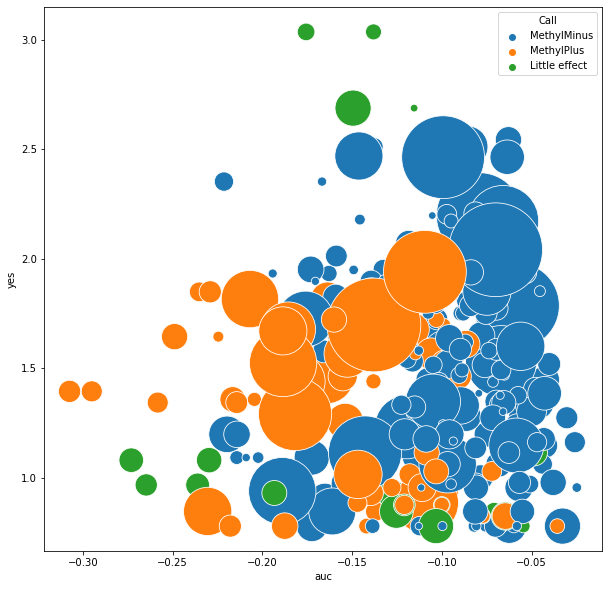

In [29]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=ddd, x=np.log10(aa['auc']), y=np.log10(aa.yes), hue="Call",
#     sizes=(200, 200), legend='full',
    s=ddd['size']
)

<AxesSubplot:xlabel='size', ylabel='yes'>

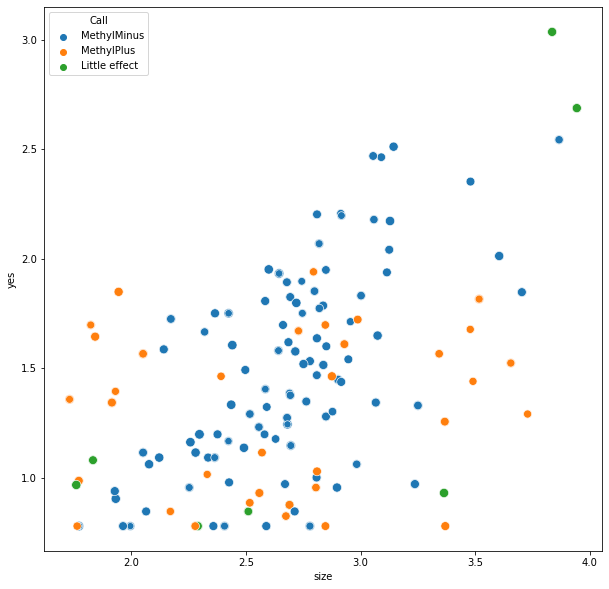

In [30]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=ddd, x=np.log10(aa['size']), y=np.log10(aa.yes), hue="Call",
#     sizes=(200, 200), legend='full',
    s=ddd['auc']*100
)

In [31]:
del allboxxx11['size'], allboxxx11['yes']
allboxxx11[allboxxx11['auc']<0.5 & allboxxx11['pwm']<0.5]

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [32]:
allboxxx11[allboxxx11['pwm']<0.5]

pwm     value       auc
methyl region   cell    TF                                   
array  body     A549    BHLHE40  0.495767  0.899653  0.899653
                        CEBPB    0.464354  0.447948  0.447948
                        MAX      0.435196  0.893182  0.893182
                        SP1      0.455147  0.761671  0.761671
                GM12878 CBFB     0.496158  0.824468  0.824468
...                                   ...       ...       ...
wg     promoter K562    MAZ      0.491532  0.625414  0.625414
                        MBD2     0.441067  0.687910  0.687910
                        NEUROD1  0.494329  0.771394  0.771394
                        ZNF740   0.304400  0.605452  0.605452
                SKNSH   JUND     0.465986  0.833333  0.833333

[108 rows x 3 columns]

In [120]:
allbox

TF     cell      TSS  size  yes variable     AUROC
680     NRF1  GM12878  TSS1500  3225  119      pwm  0.732606
681     E2F4  GM12878  TSS1500  2148    9      pwm  0.706405
682    CREB3     K562  TSS1500   388    6      pwm  0.534686
683     USF2    HepG2  TSS1500  1643  383      pwm  0.754080
684     E2F8     K562  TSS1500   498    7      pwm  0.473814
..       ...      ...      ...   ...  ...      ...       ...
445    FOSL1     K562        0   638   35      pwm  0.690808
446   NFE2L2    HepG2        0   935   20      pwm  0.789481
447  SMARCC1     A549        0  1935   18      pwm  0.718904
448     NFYB     K562        0   446   13      pwm  0.678806
449     MAFF     K562        0   745   68      pwm  0.772634

[1067 rows x 7 columns]

In [123]:
# t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
def ttest_plot_TSS(allboxxx,datatype,regions=[]):
    allbox=allboxxx[allboxxx['variable']==datatype]
    aa=allbox[allbox['TSS']=='TSS1500']
    bb=allbox[allbox['TSS']=='TSS200']
    cc=allbox[allbox['TSS']=="5'UTR"]
    dd=allbox[allbox['TSS']=='ExonBnd']
    ee=allbox[allbox['TSS']=="3'UTR"]
    ff=allbox[allbox['TSS']=='0']

    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())

    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())

    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())

    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())

    # initialise data of lists. 
    ttest = {'TSS1500 ttest':[1,t0a,t0b,t1a,t1b,t2a], 
             "TSS200 ttest":[0,1,t2b,t3a,t3b,t4a],
            "5'UTR ttest":[0,0,1,t4b,t5a,t5b],
             "ExonBnd ttest":[0,0,0,1,t6a,t6b],
            "3'UTR ttest":[0,0,0,0,1,t7a],
            '0 ttest':[0,0,0,0,0,1]}

    pval = {'TSS1500 pval':[1,p0a,p0b,p1a,p1b,p2a], 
             "TSS200 pval":[0,1,p2b,p3a,p3b,p4a],
            "5'UTR pval":[0,0,1,p4b,p5a,p5b],
             "ExonBnd pval":[0,0,0,1,p6a,p6b],
            "3'UTR pval":[0,0,0,0,1,p7a],
            '0 pval':[0,0,0,0,0,1]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['TSS1500','TSS200', "3'UTR", 'ExonBnd',"5'UTR",'0']) 
    df_pval = pd.DataFrame(pval, index =['TSS1500','TSS200', "3'UTR", 'ExonBnd',"5'UTR",'0']) 
    df_ttest=df_ttest.iloc[::-1]
    df_pval=df_pval.iloc[::-1]
    # df_ttest=np.transpose(df_ttest)
    # df_pval=np.transpose(df_pval)
    # df_ttest = pd.DataFrame(ttest, index =['0',"5'UTR", 'ExonBnd', "3'UTR", 'TSS200','TSS1500']) 
    # df_pval = pd.DataFrame(pval, index =['0',"5'UTR", 'ExonBnd', "3'UTR", 'TSS200','TSS1500']) 
    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm


### ST4

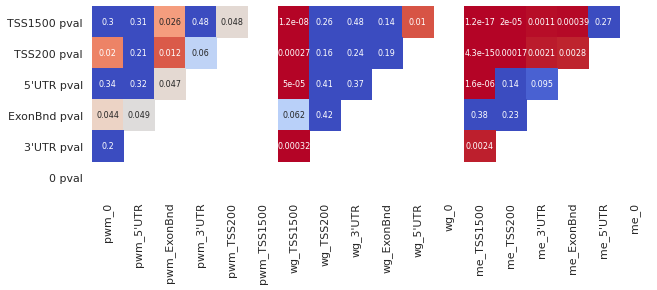

In [124]:
## try rotating
## https://gist.github.com/slowkow/5797728

df_pval_pwm=ttest_plot_TSS(allbox00,'pwm')
df_pval_wg=ttest_plot_TSS(allbox00,'wg')
df_pval_wg.index=['wg_TSS1500','wg_TSS200',"wg_3'UTR",'wg_ExonBnd',"wg_5'UTR",'wg_0']
df_pval_me=ttest_plot_TSS(allbox00,'array')
df_pval_me.index=['me_TSS1500','me_TSS200',"me_3'UTR",'me_ExonBnd',"me_5'UTR",'me_0']

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:6,0:6],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T/2,annot=True,mask=mask.T,cbar=False,
                     vmax=.1, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

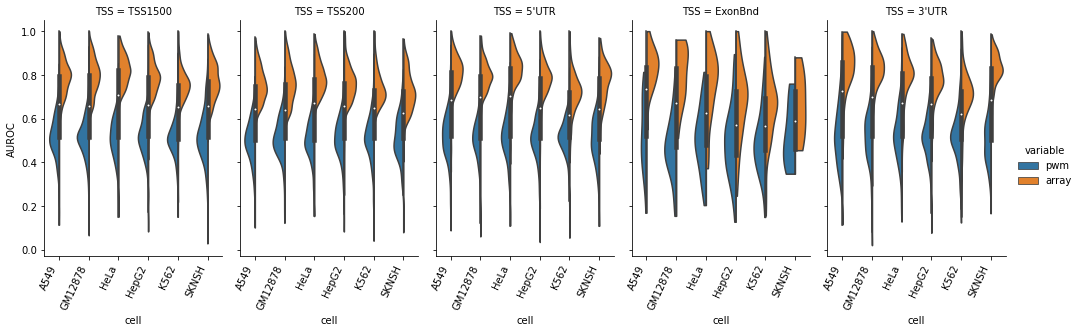

In [80]:
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']

aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]

allbox00=pd.concat([aa,bb,cc,dd,ee])

chart=sns.catplot(x="cell", y=method.upper(),hue="variable", col="TSS",data=allbox00, kind="violin",
                  split=True,height=4, aspect=.7,cut=0)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

## promoter v body

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy 

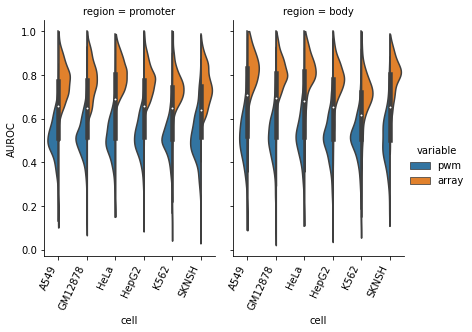

In [81]:
allbox00=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['pwm','array'])
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']

aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
aa['region']='promoter'
bb['region']='promoter'
cc['region']='body'
dd['region']='body'
ee['region']='body'
allbox00=pd.concat([aa,bb,cc,dd,ee])

chart=sns.catplot(x="cell", y=method.upper(),hue="variable", col="region",data=allbox00, kind="violin",
                  split=True,height=4, aspect=.7,cut=0)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/udd/redmo/.conda/envs/mypy3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy 

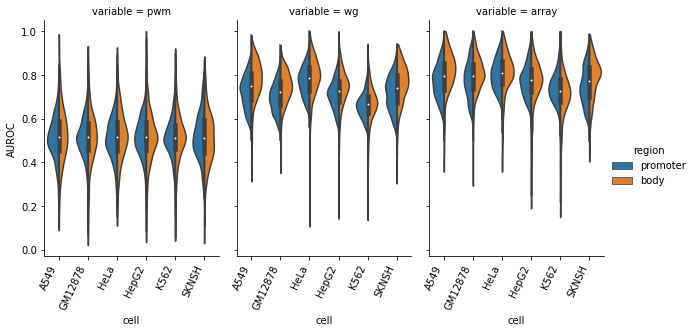

In [85]:
allbox00=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['pwm','wg','array'])
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']

aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
aa['region']='promoter'
bb['region']='promoter'
cc['region']='body'
dd['region']='body'
ee['region']='body'
allbox00=pd.concat([aa,bb,cc,dd,ee])

chart=sns.catplot(x="cell", y=method.upper(),hue="region", col="variable",data=allbox00, kind="violin",
                  split=True,height=4, aspect=.7,cut=0)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

## focus on TSS200

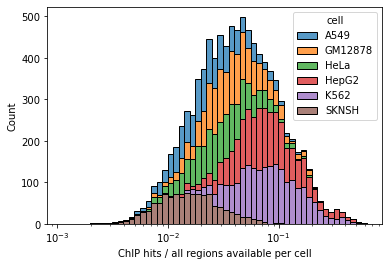

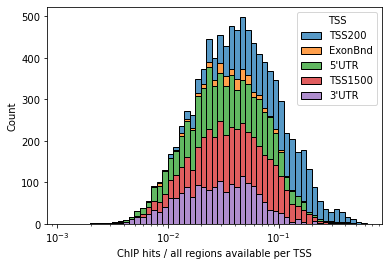

In [46]:
# a=plt.hist(np.log10(allbox['yes']),log=True,bins=100,alpha=5)
# a=plt.hist(np.log10(aa['yes']),log=True,bins=100,alpha=.5)
# a=plt.hist(np.log10(bb['yes']),log=True,bins=100,alpha=.5)
# a=plt.hist(np.log10(cc['yes']),log=True,bins=100,alpha=.5)
# a=plt.hist(np.log10(dd['yes']),log=True,bins=100,alpha=.5)
# a=plt.hist(np.log10(ee['yes']),log=True,bins=100,alpha=.5)
g=sns.histplot(allbox11, x=(allboxx11.yes)/allboxx11['size'], hue="cell", multiple="stack",log_scale=True)
g.set_xlabel('ChIP hits / all regions available per cell')
plt.show()
h=sns.histplot(allbox11, x=(allboxx11.yes)/allboxx11['size'], hue="TSS", multiple="stack",log_scale=True)
h.set_xlabel('ChIP hits / all regions available per TSS')
plt.show()
# sns.histplot(allbox22, x=np.log10(allboxx22.yes), hue="TSS", multiple="stack")
# plt.title('wgbs')
# plt.show()
# sns.histplot(allbox33, x=np.log10(allboxx33.yes), hue="TSS", multiple="stack")
# plt.title('array')
# plt.show()

## WGBS read depth

In [72]:
A549=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/A549both.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(A549[A549['reads']>10].size/A549.size,'=',A549[A549['reads']>10].size,'/',A549.size)

GM12878=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/GM12878both.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(GM12878[GM12878['reads']>10].size/GM12878.size)

HeLa=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/HeLaboth.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(HeLa[HeLa['reads']>10].size/HeLa.size)

HepG2=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/HepG2both.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(HepG2[HepG2['reads']>10].size/HepG2.size)

K562=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/K562both.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(K562[K562['reads']>10].size/K562.size)

SKNSH=pd.read_csv('data/MotifPipeline/ENCODE/wgbsin/SKNSHboth.txt',sep='\t',usecols=[3],names=['reads'])
# print()
print(SKNSH[SKNSH['reads']>10].size/SKNSH.size)

0.5396518395703626
0.6714301294821499
0.6977736662366679
0.6014958318605518
0.6588440156999931
0.482484228583152


In [75]:
print(A549[A549['reads']>10].size/A549.size,'=',A549[A549['reads']>10].size,'/',A549.size)
print(GM12878[GM12878['reads']>10].size/GM12878.size,'=',GM12878[GM12878['reads']>10].size,'/',GM12878.size)
print(HeLa[HeLa['reads']>10].size/HeLa.size,'=',HeLa[HeLa['reads']>10].size,'/',HeLa.size)
print(HepG2[HepG2['reads']>10].size/HepG2.size,'=',HepG2[HepG2['reads']>10].size,'/',HepG2.size)
print(K562[K562['reads']>10].size/K562.size,'=',K562[K562['reads']>10].size,'/',K562.size)
print(SKNSH[SKNSH['reads']>10].size/SKNSH.size,'=',SKNSH[SKNSH['reads']>10].size,'/',SKNSH.size)


0.5396518395703626 = 31627874 / 58607924
0.6714301294821499 = 39351126 / 58607924
0.6977736662366679 = 40895066 / 58607924
0.6014958318605518 = 35252422 / 58607924
0.6588440156999931 = 38613480 / 58607924
0.482484228583152 = 28277399 / 58607924


## CREB CEBPa analysis

In [233]:
import shutil

# indir='data/MotifPipeline/compare/sthlm_motif_0_QCbeta/'
# # indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta/'
# traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
# #     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
# indices = [i for i, s in enumerate(traces) if 'CREB' in s]
# # www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR"]
# aurocs = pd.DataFrame()

# dir=(indir+'/test/')
# if os.path.exists(dir):
#     shutil.rmtree(dir)
# os.makedirs(dir)

# # trace=traces[0]
# for i,trace in enumerate(indices):
#     trace=traces[indices[i]]
# #     plt.subplot(2, 2, 3)
#     if 'pc' in trace:
#         combo=(trace).split('/')[7]

#     elif 'd/tmp' in trace:
#         combo=(trace).split('/')[8]
#     else:
#         combo=(trace).split('/')[4]
# #             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
#     TF=combo.split('_')[1]
#     cell=combo.split('_')[0]
# #     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
# #     for TSS in enumerate(www):
#     Col1=os.path.basename(trace).split('_')[0] #cell
#     Col2='CEBPA'#os.path.basename(trace).split('_')[1] #TF
# #         TSS=TSS[1]
# # #         if Col1=='GM12878':
# # #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
# # #             cc=data.body.str.find(TSS)
# # #             cc[cc!=-1]=TSS
# # #             data['TSS']=cc
# # #             print(Col2+'in'+Col1)
# # #         else:
#     try:
#         data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,8,9,10,15,16],names=["chr", "start", "end",'pwm','hits',"W1",'me','ChIPTF','cell'])#,'body','TSS'])
    #                 break
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'CREB' in s]
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[i]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
    for TSS in enumerate(www):
        Col1=os.path.basename(trace).split('_')[0] #cell
        Col2='CEPBA'#os.path.basename(trace).split('_')[1] #TF
        TSS=TSS[1]
#         if Col1=='GM12878':
#             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
#             cc=data.body.str.find(TSS)
#             cc[cc!=-1]=TSS
#             data['TSS']=cc
#             print(Col2+'in'+Col1)
#         else:
        try:
            data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','body','TSS','ChIPTF'])
#                 break
        except:
            pass
        data=data[data['TSS']==TSS]

    #     data=data[data['TSS']==TSS]


        table2=[]
        tbl=[]
        tmpTBL2=[]
        tmpTBL=[]
        table3=[]
        tblC=[]
        tmpTBLC=[]
        data.pwm=data.pwm.astype('float')
        data.pwm=(data['pwm']-data['pwm'].min())/(data['pwm'].max()-data['pwm'].min())
        data=data.fillna(0)
        data.ChIPTF=data.ChIPTF.replace('.',0)
        # print(data.shape)
        data.ChIPTF[(data.ChIPTF==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)
        

        if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

            plt.plot([0, 1], [0, 1], 'k--')
            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
            roc_auc=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc2=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc2),
                     color='r', linestyle=':', linewidth=4)

            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, 1-data.me)
            roc_auc3=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc3),
                     color='y', linestyle=':', linewidth=4)



            Col1=cell
            Col2=TF
            Col3=roc_auc #motif auroc
            Col4=roc_auc2
            Col5=roc_auc3
#             Col55=roc_auc4
            Col6=data.shape[0]
            Col7=np.sum(data.ChIPTF)
            column = [Col1, Col2, Col3, Col4,Col5,Col6,Col7]
            print(column)
            column=np.transpose(pd.DataFrame((column)))
            column.to_csv(indir+'/test/_PRE_window_methyl_CREB-CEBPa.txt',mode='a',header=False,index=False)
            aurocs=pd.concat([aurocs,column],axis=0)
            print("AUROC calculated for "+TF+" in "+cell)
#     except:
#         pass

In [236]:
data2=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','body','TSS','ChIPTF'])
data2

chr      start        end       pwm            CG  hits   W1  \
0     chr10  100020647  100020667  11.46430  3.810000e-05     8    0   
1     chr10  100154902  100154922  17.70830  3.680000e-07    45   80   
2     chr10   10058552   10058572  12.63690  1.810000e-05    11    0   
3     chr10   10058558   10058578  14.06550  6.820000e-06    11    0   
4     chr10  100822720  100822740   9.95833  9.280000e-05     1    0   
...     ...        ...        ...       ...           ...   ...  ...   
6561   chrX    9352819    9352839  11.80950  3.070000e-05     9  100   
6562   chrX    9396949    9396969  13.72020  8.700000e-06     5    0   
6563   chrX   99394942   99394962  11.00000  5.050000e-05    26   35   
6564   chrY   12911938   12911958  10.38100  7.280000e-05    11   73   
6565   chrY   14834014   14834034  11.62500  3.450000e-05     1  100   

         array     body      TSS ChIPTF  
0     0.081003  OpenSea        0   BRD3  
1     0.877176  OpenSea  ExonBnd    NaN  
2     0.054735  OpenSea   TSS200    NaN  
3     0.054735  OpenSea   TSS200    NaN  
4     0.077799  N_Shelf        0    NaN  
...        ...      ...      ...    ...  
6561  0.935136  OpenSea        0    NaN  
6562  0.363485  OpenSea        0    NaN  
6563  0.366041  OpenSea        0    NaN  
6564  0.891957  OpenSea  TSS1500    NaN  
6565  0.828278  S_Shelf    5'UTR    NaN  

[6566 rows x 11 columns]

In [227]:
# indir='data/MotifPipeline/sthlm_motif_0_QCbeta/'

data=pd.read_csv(indir+'/test/_PRE_window_methyl_CREB-CEBPa.txt',sep=',',names=['cell','TF','pwm','wg','me','fullChIP','yesChIP'])
data['ChIP']='CEBPA'
data

FileNotFoundError: [Errno 2] No such file or directory: '../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta/test/_PRE_window_methyl_CREB-CEBPa.txt'

In [ ]:
import shutil

indir='data/MotifPipeline/sthlm_motif_0_QCbeta/'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'CREB' in s]
# www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[indices[i]]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
    else:
        combo=(trace).split('/')[3]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
#     for TSS in enumerate(www):
    Col1=os.path.basename(trace).split('_')[0] #cell
    Col2=os.path.basename(trace).split('_')[1] #TF
#         TSS=TSS[1]
# #         if Col1=='GM12878':
# #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
# #             cc=data.body.str.find(TSS)
# #             cc[cc!=-1]=TSS
# #             data['TSS']=cc
# #             print(Col2+'in'+Col1)
# #         else:
    try:
        data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,8,9,10,15,16],names=["chr", "start", "end",'pwm','hits',"W1",'me','ChIPTF','cell'])#,'body','TSS'])
    #                 break

    #     data=data[data['TSS']==TSS]


        table2=[]
        tbl=[]
        tmpTBL2=[]
        tmpTBL=[]
        table3=[]
        tblC=[]
        tmpTBLC=[]
        data.pwm=data.pwm.astype('float')
        data.pwm=(data['pwm']-data['pwm'].min())/(data['pwm'].max()-data['pwm'].min())
        data=data.fillna(0)
        data.ChIPTF=data.ChIPTF.replace('.',0)
        # print(data.shape)
        data.ChIPTF[(data.ChIPTF==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)
        

        if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

            plt.plot([0, 1], [0, 1], 'k--')
            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
            roc_auc=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc2=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc2),
                     color='r', linestyle=':', linewidth=4)

            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, 1-data.me)
            roc_auc3=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc3),
                     color='y', linestyle=':', linewidth=4)



            Col1=cell
            Col2=TF
            Col3=roc_auc #motif auroc
            Col4=roc_auc2
            Col5=roc_auc3
#             Col55=roc_auc4
            Col6=data.shape[0]
            Col7=np.sum(data.ChIPTF)
            column = [Col1, Col2, Col3, Col4,Col5,Col6,Col7]
            print(column)
            column=np.transpose(pd.DataFrame((column)))
            column.to_csv(indir+'/test/_PRE_window_methyl_CREB.txt',mode='a',header=False,index=False)
            aurocs=pd.concat([aurocs,column],axis=0)
            print("AUROC calculated for "+TF+" in "+cell)
    except:
        pass

In [69]:
data=pd.read_csv(indir+'/test/_PRE_window_methyl_CREB.txt',sep=',',names=['cell','TF','pwm','wg','me','fullChIP','yesChIP'])
data['ChIP']='CREB'
data

cell       TF       pwm        wg        me  fullChIP  yesChIP  ChIP
0     K562    CREB1  0.773101  0.697768  0.811223      3683      144  CREB
1     A549    CREB1  0.688260  0.853113  0.906602      4953      334  CREB
2     K562    CREB3  0.584557  0.775594  0.853456      2327       12  CREB
3     K562  CREB3L1  0.632055  0.699815  0.783872      4731       45  CREB
4    HepG2    CREB1  0.783731  0.798074  0.847907      4642      913  CREB
5  GM12878    CREB1  0.697221  0.754441  0.874983      4480      176  CREB

In [ ]:
import shutil

indir='data/MotifPipeline/sthlm_motif_0_QCbeta/'
traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
#     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
indices = [i for i, s in enumerate(traces) if 'CEBPA' in s]
# www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR"]
aurocs = pd.DataFrame()

dir=(indir+'/test/')
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

# trace=traces[0]
for i,trace in enumerate(indices):
    trace=traces[indices[i]]
#     plt.subplot(2, 2, 3)
    if 'pc' in trace:
        combo=(trace).split('/')[7]

    elif 'd/tmp' in trace:
        combo=(trace).split('/')[8]
    else:
        combo=(trace).split('/')[3]
#             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
    TF=combo.split('_')[1]
    cell=combo.split('_')[0]
#     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
#     for TSS in enumerate(www):
    Col1=os.path.basename(trace).split('_')[0] #cell
    Col2=os.path.basename(trace).split('_')[1] #TF
#         TSS=TSS[1]
# #         if Col1=='GM12878':
# #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
# #             cc=data.body.str.find(TSS)
# #             cc[cc!=-1]=TSS
# #             data['TSS']=cc
# #             print(Col2+'in'+Col1)
# #         else:
    try:
        data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,8,9,10,15,16],names=["chr", "start", "end",'pwm','hits',"W1",'me','ChIPTF','cell'])#,'body','TSS'])
    #                 break

    #     data=data[data['TSS']==TSS]


        table2=[]
        tbl=[]
        tmpTBL2=[]
        tmpTBL=[]
        table3=[]
        tblC=[]
        tmpTBLC=[]
        data.pwm=data.pwm.astype('float')
        data.pwm=(data['pwm']-data['pwm'].min())/(data['pwm'].max()-data['pwm'].min())
        data=data.fillna(0)
        data.ChIPTF=data.ChIPTF.replace('.',0)
        # print(data.shape)
        data.ChIPTF[(data.ChIPTF==Col2)]=1
        data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
        data.ChIPTF=pd.to_numeric(data.ChIPTF)
        

        if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

            plt.plot([0, 1], [0, 1], 'k--')
            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, data.pwm)
            roc_auc=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc),
                     color='b', linestyle=':', linewidth=4)

            fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF, 1-(data.W1/100))
            roc_auc2=metrics.auc(fpr2, tpr2)
            plt.plot(fpr2, tpr2,
                     label='wgbs (area = {0:0.2f})'
                           ''.format(roc_auc2),
                     color='r', linestyle=':', linewidth=4)

            fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, 1-data.me)
            roc_auc3=metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label='pwm (area = {0:0.2f})'
                         ''.format(roc_auc3),
                     color='y', linestyle=':', linewidth=4)



            Col1=cell
            Col2=TF
            Col3=roc_auc #motif auroc
            Col4=roc_auc2
            Col5=roc_auc3
#             Col55=roc_auc4
            Col6=data.shape[0]
            Col7=np.sum(data.ChIPTF)
            column = [Col1, Col2, Col3, Col4,Col5,Col6,Col7]
            print(column)
            column=np.transpose(pd.DataFrame((column)))
            column.to_csv(indir+'/test/_PRE_window_methyl_CEBPa.txt',mode='a',header=False,index=False)
            aurocs=pd.concat([aurocs,column],axis=0)
            print("AUROC calculated for "+TF+" in "+cell)
    except:
        pass

In [70]:
data=pd.read_csv(indir+'/test/_PRE_window_methyl_CEBPa.txt',sep=',',names=['cell','TF','pwm','wg','me','fullChIP','yesChIP'])
data

cell       TF       pwm        wg        me  fullChIP  yesChIP
0     K562    CREB1  0.773101  0.697768  0.811223      3683      144
1     A549    CREB1  0.688260  0.853113  0.906602      4953      334
2     K562    CREB3  0.584557  0.775594  0.853456      2327       12
3     K562  CREB3L1  0.632055  0.699815  0.783872      4731       45
4    HepG2    CREB1  0.783731  0.798074  0.847907      4642      913
5  GM12878    CREB1  0.697221  0.754441  0.874983      4480      176

# prepare ~GM12878 data for milipeed benchmark

In [110]:

LCL=pd.read_csv('data/GTEx_data/sample_tissue_order.txt',sep='\t',header=None,names=['sample','tissue'])
c=LCL[LCL['tissue']=='cells_ebv-transformed_lymphocytes'].index
s=LCL[LCL['tissue']=='cells_ebv-transformed_lymphocytes']['sample']

In [72]:
exp=pd.read_csv('data/GTEx_data/expression.txt',sep='\t',usecols=c)

In [74]:
exp.to_csv('LCL.txt',sep='\t',index=False,header=True)

In [237]:
exp

11.3548404203779  3.0712030808365  3.0378637448411  0.160518503854737  \
0              1.386054         0.103398         0.259710           0.160519   
1             10.166977        11.167060        11.159552          11.202064   
2              8.641806         9.938683        10.072784           9.991150   
3              7.282225        10.080375         9.872243          10.297816   
4              6.619981        10.994426        13.127499          10.516602   
...                 ...              ...              ...                ...   
30237          6.959361         7.731944         7.785321           7.258855   
30238          5.439643         0.103398         0.259710           0.160519   
30239          4.122281         5.711423         5.201400           5.850641   
30240         11.619556        10.171231        10.080771           9.931040   
30241          5.412235         0.103398         0.259710           0.160519   

       3.88475332979786  0.30005310057186  3.45397008867939  3.16344219524379  \
0              0.316328          0.300053          0.362871          0.315804   
1             11.016082         11.037905         11.315441         11.149726   
2             10.241763         10.620870         10.183609         10.345304   
3              9.977442          9.820341         10.044373         10.060643   
4             12.038634         11.691250         10.977872         12.145283   
...                 ...               ...               ...               ...   
30237          7.202452          7.164821          7.508711          7.876936   
30238          0.316328          0.300053          0.362871          1.892597   
30239          5.822787          5.087110          4.898755          5.808345   
30240          9.842902         10.299713         10.562001         10.662440   
30241          0.316328          0.300053          0.362871          0.315804   

       3.14222702487199  3.7418060819692  ...  2.52614271664228  \
0              2.370295         0.198969  ...          0.137816   
1             11.387064        11.098072  ...         11.005610   
2              9.776282        10.290952  ...          9.949255   
3              9.216573        10.113358  ...         10.342871   
4             14.050249        11.482095  ...         12.695031   
...                 ...              ...  ...               ...   
30237          7.916865         7.651946  ...          7.446149   
30238          2.370295         0.198969  ...          0.137816   
30239          5.002037         5.183222  ...          5.001337   
30240         10.629653        10.593571  ...         10.320611   
30241          0.293083         0.198969  ...          0.137816   

       3.52304619182936  2.16764816097517  4.02039888634958  2.06037609367237  \
0              1.620809          0.067322          0.607873          0.188891   
1             11.201880         11.117979         10.910873         10.881645   
2             10.221029         10.209793          9.826939         10.495024   
3             10.222964          9.953627         10.140705         10.318780   
4             11.485978         12.286258         11.870320         12.175785   
...                 ...               ...               ...               ...   
30237          7.206369          7.474436          7.371167          7.633651   
30238          0.226999          0.067322          0.068783          2.060376   
30239          5.459008          5.728898          5.961808          5.869092   
30240         10.538731         10.104239         10.039995         10.109023   
30241          0.226999          0.067322          1.299416          0.188891   

       1.81528463309291  3.85242318366065  3.08070787512225  3.23443098386304  \
0              0.128322          0.161161          0.129970          1.533588   
1             11.058104         10.752603         11.195953         10.985948   
2              9.976201         10.552870         10

(array([14., 13., 13., 13., 13., 13., 13., 13., 13., 14.]),
 array([  0. ,  13.1,  26.2,  39.3,  52.4,  65.5,  78.6,  91.7, 104.8,
        117.9, 131. ]),
 <BarContainer object of 10 artists>)

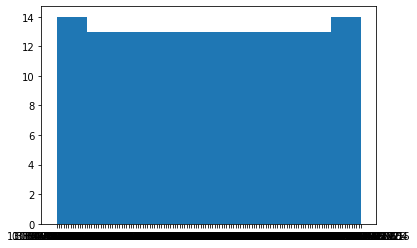

In [182]:
plt.hist(exp)

In [176]:
abhi_exp=pd.read_csv('data/GTEx_data/abhi_LCL.txt',sep=' ',nrows=3).T
abhi_exp['col']=list(range(1,abhi_exp.shape[0]+1))
abhi_exp=abhi_exp.T
j=abhi_exp[s].iloc[3]

In [179]:
a_LCL=pd.read_csv('data/GTEx_data/abhi_LCL.txt',sep=' ',usecols=j.astype(int))
a_LCL

GTEX-11EM3-0001-SM-5Q5BD  GTEX-11EMC-0002-SM-5Q5DO  \
ENSG00000227232.4                  8.048740                  9.169673   
ENSG00000238009.2                  2.100520                  1.713828   
ENSG00000233750.3                  2.386881                  4.697423   
ENSG00000237683.5                  9.663511                 10.450883   
ENSG00000268903.1                  6.712067                  7.867617   
...                                     ...                       ...   
ENSG00000210164.1                  1.586099                  2.249422   
ENSG00000198840.2                 15.112683                 15.019794   
ENSG00000198786.2                 18.177325                 17.585227   
ENSG00000198695.2                 16.301525                 15.476003   
ENSG00000198727.2                 18.034948                 17.178569   

                   GTEX-11EQ9-0002-SM-5QGQ1  GTEX-11I78-0001-SM-5Q5BE  \
ENSG00000227232.4                  8.543273                  8.667030   
ENSG00000238009.2                  3.543995                  2.417747   
ENSG00000233750.3                  0.160519                  1.896961   
ENSG00000237683.5                  7.032934                  6.627600   
ENSG00000268903.1                  2.674501                  2.908373   
...                                     ...                       ...   
ENSG00000210164.1                  1.284678                  1.896961   
ENSG00000198840.2                 14.818955                 15.214560   
ENSG00000198786.2                 17.503469                 18.346821   
ENSG00000198695.2                 15.378607                 16.405371   
ENSG00000198727.2                 16.930355                 17.585227   

                   GTEX-11OC5-0004-SM-5S2O6  GTEX-11P7K-0003-SM-5S2OU  \
ENSG00000227232.4                  9.317924                  9.130945   
ENSG00000238009.2                  3.164278                  3.453970   
ENSG00000233750.3                  0.300053                  0.362871   
ENSG00000237683.5                  9.117384                  9.224249   
ENSG00000268903.1                  6.684068                  7.940712   
...                                     ...                       ...   
ENSG00000210164.1                  0.300053                  0.362871   
ENSG00000198840.2                 14.478794                 15.171063   
ENSG00000198786.2                 16.725272                 17.429669   
ENSG00000198695.2                 14.955078                 16.620062   
ENSG00000198727.2                 16.585833                 17.235677   

                   GTEX-11TT1-0004-SM-5S2NT  GTEX-11VI4-0001-SM-5S2OI  \
ENSG00000227232.4                  9.510490                  9.086669   
ENSG00000238009.2                  4.274557                  2.370295   
ENSG00000233750.3                  3.646678                  0.293083   
ENSG00000237683.5                  9.422898                  9.494683   
ENSG00000268903.1                  7.760345                  8.153506   
...                                     ...                       ...   
ENSG00000210164.1                  0.315804                  2.370295   
ENSG00000198840.2                 14.431443                 14.519471   
ENSG00000198786.2                 17.022705                 16.930355   
ENSG00000198695.2                 15.675747                 15.791212   
ENSG00000198727.2                 17.178569                 16.975604   

                   GTEX-11ZTT-0002-SM-5S2PA  GTEX-1211K-0001-SM-5S2P9  ...  \
ENSG00000227232.4                  9.172463                  9.132807  ...   
ENSG00000238009.2                  2.894023                  2.083446  ...   
ENSG00000233750.3                  2.567705                  3.490400  ...   
ENSG00000237683.5                  7.977239                 10.484338  ...   
ENSG00000268903.1                  5.660656                  9.270316  ...   
...                                     ...

In [180]:
a_LCL.to_csv('data/GTEx_data/abhi_LCL_sub.txt',sep='\t',index=False,header=True)

(array([14., 13., 13., 13., 13., 13., 13., 13., 13., 14.]),
 array([  0. ,  13.1,  26.2,  39.3,  52.4,  65.5,  78.6,  91.7, 104.8,
        117.9, 131. ]),
 <BarContainer object of 10 artists>)

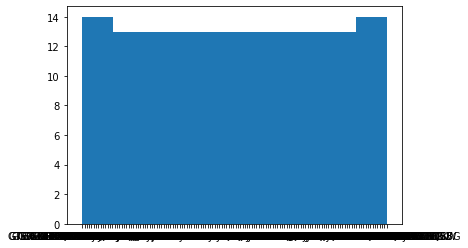

In [181]:
plt.hist(a_LCL)

In [336]:
cg_loc=pd.read_csv('data/MotifPipeline/ENCODE/methyl_array/cg_loc2.txt',sep='\t',header=None,names=['chr','start','end','cg'])
mapid=pd.read_csv('netZooPy/tests/milipeed/MotifPrior_CGmap.txt',sep='\t',names=['source','target','cg'])


In [337]:
mdata=cg_loc.merge(mapid,left_on='cg', right_on='cg')


In [343]:
mdata.to_csv('data/MotifPipeline/ENCODE/methyl_array/cg_gene_loc.txt',sep='\t',index=False,header=False)

# test diff models

In [396]:

arr=(data.pwm*(1-data.array))

# arr2 = np.arange(10)
# rng = np.random.default_rng()


# arr=
rng.shuffle(arr.values)
# arr

In [71]:
# 
def test_model(indir,eq,model_name):
    rng = np.random.default_rng()
    traces = [log for log in glob.glob(indir+'/*') if not os.path.isdir(log)]
    #     os.remove(indir+'/test/camb_PRE_window_methyl.txt')
    indices = [i for i, s in enumerate(traces) if 'txt' not in s]
    www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
    aurocs = pd.DataFrame()

    dir=(indir+model_name) ## old dir for straight 1-methyl is /test/ , this is pwm * 1-methyl
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)

    # trace=traces[0]
    for i,trace in enumerate(indices):
        trace=traces[i]
    #     plt.subplot(2, 2, 3)
        if 'pc' in trace:
            combo=(trace).split('/')[7]

        elif 'd/tmp' in trace:
            combo=(trace).split('/')[8]
    #             combo=trace.split('/')[8] ##change this from 7 to 8 with tmp1 dir from tmp0
        TF=combo.split('_')[1]
        cell=combo.split('_')[0]
    #     data=pd.read_csv(trace,sep='\t',names=['chr','start','end','pwm','CG','ChIPTF','array','location'])
        for TSS in enumerate(www):
            Col1=os.path.basename(trace).split('_')[0] #cell
            Col2=os.path.basename(trace).split('_')[1] #TF
            TSS=TSS[1]
    #         if Col1=='GM12878':
    #             data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,13],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','xxx','body','ChIPTF'])
    #             cc=data.body.str.find(TSS)
    #             cc[cc!=-1]=TSS
    #             data['TSS']=cc
    #             print(Col2+'in'+Col1)
    #         else:
            try:
                data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'pwm','CG','hits',"W1",'array','body','TSS','ChIPTF'])
    #                 break
            except:
                pass
            data=data[data['TSS']==TSS]


            table2=[]
            tbl=[]
            tmpTBL2=[]
            tmpTBL=[]
            table3=[]
            tblC=[]
            tmpTBLC=[]
            data.pwm=(data.pwm-data.pwm.min())/(data.pwm.max()-data.pwm.min())
            data=data.fillna(0)
            data.ChIPTF=data.ChIPTF.replace('.',0)
            # print(data.shape)
            data.ChIPTF[(data.ChIPTF==Col2)]=1
            data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
            data.ChIPTF=pd.to_numeric(data.ChIPTF)

            if np.sum(data.ChIPTF)>5: # and np.sum(data_nonCG.ChIPTF)>5:

                plt.plot([0, 1], [0, 1], 'k--')
                fpr, tpr, thresholds = metrics.roc_curve(data.ChIPTF, (data.pwm))
                roc_auc=metrics.auc(fpr, tpr)
                plt.plot(fpr, tpr,
                         label='wgbs (area = {0:0.2f})'
                               ''.format(roc_auc),
                         color='b', linestyle=':', linewidth=4)
                eq1=1-(data.W1/100)
                eq2=1-(data.array)
                fprA, tprA, thresholds = metrics.roc_curve(data.ChIPTF, eq1)
                roc_aucA=metrics.auc(fprA, tprA)
                plt.plot(fprA, tprA,
                         label='wgbs (area = {0:0.2f})'
                               ''.format(roc_aucA),
                         color='b', linestyle=':', linewidth=4)
                fprB, tprB, thresholds = metrics.roc_curve(data.ChIPTF, eq2)
                roc_aucB=metrics.auc(fprB, tprB)
                plt.plot(fprB, tprB,
                         label='wgbs (area = {0:0.2f})'
                               ''.format(roc_aucB),
                         color='b', linestyle=':', linewidth=4)
                
                
#                 x = var('x')
#                 y = var('y')
#                 exp=sympify(eq)
                TEST1 = np.sqrt(eq1)*(eval(eq))#exp.subs(x,eq1)
                fpr2, tpr2, thresholds = metrics.roc_curve(data.ChIPTF,(TEST1))
                roc_auc2=metrics.auc(fpr2, tpr2)
                plt.plot(fpr2, tpr2,
                         label='wgbs (area = {0:0.2f})'
                               ''.format(roc_auc2),
                         color='r', linestyle=':', linewidth=4)
                
#                 exp=sympify(eq)
                TEST2 = np.sqrt(eq2)*eval(eq) #exp.subs(x,eq2)
                fpr3, tpr3, thresholds = metrics.roc_curve(data.ChIPTF,(TEST2))
                roc_auc3=metrics.auc(fpr3, tpr3)
                plt.plot(fpr3, tpr3,
                         label='array (area = {0:0.2f})'
                             ''.format(roc_auc3),
                         color='g', linestyle=':', linewidth=4)
                
                rng.shuffle(TEST2.values) #***
                fpr4, tpr4, thresholds = metrics.roc_curve(data.ChIPTF,TEST2)
                roc_auc4=metrics.auc(fpr4, tpr4)
                plt.plot(fpr4, tpr4,
                         label='array (area = {0:0.2f})'
                             ''.format(roc_auc4),
                         color='g', linestyle=':', linewidth=4)



    #             plt.xlabel('False Positive Rate')
    #             plt.ylabel('True Positive Rate')
    #             plt.title('AUROC for '+TF+' in '+cell)
    #             plt.legend(loc="best")

    #             plt.show()

                Col1=cell
                Col2=TF
                Col3=roc_auc #motif auroc
                Col4=roc_auc2
                Col5=roc_auc3
                Col6=data.shape[0]
                Col7=np.sum(data.ChIPTF)
                column = [Col1, Col2, Col3, roc_aucA,roc_aucB,Col4,Col5,roc_auc4,Col6,Col7]
                print(column)
                column=np.transpose(pd.DataFrame((column)))
                column.to_csv(indir+model_name+TSS+'_PRE_window_methyl.txt',mode='a',header=False,index=False)
                aurocs=pd.concat([aurocs,column],axis=0)
                print("AUROC calculated for "+TF+" in "+cell)
    #     except:
    #         pass

In [7]:
def plot_allPredScore(indir,agg_meth='mean',method='auroc',region=None,depth=None):
    allbox = pd.DataFrame()
    www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
    
    traces= glob.glob(indir+'*_PRE_window_methyl.txt',recursive = True)
    # indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
    method='AUROC'

    for i,trace in enumerate(traces):
    #     trace=traces[jac]
        TSS=(traces[i]).split('/')[9]
        TSS=(TSS).split('_')[0]
    #     region=(trace).split('/')[5]
    #     depth=(trace).split('/')[6]
        meltbox=pd.read_csv(traces[i],sep=',',names=['cell','TF','pwm','wg','array','alt_wg','alt_array','rand','size','yes'])
        meltbox['TSS']=TSS
    #     print(pd.unique(meltbox.cell))
    #     meltbox['buffer']=buffer

    #     meltbox['depth']=depth
        allbox=pd.concat([allbox,meltbox],axis=0)
    allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
    allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
    return allbox,allbox00, allbox11

In [13]:
# !rm -rf ../../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta/methylhalf_div_halfpwm/

In [113]:
# import shutil
# model_name='/pwm_multi_half/'
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
eq="(data.pwm)"
model_name='/m^pwm/'
test_model(indir,eq,model_name)
allbox,allbox00, allbox11=plot_allPredScore(indir+model_name,agg_meth='mean',method='auroc',region=None,depth=None)

df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc
allboxxx22=allbox11.groupby(['variable','TSS','TF','cell']).mean()
allboxxx22=allboxxx22.reset_index()
yyy=allboxxx22[allboxxx22['variable']=='alt_array']
xxx=allboxxx22[allboxxx22['variable']=='alt_wg']

allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
# ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb])

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=aa, x="pwm", y='value', hue="Call",style="variable",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')

allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
# allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
# allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])
plt.figure(figsize=(8, 5))
plt.grid(False)
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']
del allbox00['value']
aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
ff=allbox00[allbox00['TSS']==www[5]]
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

j=sns.boxplot(x='TSS',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

aa=allbox00[allbox00['cell']=='A549']
bb=allbox00[allbox00['cell']=='GM12878']
cc=allbox00[allbox00['cell']=='Hela']
dd=allbox00[allbox00['cell']=='HepG2']
ee=allbox00[allbox00['cell']=='K562']
ff=allbox00[allbox00['cell']=='SKNSH']
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])
plt.figure(figsize=(8, 5))
plt.grid(False)
j=sns.boxplot(x='cell',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

NameError: name 'shutil' is not defined

In [8]:
# import shutil
# model_name='/pwm_multi_half/'
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
eq="1/np.square(data.pwm)"
model_name='/m^1_ov_squarepwm/'
test_model(indir,eq,model_name)
allbox,allbox00, allbox11=plot_allPredScore(indir+model_name,agg_meth='mean',method='auroc',region=None,depth=None)

df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc
allboxxx22=allbox11.groupby(['variable','TSS','TF','cell']).mean()
allboxxx22=allboxxx22.reset_index()
yyy=allboxxx22[allboxxx22['variable']=='alt_array']
xxx=allboxxx22[allboxxx22['variable']=='alt_wg']

allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
# ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb])

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=aa, x="pwm", y='value', hue="Call",style="variable",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')

allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
# allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
# allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])
plt.figure(figsize=(8, 5))
plt.grid(False)
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']
del allbox00['value']
aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
ff=allbox00[allbox00['TSS']==www[5]]
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

j=sns.boxplot(x='TSS',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

aa=allbox00[allbox00['cell']=='A549']
bb=allbox00[allbox00['cell']=='GM12878']
cc=allbox00[allbox00['cell']=='Hela']
dd=allbox00[allbox00['cell']=='HepG2']
ee=allbox00[allbox00['cell']=='K562']
ff=allbox00[allbox00['cell']=='SKNSH']
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])
plt.figure(figsize=(8, 5))
plt.grid(False)
j=sns.boxplot(x='cell',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

NameError: name 'test_model' is not defined

['GM12878', 'NRF1', 0.7326061783374007, 0.6827676981932502, 0.7347935954806907, 0.6800499981061323, 0.6585140173261835, 0.4699997835579821, 3225, 119]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.7004286594231743, 0.6078834783847544, 0.6401198821710363, 0.6062147235921911, 0.570770707015684, 0.49559503207612793, 2523, 206]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.8100592166087374, 0.7375100937401257, 0.779719481796159, 0.7336042551697504, 0.6898091259113623, 0.49935048976582525, 2269, 78]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.6618574973413683, 0.8560439560439561, 0.870967741935484, 0.8441687344913151, 0.8161644806806096, 0.49567529244948594, 1098, 13]
AUROC calculated for NRF1 in GM12878
['GM12878', 'NRF1', 0.7088923511930523, 0.8237254392798408, 0.9272411206324476, 0.821799532588938, 0.8866960962520557, 0.5451830693326408, 3869, 18]
AUROC calculated for NRF1 in GM12878
['HepG2', 'ETV4', 0.49056603773584906, 0.8301886792452831, 0.871

AUROC calculated for AR in K562
['HepG2', 'HNF4A', 0.6670445344129554, 0.7752226720647774, 0.8255060728744938, 0.7730769230769231, 0.7323076923076923, 0.4644129554655871, 363, 38]
AUROC calculated for HNF4A in HepG2
['HepG2', 'HNF4A', 0.67425, 0.76525, 0.815, 0.7592500000000001, 0.72875, 0.53375, 157, 32]
AUROC calculated for HNF4A in HepG2
['HepG2', 'HNF4A', 0.6928018880293693, 0.7854333289628949, 0.8681001704470958, 0.7618329618460731, 0.7605873869149076, 0.5706044316244919, 292, 29]
AUROC calculated for HNF4A in HepG2
['HepG2', 'HNF4A', 0.5314900153609832, 0.7751536098310292, 0.8060675883256527, 0.7680491551459293, 0.7626728110599079, 0.4923195084485407, 200, 14]
AUROC calculated for HNF4A in HepG2
['HepG2', 'HNF4A', 0.6642488076311606, 0.7393254599136952, 0.7873325005677946, 0.7328384056325233, 0.7224903474903475, 0.5106603452191688, 685, 56]
AUROC calculated for HNF4A in HepG2
['SKNSH', 'RFX5', 0.612389229720518, 0.7407123381049762, 0.7813565098841172, 0.73406612133606, 0.75477164

AUROC calculated for BRCA1 in HepG2
['HepG2', 'BRCA1', 0.8769070735090152, 0.8810679611650486, 0.9306518723994452, 0.8762135922330098, 0.8439667128987517, 0.5041608876560333, 213, 7]
AUROC calculated for BRCA1 in HepG2
['GM12878', 'KLF5', 0.29655854430379747, 0.6643591772151899, 0.7443037974683545, 0.6639636075949368, 0.8020965189873418, 0.45296677215189873, 2538, 10]
AUROC calculated for KLF5 in GM12878
['GM12878', 'KLF5', 0.6896646320554146, 0.6168987037926068, 0.7432960702283794, 0.6164186269803169, 0.6598998696934366, 0.6726561964199986, 2090, 7]
AUROC calculated for KLF5 in GM12878
['SKNSH', 'REST', 0.5527836933373896, 0.6896257986005476, 0.6865226650441132, 0.675479160328567, 0.684027989047764, 0.4416184971098266, 884, 19]
AUROC calculated for REST in SKNSH
['SKNSH', 'REST', 0.5010515247108307, 0.7634069400630915, 0.7860147213459516, 0.7586750788643533, 0.740273396424816, 0.44952681388012616, 323, 6]
AUROC calculated for REST in SKNSH
['SKNSH', 'REST', 0.7973901098901098, 0.69130

['SKNSH', 'NRF1', 0.6708604954367666, 0.8021838331160365, 0.8307529335071708, 0.7989895697522815, 0.7878096479791395, 0.5623533246414602, 1206, 26]
AUROC calculated for NRF1 in SKNSH
['SKNSH', 'NRF1', 0.6656651126180674, 0.7991392185355614, 0.8249853677242269, 0.7836491886655363, 0.7746225881973037, 0.5047176475337047, 4177, 48]
AUROC calculated for NRF1 in SKNSH
['HepG2', 'NR2F6', 0.823512585812357, 0.7075228832951945, 0.806350114416476, 0.6956521739130435, 0.6639016018306636, 0.47339816933638446, 445, 8]
AUROC calculated for NR2F6 in HepG2
['HepG2', 'NR2F6', 0.3032258064516129, 0.6774193548387097, 0.7010752688172043, 0.6709677419354838, 0.7182795698924731, 0.5172043010752688, 161, 6]
AUROC calculated for NR2F6 in HepG2
['HepG2', 'NR2F6', 0.6722072476789458, 0.7532195268044324, 0.8295896975142258, 0.7376460017969452, 0.7619047619047619, 0.5908954776879305, 380, 9]
AUROC calculated for NR2F6 in HepG2
['HepG2', 'NR2F6', 0.5501114081996435, 0.7418003565062389, 0.8385918003565063, 0.72593

['K562', 'JUN', 0.8202409638554218, 0.7019277108433735, 0.7378313253012049, 0.6963855421686747, 0.6506024096385542, 0.536144578313253, 108, 25]
AUROC calculated for JUN in K562
['K562', 'JUN', 0.8017144826397863, 0.6670974411992764, 0.7389506332385629, 0.6519987938313087, 0.606487464461101, 0.46422417506677005, 391, 73]
AUROC calculated for JUN in K562
['HepG2', 'SMARCC1', 0.6038979248457657, 0.7578238923163209, 0.7151991026360067, 0.7749018508132361, 0.7280426247896803, 0.6117779024116656, 1793, 10]
AUROC calculated for SMARCC1 in HepG2
['SKNSH', 'MXI1', 0.5333821489132111, 0.8194889779559119, 0.8792739324803452, 0.8180322182827193, 0.8689455834746417, 0.5131378140897179, 2061, 65]
AUROC calculated for MXI1 in SKNSH
['SKNSH', 'MXI1', 0.5597224429260025, 0.8411197626992954, 0.8711001642036125, 0.8403517135441496, 0.8534350336352561, 0.4628423115631124, 680, 29]
AUROC calculated for MXI1 in SKNSH
['SKNSH', 'MXI1', 0.5919905533063428, 0.8487112010796221, 0.8976855600539811, 0.84369770580

AUROC calculated for NR3C1 in HeLa
['HeLa', 'NR3C1', 0.7387091943695716, 0.6852500748727164, 0.6649296196466008, 0.6305181191973646, 0.5303983228511531, 0.5057951482479783, 837, 42]
AUROC calculated for NR3C1 in HeLa
['A549', 'JUND', 0.6443406022845276, 0.7736240913811007, 0.8686396677050883, 0.735981308411215, 0.8219106957424716, 0.39460020768431986, 327, 6]
AUROC calculated for JUND in A549
['HepG2', 'BCL6', 0.43843843843843844, 0.6722972972972974, 0.7252252252252253, 0.6873123123123123, 0.7244744744744744, 0.26801801801801806, 228, 6]
AUROC calculated for BCL6 in HepG2
['HepG2', 'BCL6', 0.6142131979695432, 0.556562726613488, 0.6211022480058013, 0.5291878172588833, 0.5971718636693255, 0.3611312545322698, 401, 7]
AUROC calculated for BCL6 in HepG2
['K562', 'CEBPD', 0.583955223880597, 0.7033582089552239, 0.7621268656716418, 0.6879664179104478, 0.6958955223880597, 0.6343283582089552, 83, 16]
AUROC calculated for CEBPD in K562
['K562', 'CEBPD', 0.6142857142857143, 0.6642857142857143, 0.8

['K562', 'NFE2', 0.8550295857988166, 0.6816568047337277, 0.6877054569362262, 0.6569362261669953, 0.5383300460223537, 0.5278763971071664, 234, 39]
AUROC calculated for NFE2 in K562
['K562', 'NFE2', 0.8140760796897981, 0.5813410883807997, 0.5908610776841824, 0.5623880197887418, 0.44828185586308333, 0.4833667602620671, 1011, 180]
AUROC calculated for NFE2 in K562
['HepG2', 'CEBPB', 0.689538043478261, 0.7275815217391305, 0.7792119565217391, 0.6807065217391305, 0.6705163043478262, 0.5217391304347826, 87, 64]
AUROC calculated for CEBPB in HepG2
['HepG2', 'CEBPB', 0.6272727272727272, 0.8290909090909091, 0.9018181818181817, 0.8109090909090908, 0.8472727272727273, 0.6818181818181819, 36, 25]
AUROC calculated for CEBPB in HepG2
['HepG2', 'CEBPB', 0.5099111414900889, 0.5082023239917977, 0.5181134654818865, 0.5269993164730007, 0.521531100478469, 0.5536568694463431, 96, 77]
AUROC calculated for CEBPB in HepG2
['HepG2', 'CEBPB', 0.36363636363636365, 0.6417748917748918, 0.6125541125541125, 0.67099567

['K562', 'ATF7', 0.8343713046905794, 0.7234923137564052, 0.7835238470634608, 0.7097359085534095, 0.6387859676783603, 0.5430823807646827, 274, 59]
AUROC calculated for ATF7 in K562
['K562', 'ATF7', 0.8167767106842737, 0.6395558223289315, 0.8038715486194478, 0.6363295318127251, 0.6941776710684273, 0.5183073229291717, 166, 68]
AUROC calculated for ATF7 in K562
['K562', 'ATF7', 0.9000127697612055, 0.6852892350913038, 0.7258332269186567, 0.647682288341208, 0.5659558166262291, 0.5055548461243775, 232, 41]
AUROC calculated for ATF7 in K562
['K562', 'ATF7', 0.8742949234488316, 0.8011684125705076, 0.82232070910556, 0.7927074939564867, 0.685737308622079, 0.5894439967767929, 163, 17]
AUROC calculated for ATF7 in K562
['K562', 'ATF7', 0.865457857261136, 0.6282165921510184, 0.6405530717006127, 0.6065904951150852, 0.4948666997847326, 0.49491637688359, 709, 99]
AUROC calculated for ATF7 in K562
['HepG2', 'JUN', 0.749332264957265, 0.7556089743589743, 0.8021501068376068, 0.726963141025641, 0.6993856837

['HepG2', 'HNF4G', 0.6529503105590062, 0.7412008281573499, 0.8227225672877847, 0.7309782608695653, 0.7556935817805381, 0.5706521739130435, 334, 12]
AUROC calculated for HNF4G in HepG2
['HepG2', 'HNF4G', 0.7774431057563588, 0.8657965194109772, 0.8627844712182062, 0.8587684069611781, 0.7657295850066934, 0.5823293172690763, 255, 6]
AUROC calculated for HNF4G in HepG2
['HepG2', 'HNF4G', 0.6214696431591409, 0.6974885844748858, 0.7925756807035346, 0.6697953661423981, 0.7073397598511754, 0.39446981227803146, 675, 18]
AUROC calculated for HNF4G in HepG2
['K562', 'YY1', 0.8340625, 0.7304791666666667, 0.82875, 0.7220625, 0.6558333333333334, 0.5010416666666666, 395, 75]
AUROC calculated for YY1 in K562
['K562', 'YY1', 0.8200000000000001, 0.7395884773662552, 0.8479012345679012, 0.7394238683127572, 0.7315226337448559, 0.556954732510288, 156, 75]
AUROC calculated for YY1 in K562
['K562', 'YY1', 0.7858141392624152, 0.7373518839036081, 0.8383038210624418, 0.7233391026494476, 0.7263347090933299, 0.5639

['HepG2', 'JUND', 0.446520618556701, 0.7422680412371134, 0.8698453608247423, 0.7113402061855669, 0.8002577319587629, 0.6372422680412371, 105, 8]
AUROC calculated for JUND in HepG2
['HepG2', 'JUND', 0.6873638344226579, 0.6971677559912854, 0.7391067538126361, 0.6620370370370371, 0.6432461873638344, 0.48747276688453156, 120, 18]
AUROC calculated for JUND in HepG2
['HepG2', 'JUND', 0.6239128401758159, 0.6379407088749649, 0.6883942766295709, 0.6095576545403535, 0.6019826054428131, 0.46413541569250916, 326, 37]
AUROC calculated for JUND in HepG2
['GM12878', 'ELF1', 0.5780891134588884, 0.7238516306844283, 0.8250574184657785, 0.7178226917776758, 0.7799494717501149, 0.41002526412494256, 692, 70]
AUROC calculated for ELF1 in GM12878
['GM12878', 'ELF1', 0.5990537240537241, 0.7648046398046399, 0.8410409035409037, 0.7634310134310134, 0.7893772893772893, 0.4875915750915751, 417, 105]
AUROC calculated for ELF1 in GM12878
['GM12878', 'ELF1', 0.6815665303554577, 0.7380308273041838, 0.8342245989304813, 

AUROC calculated for CREB1 in K562
['K562', 'CREB1', 0.7553826920405612, 0.5735241005695235, 0.6838727601055701, 0.5403806084178358, 0.5190998749826364, 0.5670231976663425, 1588, 23]
AUROC calculated for CREB1 in K562
['A549', 'ATF3', 0.6847571942446044, 0.8655575539568345, 0.9589928057553957, 0.8633093525179856, 0.9147482014388489, 0.4676258992805756, 1122, 10]
AUROC calculated for ATF3 in A549
['A549', 'ATF3', 0.5165645879732739, 0.7939866369710468, 0.7948218262806236, 0.7939866369710468, 0.8137527839643652, 0.5412026726057907, 457, 8]
AUROC calculated for ATF3 in A549
['GM12878', 'CBFB', 0.6331888246628131, 0.777456647398844, 0.7842003853564548, 0.7692678227360309, 0.7302504816955684, 0.45809248554913296, 352, 6]
AUROC calculated for CBFB in GM12878
['GM12878', 'CBFB', 0.49615839243498827, 0.6326832151300237, 0.824468085106383, 0.62677304964539, 0.801418439716312, 0.45567375886524825, 288, 6]
AUROC calculated for CBFB in GM12878
['GM12878', 'CBFB', 0.5869794015937453, 0.764020448052

['A549', 'FOXA2', 0.7711988304093568, 0.8706140350877193, 0.8669590643274854, 0.8428362573099415, 0.7719298245614036, 0.41520467836257313, 120, 6]
AUROC calculated for FOXA2 in A549
['A549', 'FOXA2', 0.6864406779661018, 0.6511534839924671, 0.6831450094161958, 0.6195621468926554, 0.603436911487759, 0.461982109227872, 419, 59]
AUROC calculated for FOXA2 in A549
['K562', 'E2F1', 0.5040853170824605, 0.7099310607503333, 0.817818320319939, 0.7084692439535327, 0.7921904399162064, 0.49290344696248334, 7464, 89]
AUROC calculated for E2F1 in K562
['K562', 'E2F1', 0.4920224231516195, 0.6241404577111596, 0.769155361423927, 0.6231672701662527, 0.7550939396310707, 0.5330606321450676, 5058, 143]
AUROC calculated for E2F1 in K562
['K562', 'E2F1', 0.4814057658934591, 0.7387653210492364, 0.8364225293246472, 0.7387357919699076, 0.8160565504583821, 0.5303013783265644, 5283, 42]
AUROC calculated for E2F1 in K562
['K562', 'E2F1', 0.5415905743740795, 0.8282474226804124, 0.953578792341679, 0.8274226804123712,

AUROC calculated for CEBPB in HeLa
['HeLa', 'CEBPB', 0.47066326530612246, 0.5306122448979591, 0.4209183673469388, 0.5076530612244898, 0.4795918367346939, 0.5408163265306123, 42, 14]
AUROC calculated for CEBPB in HeLa
['HeLa', 'CEBPB', 0.611358173076923, 0.5693509615384615, 0.5394831730769231, 0.5269831730769231, 0.4688701923076922, 0.5771033653846153, 194, 64]
AUROC calculated for CEBPB in HeLa
['HepG2', 'CUX1', 0.3152709359605911, 0.8217644424540976, 0.916703985669503, 0.8233318405732198, 0.9113300492610839, 0.35960591133004927, 326, 7]
AUROC calculated for CUX1 in HepG2
['K562', 'BHLHE40', 0.6022535319410319, 0.6959139537264537, 0.753244011056511, 0.6835905507780508, 0.7130297911547911, 0.49761977886977893, 1285, 64]
AUROC calculated for BHLHE40 in K562
['K562', 'BHLHE40', 0.6810322242598899, 0.7271417343463452, 0.8320670683783076, 0.7253733298401887, 0.7539297877914592, 0.45284254650248884, 391, 44]
AUROC calculated for BHLHE40 in K562
['K562', 'BHLHE40', 0.65474790739341, 0.7110523

['HepG2', 'CREB1', 0.7432674230145868, 0.7847390599675851, 0.8250956239870341, 0.7294327390599676, 0.6793257698541328, 0.5052836304700161, 742, 125]
AUROC calculated for CREB1 in HepG2
['HepG2', 'CREB1', 0.7208515535097813, 0.8211047180667433, 0.8261680092059839, 0.769873417721519, 0.6834982738780208, 0.593325661680092, 450, 55]
AUROC calculated for CREB1 in HepG2
['HepG2', 'CREB1', 0.7786053172026847, 0.7522371592663748, 0.77788295427328, 0.7070315087830159, 0.6265523795934383, 0.5285951251331339, 1887, 238]
AUROC calculated for CREB1 in HepG2
['GM12878', 'CREB1', 0.6757257197467447, 0.7411500019910007, 0.8776729184087922, 0.7164018635766336, 0.7772070242503883, 0.5371918926452435, 794, 33]
AUROC calculated for CREB1 in GM12878
['GM12878', 'CREB1', 0.7006114273666456, 0.6951560193970061, 0.8249789162977018, 0.6855892894792326, 0.7416192283364959, 0.49235715791693024, 423, 51]
AUROC calculated for CREB1 in GM12878
['GM12878', 'CREB1', 0.744512576159975, 0.8033900952976097, 0.8582838618

['GM12878', 'REST', 0.9601437505075936, 0.7070677332900186, 0.693271339234955, 0.6550799967514009, 0.442966783074799, 0.5496832615934378, 1787, 28]
AUROC calculated for REST in GM12878
['HepG2', 'RFX1', 0.8065380493033226, 0.7631296891747053, 0.9067524115755627, 0.7564308681672026, 0.8092175777063236, 0.5262593783494105, 317, 6]
AUROC calculated for RFX1 in HepG2
['HepG2', 'RFX1', 0.701219512195122, 0.7920054200542006, 0.9349593495934959, 0.7804878048780488, 0.8414634146341463, 0.5799457994579946, 129, 6]
AUROC calculated for RFX1 in HepG2
['HepG2', 'ELF1', 0.6544884548140109, 0.7819828781575933, 0.8720081991921385, 0.7729848676674504, 0.8027370832579731, 0.45972749743775243, 639, 57]
AUROC calculated for ELF1 in HepG2
['HepG2', 'ELF1', 0.5974403221167673, 0.8096347425941904, 0.8797238999137188, 0.8064998561978717, 0.8260569456427955, 0.5031924072476273, 346, 61]
AUROC calculated for ELF1 in HepG2
['HepG2', 'ELF1', 0.6584712543554007, 0.8350827526132403, 0.8898519163763066, 0.825522648

['K562', 'GATA1', 0.2575581395348837, 0.527906976744186, 0.5755813953488372, 0.5395348837209302, 0.6302325581395349, 0.5430232558139535, 96, 10]
AUROC calculated for GATA1 in K562
['K562', 'GATA1', 0.4087301587301587, 0.6984126984126984, 0.8055555555555555, 0.6984126984126985, 0.8214285714285714, 0.4761904761904762, 48, 6]
AUROC calculated for GATA1 in K562
['K562', 'GATA1', 0.6352163461538461, 0.598858173076923, 0.6120793269230769, 0.5854116586538461, 0.5413161057692307, 0.4675480769230769, 240, 32]
AUROC calculated for GATA1 in K562
['GM12878', 'ETV6', 0.6534143482820307, 0.7735334032447103, 0.8459687866263649, 0.7784991672321263, 0.7623681450866696, 0.4852415026833631, 1147, 29]
AUROC calculated for ETV6 in GM12878
['GM12878', 'ETV6', 0.6383697813121273, 0.7504749282085266, 0.8253368676827921, 0.7451734040203225, 0.7606361829025845, 0.5513806052573449, 548, 45]
AUROC calculated for ETV6 in GM12878
['GM12878', 'ETV6', 0.5279336734693878, 0.8066873177842566, 0.8356778425655977, 0.7982

['HepG2', 'CTCF', 0.8316250266922913, 0.8062780269058296, 0.8143924834507794, 0.7645739910313902, 0.6739269698910955, 0.5244714926329277, 328, 105]
AUROC calculated for CTCF in HepG2
['HepG2', 'CTCF', 0.8308666214137803, 0.7975962984284647, 0.8260764029110781, 0.7786188704535887, 0.7138207470163168, 0.5070448433190415, 2191, 905]
AUROC calculated for CTCF in HepG2
['HepG2', 'CTCF', 0.8382159009199548, 0.7933927561669745, 0.8276757838698551, 0.778031360185811, 0.7128475971497691, 0.49496326111687583, 9896, 4934]
AUROC calculated for CTCF in HepG2
['K562', 'ESRRA', 0.6502764612954186, 0.7973933649289099, 0.9304897314375986, 0.7962085308056872, 0.8738809899947341, 0.5766192733017377, 853, 9]
AUROC calculated for ESRRA in K562
['HeLa', 'FOS', 0.45250896057347667, 0.8745519713261648, 0.8279569892473119, 0.868279569892473, 0.8154121863799283, 0.5448028673835126, 99, 6]
AUROC calculated for FOS in HeLa
['HeLa', 'FOS', 0.5776234567901235, 0.76929012345679, 0.7765432098765432, 0.731481481481481

['HeLa', 'BRCA1', 0.8114708603145236, 0.885522664199815, 0.9354301572617947, 0.8798334875115633, 0.8885291396854764, 0.4387604070305273, 493, 23]
AUROC calculated for BRCA1 in HeLa
['HeLa', 'BRCA1', 0.6112204724409449, 0.9311023622047244, 0.9773622047244095, 0.9178852643419572, 0.952193475815523, 0.5561023622047243, 1023, 7]
AUROC calculated for BRCA1 in HeLa
['A549', 'BRCA1', 0.8370908215661104, 0.7696365532734275, 0.864118661745828, 0.7668084082156611, 0.7575617779204107, 0.5220334563543004, 732, 76]
AUROC calculated for BRCA1 in A549
['A549', 'BRCA1', 0.8421079139106201, 0.7374005305039788, 0.8046536614847397, 0.7374005305039788, 0.6822684081523016, 0.47109089077661753, 456, 79]
AUROC calculated for BRCA1 in A549
['A549', 'BRCA1', 0.8026881720430108, 0.8354838709677419, 0.9025089605734766, 0.8344086021505376, 0.8272401433691757, 0.4440860215053764, 483, 18]
AUROC calculated for BRCA1 in A549
['GM12878', 'JUNB', 0.9135789014821273, 0.8176765475152572, 0.917720139494333, 0.78312990409

['SKNSH', 'FOSL2', 0.6367525619341359, 0.7639040891453587, 0.8089742314197592, 0.747438065864093, 0.7361456571485424, 0.5378569296587404, 460, 23]
AUROC calculated for FOSL2 in SKNSH
['SKNSH', 'FOSL2', 0.5801313628899835, 0.6599343185550083, 0.7288998357963875, 0.6366174055829228, 0.644334975369458, 0.46239737274220033, 166, 21]
AUROC calculated for FOSL2 in SKNSH
['SKNSH', 'FOSL2', 0.6298237476808904, 0.7698283858998145, 0.7814239332096474, 0.7390538033395176, 0.708673469387755, 0.43571428571428567, 447, 55]
AUROC calculated for FOSL2 in SKNSH
['SKNSH', 'FOSL2', 0.5984526112185687, 0.7627337201805287, 0.7553191489361702, 0.749838813668601, 0.6892327530625404, 0.4784010315925209, 268, 33]
AUROC calculated for FOSL2 in SKNSH
['SKNSH', 'FOSL2', 0.657954752782339, 0.693847685945387, 0.7323671167061971, 0.6590114334367208, 0.6422641853676336, 0.5425028887672567, 1250, 116]
AUROC calculated for FOSL2 in SKNSH
['HepG2', 'TEAD3', 0.51953125, 0.7200520833333334, 0.8580729166666667, 0.716796875

AUROC calculated for RFX5 in HeLa
['GM12878', 'NFYA', 0.636629746835443, 0.735759493670886, 0.8085443037974684, 0.7357594936708861, 0.7791139240506328, 0.43765822784810127, 336, 20]
AUROC calculated for NFYA in GM12878
['SKNSH', 'PBX3', 0.6357873665480427, 0.7508896797153024, 0.7348754448398577, 0.7508896797153025, 0.6979537366548042, 0.3999110320284698, 570, 8]
AUROC calculated for PBX3 in SKNSH
['SKNSH', 'PBX3', 0.5415962837837838, 0.6587837837837838, 0.6524493243243243, 0.6576576576576576, 0.6566722972972973, 0.44594594594594594, 460, 16]
AUROC calculated for PBX3 in SKNSH
['K562', 'ZNF740', 0.3043998087039694, 0.6054519368723099, 0.921090387374462, 0.6054519368723099, 0.8919177427068388, 0.44715447154471544, 703, 6]
AUROC calculated for ZNF740 in K562
['HepG2', 'TCF7', 0.6302211302211302, 0.8400900900900902, 0.8869778869778869, 0.8366093366093367, 0.8075348075348076, 0.6474201474201474, 413, 6]
AUROC calculated for TCF7 in HepG2
['SKNSH', 'GABPA', 0.7561454621127384, 0.740017688525

['A549', 'JUN', 0.6781160016454133, 0.8683669271904566, 0.8901686548745372, 0.8613739201974496, 0.8284656519950637, 0.4520773344302756, 232, 11]
AUROC calculated for JUN in A549
['A549', 'JUN', 0.738359201773836, 0.8447893569844789, 0.8965262379896527, 0.8372135994087213, 0.844050258684405, 0.48115299334811534, 145, 22]
AUROC calculated for JUN in A549
['A549', 'JUN', 0.8500881834215167, 0.8835978835978836, 0.8694885361552028, 0.8615520282186948, 0.7707231040564373, 0.5485008818342152, 195, 6]
AUROC calculated for JUN in A549
['A549', 'JUN', 0.6885844265763859, 0.8334214980956411, 0.8360664409648753, 0.8011531950909859, 0.7621667371984764, 0.4716462124418112, 573, 17]
AUROC calculated for JUN in A549
['HepG2', 'FOXP1', 0.6341346153846155, 0.7641826923076923, 0.8100961538461539, 0.7576923076923077, 0.7326923076923076, 0.4326923076923077, 268, 8]
AUROC calculated for FOXP1 in HepG2
['HepG2', 'FOXP1', 0.5341365461847389, 0.5963855421686747, 0.6805890227576974, 0.5791164658634538, 0.655689

AUROC calculated for CTCFL in K562
['K562', 'CTCFL', 0.809548080190282, 0.7096500169894665, 0.7668747876316685, 0.6957526333673123, 0.6423037716615698, 0.46095395854570165, 1398, 90]
AUROC calculated for CTCFL in K562
['K562', 'CTCFL', 0.8079488496975009, 0.6654211562970688, 0.7345267060595528, 0.6578599386438168, 0.5955471430082665, 0.5000269503760459, 5241, 411]
AUROC calculated for CTCFL in K562
['HeLa', 'MAFF', 0.5795236791678072, 0.7252942786750616, 0.7610867779906926, 0.7078428688748972, 0.7315904735833562, 0.4924719408705174, 307, 26]
AUROC calculated for MAFF in HeLa
['HeLa', 'MAFF', 0.7527472527472527, 0.7197802197802198, 0.6902472527472527, 0.6085164835164835, 0.4423076923076923, 0.5151098901098902, 99, 8]
AUROC calculated for MAFF in HeLa
['HeLa', 'MAFF', 0.6730978260869566, 0.7620244565217391, 0.7726222826086956, 0.7371603260869566, 0.6944293478260869, 0.484375, 343, 23]
AUROC calculated for MAFF in HeLa
['HeLa', 'MAFF', 0.5369897959183674, 0.8222789115646258, 0.77636054421

['HeLa', 'STAT3', 0.7518734643734644, 0.9241093366093366, 0.9460073710073709, 0.9019041769041769, 0.8781941031941032, 0.4535626535626536, 1491, 11]
AUROC calculated for STAT3 in HeLa
['HepG2', 'FOSL2', 0.6836299592139414, 0.7870318872821653, 0.8661475713756025, 0.7639043381535039, 0.7907860585836115, 0.5480163144234333, 401, 29]
AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.7392156862745098, 0.7024509803921568, 0.7774509803921569, 0.675, 0.6887254901960784, 0.5142156862745098, 151, 15]
AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.7462076521152874, 0.750042137198719, 0.7483145120512389, 0.7247176807685826, 0.6436035732344514, 0.5357323445137367, 383, 34]
AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.6504761904761904, 0.6998412698412699, 0.7634920634920634, 0.6757142857142857, 0.6806349206349206, 0.559047619047619, 239, 14]
AUROC calculated for FOSL2 in HepG2
['HepG2', 'FOSL2', 0.6513782676063377, 0.6914329984505424, 0.726189583645724, 0.6668166141850352

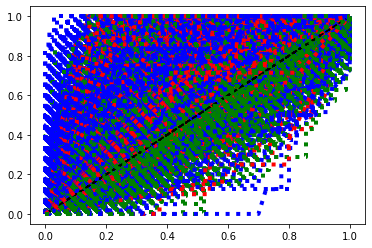

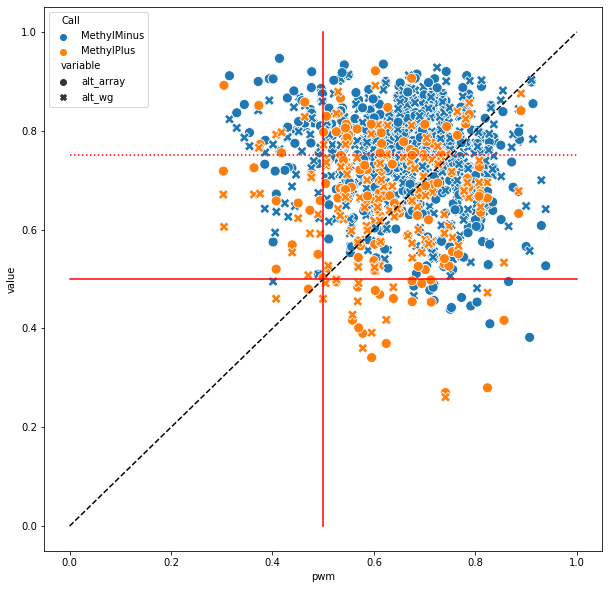

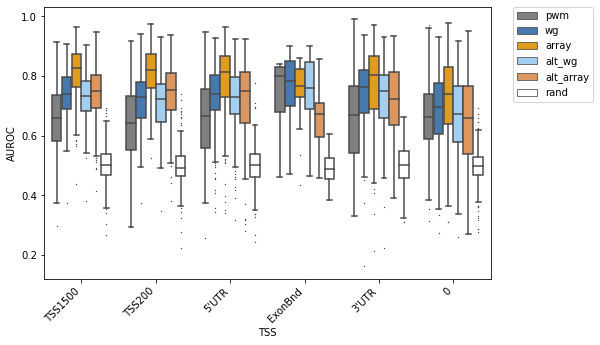

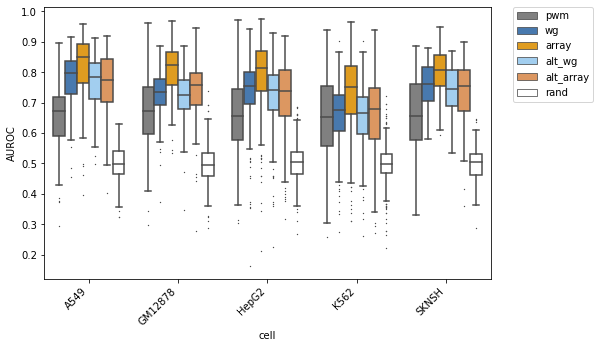

In [528]:
# import shutil
# model_name='/pwm_multi_half/'
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
eq="np.sqrt(data.pwm)"
model_name='/m*sqrt_pwm/'
test_model(indir,eq,model_name)
allbox,allbox00, allbox11=plot_allPredScore(indir+model_name,agg_meth='mean',method='auroc',region=None,depth=None)

df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc
allboxxx22=allbox11.groupby(['variable','TSS','TF','cell']).mean()
allboxxx22=allboxxx22.reset_index()
yyy=allboxxx22[allboxxx22['variable']=='alt_array']
xxx=allboxxx22[allboxxx22['variable']=='alt_wg']

allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
# ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb])

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=aa, x="pwm", y='value', hue="Call",style="variable",
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')

allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
# allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
# allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])
plt.figure(figsize=(8, 5))
plt.grid(False)
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']
del allbox00['value']
aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
ff=allbox00[allbox00['TSS']==www[5]]
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

j=sns.boxplot(x='TSS',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

aa=allbox00[allbox00['cell']=='A549']
bb=allbox00[allbox00['cell']=='GM12878']
cc=allbox00[allbox00['cell']=='Hela']
dd=allbox00[allbox00['cell']=='HepG2']
ee=allbox00[allbox00['cell']=='K562']
ff=allbox00[allbox00['cell']=='SKNSH']
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])
plt.figure(figsize=(8, 5))
plt.grid(False)
j=sns.boxplot(x='cell',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox

In [25]:
df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc=cc.dropna(how='all')
cc=cc.drop_duplicates()
# [len(pd.unique(cc['TF name'])),len(cc)]#[cc['TF name']=='NaN']
# cc.drop_duplicates(subset=['TF name'], keep='first')
duplicateRowsDF = cc[cc.duplicated(['TF name'])]
duplicateRowsDF.sort_values('TF name')
# cc

TF name  Unnamed: 1                           Call  \
560   BATF3*         NaN                   inconclusive   
476   BATF3*         NaN                   inconclusive   
409     BCL6         NaN  Little effect and MethylMinus   
410    BCL6B         NaN  Little effect and MethylMinus   
253    CREB1         NaN                    MethylMinus   
541    CREB3         NaN                    MethylMinus   
256    CREB3         NaN                    MethylMinus   
258  CREB3L1         NaN                    MethylMinus   
414  CREB3L1         NaN     MethylMinus and MethylPlus   
547    CREB5         NaN                    MethylMinus   
478     DBP*         NaN                   inconclusive   
442     E2F2         NaN                  Little effect   
549     ELF5         NaN                    MethylMinus   
282      ERG         NaN                    MethylMinus   
292     ETV3         NaN                    MethylMinus   
298     FLI1         NaN                    MethylMinus   
323     HEY2         NaN                    MethylMinus   
22    HOXA10         NaN                     MethylPlus   
42    HOXC10         NaN                     MethylPlus   
44    HOXC11         NaN                     MethylPlus   
484     HSF5         NaN                   inconclusive   
489    IRF3*         NaN                   inconclusive   
563    IRF3*         NaN                   inconclusive   
565    IRF8*         NaN                   inconclusive   
81     KLF12         NaN                     MethylPlus   
530    KLF15         NaN                     MethylPlus   
455    KLF17         NaN                  Little effect   
352      MLX         NaN                    MethylMinus   
109   NFATC1         NaN                     MethylPlus   
112   NFATC2         NaN                     MethylPlus   
116   NFATC3         NaN                     MethylPlus   
465    NR2F1         NaN                     MethylPlus   
426     PAX3         NaN  MethylMinus and Little effect   
367     PAX3         NaN                    MethylMinus   
468     PAX4         NaN                  Little effect   
368     PAX7         NaN                    MethylMinus   
427     PAX7         NaN  MethylMinus and Little effect   
165   POU3F2         NaN                     MethylPlus   
470     RFX5         NaN                  Little effect   
189    SNAI1         NaN                     MethylPlus   
380     SPIB         NaN                    MethylMinus   
382   SREBF1         NaN                    MethylMinus   
496      YY1         NaN                   inconclusive   
502    ZIC1*         NaN                   inconclusive   
506    ZIC3*         NaN                   inconclusive   
571    ZNF76         NaN                   inconclusive   
66       NaN         NaN                            NaN   
266      NaN         NaN                            NaN   
299      NaN         NaN                            NaN   
423      NaN         NaN                            NaN   
462      NaN         NaN                            NaN   
501      NaN         NaN                            NaN   
580      NaN         NaN                     MethylPlus   
604      NaN         NaN                    MethylMinus   
619      NaN         NaN                  Little effect   

                 methyl-SELEX call        bisulfite call  
560                    MethylMinus         Little effect  
476                    MethylMinus       weak MethylPlus  
409  Little effect and MethylMinus         not available  
410  Little effect and MethylMinus         Little effect  
253                    MethylMinus           MethylMinus  
541                    MethylMinus      weak MethylMinus  
256                    MethylMinus         not available  
258                    MethylMinus        low enrichment  
414     MethylMinus and MethylPlus         not available  
547                    MethylMinus        low enrichment  
478                    MethylMinus         Little e

In [111]:
indirs=('../../d/tmp/redmo/data/PipeTest/*') #500/'
# traces = [log for log in glob.glob(indir+'/**') if not os.path.isdir(log)]
# traces=[x[0] for x in os.walk(indirs)]
traces=glob.glob(indirs)
for indir in traces:  #[1:2]: #traces[1:30]:
    print(indir)

../../d/tmp/redmo/data/PipeTest/250
../../d/tmp/redmo/data/PipeTest/500
../../d/tmp/redmo/data/PipeTest/10000
../../d/tmp/redmo/data/PipeTest/1000
../../d/tmp/redmo/data/PipeTest/20
../../d/tmp/redmo/data/PipeTest/10
../../d/tmp/redmo/data/PipeTest/50
../../d/tmp/redmo/data/PipeTest/5000
../../d/tmp/redmo/data/PipeTest/test
../../d/tmp/redmo/data/PipeTest/5
../../d/tmp/redmo/data/PipeTest/100
../../d/tmp/redmo/data/PipeTest/0


### define function first (above)

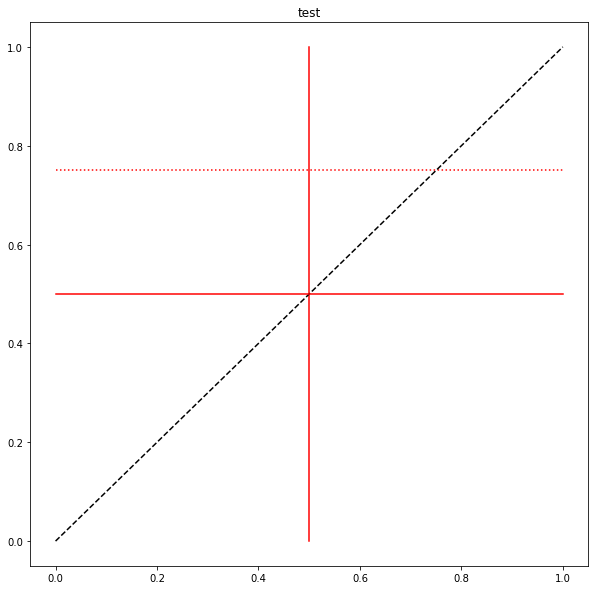

[nan, nan]


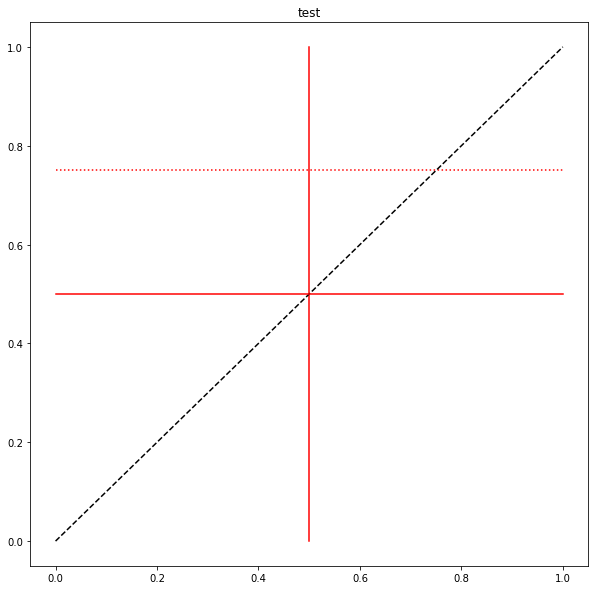

[nan, nan]


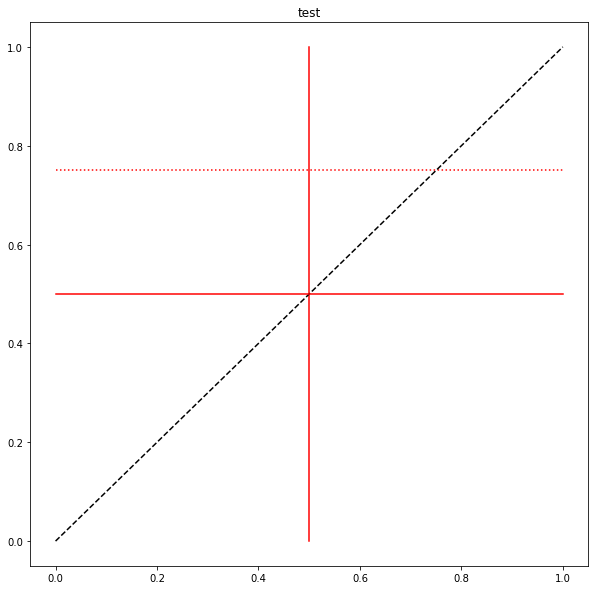

[nan, nan]


In [101]:

indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
# traces = [log for log in glob.glob(indir+'/**') if not os.path.isdir(log)]
traces=[x[0] for x in os.walk(indir)]
www=["0",'TSS1500','TSS200',"5'UTR",'ExonBnd',"3'UTR"]

for model_name in traces[1:30]:
#     =trace #'/m^1_ov_sqrt_pwm/'
    # test_model(indir,eq,model_name)
    try:
        allbox,allbox00, allbox11=plot_allPredScore(model_name+'/',agg_meth='mean',method='auroc',region=None,depth=None)

        df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

        cc=pd.DataFrame(df_sheet_index)
        # TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
        cc=cc.dropna(how='all')
        cc=cc.drop_duplicates()
        # [len(pd.unique(cc['TF name'])),len(cc)]#[cc['TF name']=='NaN']
        cc.drop_duplicates(subset=['TF name'], keep='last') ##try last too
        allboxxx22=allbox11.groupby(['variable','TSS','TF']).mean() #remove 'cell'
        allboxxx22=allboxxx22.reset_index()
        yyy=allboxxx22[allboxxx22['variable']=='alt_array']
        xxx=allboxxx22[allboxxx22['variable']=='alt_wg']

        allboxxx22=pd.concat([yyy,xxx])

        aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
        aaa=aa[aa['Call']=='MethylMinus']
        bbb=aa[aa['Call']=='MethylPlus']
        # ccc=aa[aa['Call']=='Little effect']
        aa=pd.concat([aaa,bbb])

        aaaa=aa[aa['TSS']==www[0]]
        bb=aa[aa['TSS']==www[1]]
        cc=aa[aa['TSS']==www[2]]
        dd=aa[aa['TSS']==www[3]]
        ee=aa[aa['TSS']==www[4]]
        ff=aa[aa['TSS']==www[5]]
        aaaa['region']='body_'#+aaaa.variable
        bb['region']='promoter_'#+bb.variable
        cc['region']='promoter_'#+cc.variable
        dd['region']='body_'#+dd.variable
        ee['region']='body_'#+ee.variable
        ff['region']='body_'#+ff.variable
        are=pd.concat([bb,cc,dd,ee,ff])
        aaxx=are.groupby(['value','region','TF','Call']).mean() 

        plt.figure(figsize=(10, 10))
        ax = plt.axes()
        sns.scatterplot(
            data=aaxx, x="pwm", y='value', hue="Call",style="region",
            sizes=(200, 200), legend='full',s=100,ax=ax)#.set(title=os.Path.basename(model_name))
        plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
        plt.plot([0.5,0.5],[0,1], 'r-')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,1], [0.5,0.5], 'r-')
        ax.set_title(os.path.basename(model_name))

#         plt.savefig(os.path.basename(model_name)+"scatter.png",dpi=300,bbox_inches = "tight")
        plt.show()
        aaxx.reset_index(inplace=True)
        a=aaxx[aaxx['Call']=='MethylMinus']
        b=aaxx[aaxx['Call']=='MethylPlus']
        t, p = stats.ttest_ind(a.value.dropna(),b.value.dropna())
        print([t,p])
#         allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
#         allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
#         # allbox22=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['wg'])
#         # allbox33=pd.melt(allbox, id_vars=['cell','TSS','size','yes'], value_vars=['array'])
#         plt.figure(figsize=(8, 5))
#         plt.grid(False)
#         allbox00=allbox00[allbox00.cell!='overlap']
#         allbox00['AUROC']=allbox00['value']
#         del allbox00['value']
#         aa=allbox00[allbox00['TSS']==www[0]]
#         bb=allbox00[allbox00['TSS']==www[1]]
#         cc=allbox00[allbox00['TSS']==www[2]]
#         dd=allbox00[allbox00['TSS']==www[3]]
#         ee=allbox00[allbox00['TSS']==www[4]]
#         ff=allbox00[allbox00['TSS']==www[5]]
#         allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

#         j=sns.boxplot(x='TSS',y='AUROC', data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
#         j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.title(os.path.basename(model_name))
#         plt.show()
#         # plt.xticks(rotation=30)
#         allboxxx=allbox
#         plt.savefig(os.path.basename(model_name)+"boxTSS.png",dpi=300,bbox_inches = "tight")

#         aa=allbox00[allbox00['cell']=='A549']
#         bb=allbox00[allbox00['cell']=='GM12878']
#         cc=allbox00[allbox00['cell']=='Hela']
#         dd=allbox00[allbox00['cell']=='HepG2']
#         ee=allbox00[allbox00['cell']=='K562']
#         ff=allbox00[allbox00['cell']=='SKNSH']
#         allbox00=pd.concat([aa,bb,cc,dd,ee,ff])
#         plt.figure(figsize=(8, 5))
#         plt.grid(False)
#         j=sns.boxplot(x='cell',y='AUROC', data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange',sns.xkcd_rgb["light blue"],sns.xkcd_rgb["faded orange"],'white'])
#         j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.title(os.path.basename(model_name))
#         plt.show()

    except:
        pass

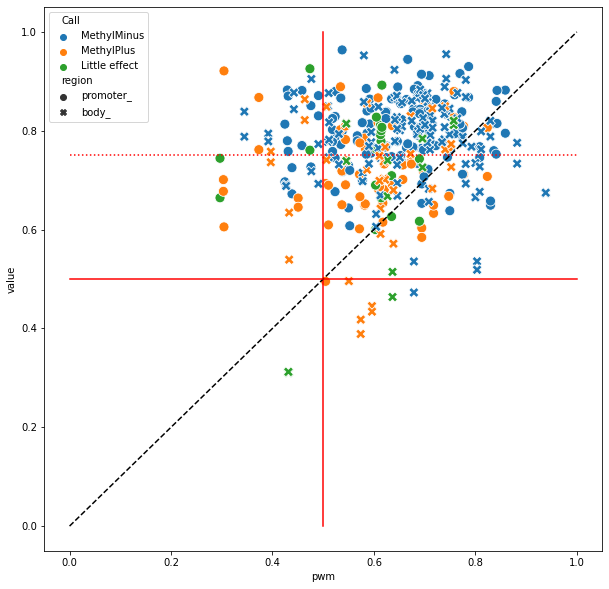

[7.585853500140834, 2.8786514749132694e-13]


In [87]:

indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
# traces = [log for log in glob.glob(indir+'/**') if not os.path.isdir(log)]
traces=[x[0] for x in os.walk(indir)]
www=["0",'TSS1500','TSS200',"5'UTR",'ExonBnd',"3'UTR"]
model_name=traces[2]
# for model_name in traces[1:30]:
#     =trace #'/m^1_ov_sqrt_pwm/'
    # test_model(indir,eq,model_name)
#     try:
allbox,allbox00, allbox11=plot_allPredScore(model_name+'/',agg_meth='mean',method='auroc',region=None,depth=None)

df_sheet_index = pd.read_csv('mili_benchmark/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
# TFs preference: The binding of TFs to DNA is inhibited (MethylMinus), enhanced (MethylPlus) or not affected (Little effect) by CpG methylation.
cc=cc.dropna(how='all')
cc=cc.drop_duplicates()
# [len(pd.unique(cc['TF name'])),len(cc)]#[cc['TF name']=='NaN']
cc.drop_duplicates(subset=['TF name'], keep='last') ##try last too
allboxxx22=allbox11.groupby(['variable','TSS','TF']).mean() #remove 'cell'
allboxxx22=allboxxx22.reset_index()
yyy=allboxxx22[allboxxx22['variable']=='array']
xxx=allboxxx22[allboxxx22['variable']=='wg']

allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
ccc=aa[aa['Call']=='Little effect']
aa=pd.concat([aaa,bbb,ccc])

aaaa=aa[aa['TSS']==www[0]]
bb=aa[aa['TSS']==www[1]]
cc=aa[aa['TSS']==www[2]]
dd=aa[aa['TSS']==www[3]]
ee=aa[aa['TSS']==www[4]]
ff=aa[aa['TSS']==www[5]]
aaaa['region']='body_'#+aaaa.variable
bb['region']='promoter_'#+bb.variable
cc['region']='promoter_'#+cc.variable
dd['region']='body_'#+dd.variable
ee['region']='body_'#+ee.variable
ff['region']='body_'#+ff.variable
are=pd.concat([bb,cc,dd,ee,ff])
aaxx=are#.groupby(['value','region','TF','Call']).mean() 

plt.figure(figsize=(10, 10))
ax = plt.axes()
sns.scatterplot(
    data=aaxx, x="pwm", y='value', hue="Call",style="region",
    sizes=(200, 200), legend='full',s=100,ax=ax)#.set(title=os.Path.basename(model_name))
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')
# ax.set_title(os.path.basename(model_name))

#         plt.savefig(os.path.basename(model_name)+"scatter.png",dpi=300,bbox_inches = "tight")
plt.show()
aaxx.reset_index(inplace=True)
a=aaxx[aaxx['Call']=='MethylMinus']
b=aaxx[aaxx['Call']=='MethylPlus']
t, p = stats.ttest_ind(a.value.dropna(),b.value.dropna())
print([t,p])

#     except:
#         pass

In [ ]:
# body v promoter scatter plot, methyl aurocs by shape, Yin labels as colors
# prune away Yin calls with ambiguity between methyl selex and bisulf selex (only keep best of best calls)
# make sure not averaging array and wgbs
# 1. genome research(impact~9), 2. PNAS (9,translational), 3. genomics(6.2), 
# 4. PLoS CompBio (4), 5. genome biology(?)
# mix comp & genomics (no networks, littler regulatory)